## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# objp = np.zeros((6*9,3), np.float32)
# objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# # Arrays to store object points and image points from all the images.
# objpoints = [] # 3d points in real world space
# imgpoints = [] # 2d points in image plane.

# # Make a list of calibration images
# images = glob.glob('../camera_cal/calibration*.jpg')

# # Step through the list and search for chessboard corners
# for fname in images:
#     img = cv2.imread(fname)
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#     # Find the chessboard corners
#     ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

#     # If found, add object points, image points
#     if ret == True:
#         objpoints.append(objp)
#         imgpoints.append(corners)

#         # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

In [2]:
def get_points(chess_path='../camera_cal/calibration*.jpg'):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(chess_path)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints

In [86]:
#Once objpoints and imgpoints are found, we can map the 3-D to the 2-D

def camera_calibrate(objpoints, imgpoints, img_path='../camera_cal/calibration1.jpg'):
    img = cv2.imread(img_path)
    img_size = img.shape[0:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret, mtx, dist

def plot_compare(img1, img2, p1='1', p2='2'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(p1, fontsize=50)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(p2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return f

def mp_compare(images, names, nrow, ncol):
    fig = plt.figure(figsize=(40, 16))
    for i in range(1, len(images) + 1):
        fig.add_subplot(nrow, ncol, i)
        plt.imshow(images[i-1], cmap='gray')
        plt.title(names[i-1])
    return fig


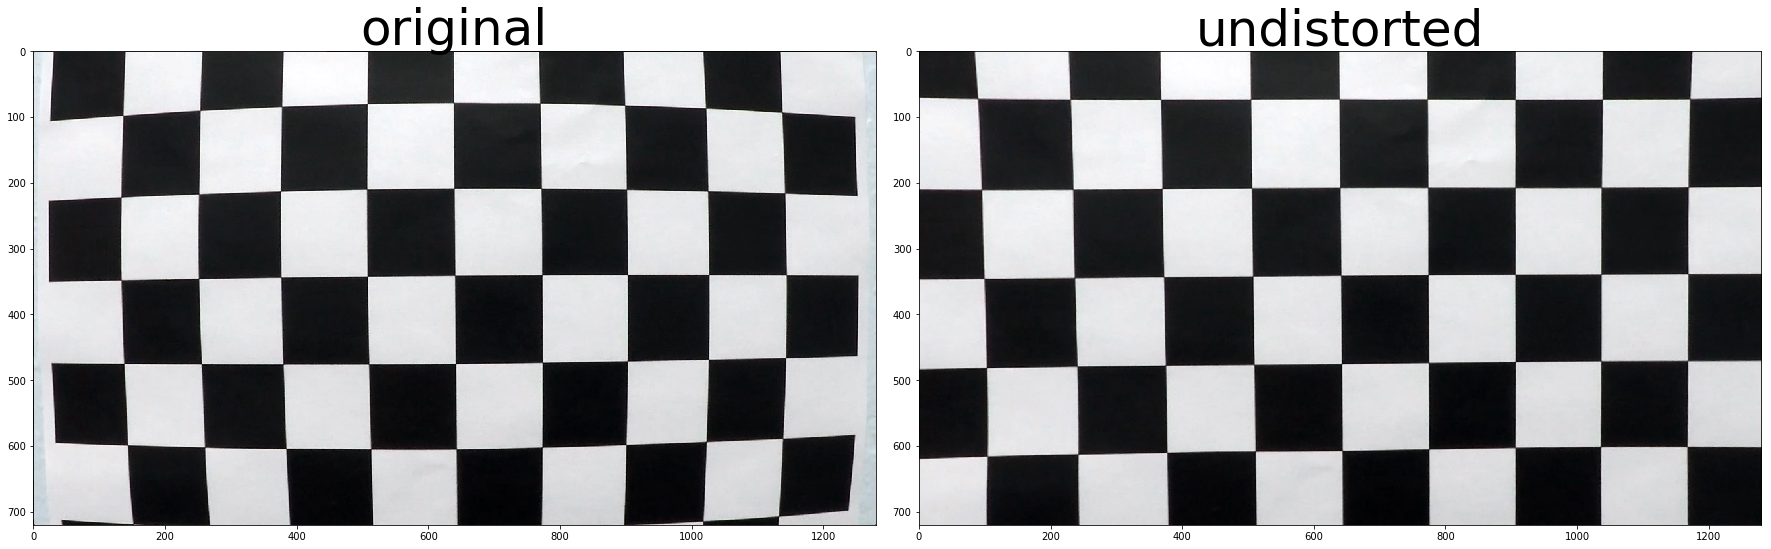

In [78]:
#We can undistort an image like so:
test_image = cv2.imread('../camera_cal/calibration1.jpg')
objpoints, imgpoints = get_points()
ret, mtx, dist = camera_calibrate(objpoints, imgpoints)
undistorted = cv2.undistort(test_image, mtx, dist, None, mtx)
#plot
f = plot_compare(test_image, undistorted, p1='original', p2='undistorted')
f.savefig('chess.png')

In [5]:
"""wrapper function that undistorts image"""
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

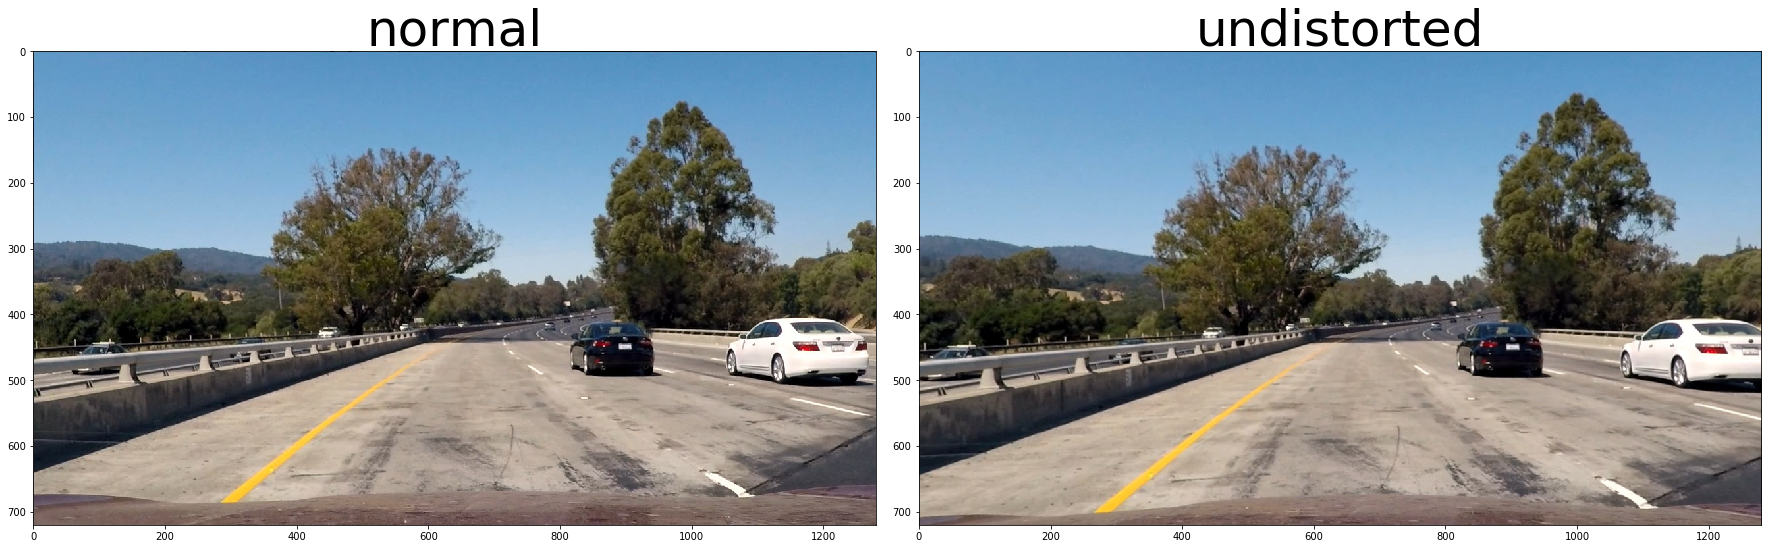

In [88]:
img = plt.imread("../test_images/test1.jpg")
f = plot_compare(img, undistort(img, mtx, dist), 'normal', 'undistorted')
f.savefig('normvsundistort.png')

In [6]:
def mminv(src=np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]]), 
          dst=np.float32([[320, 0], [320,720], [960, 720], [960, 0]])):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return (M, Minv)

In [7]:
"""Warps undistorted image to eagle-eye view and returns M and Minv"""
def warp(img, M):
    img_size = (img.shape[1], img.shape[0])
    #compute perspective and inverse perspective transforms
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [8]:
def crop(img, M, Minv):
    return warp(warp(img, M), Minv)

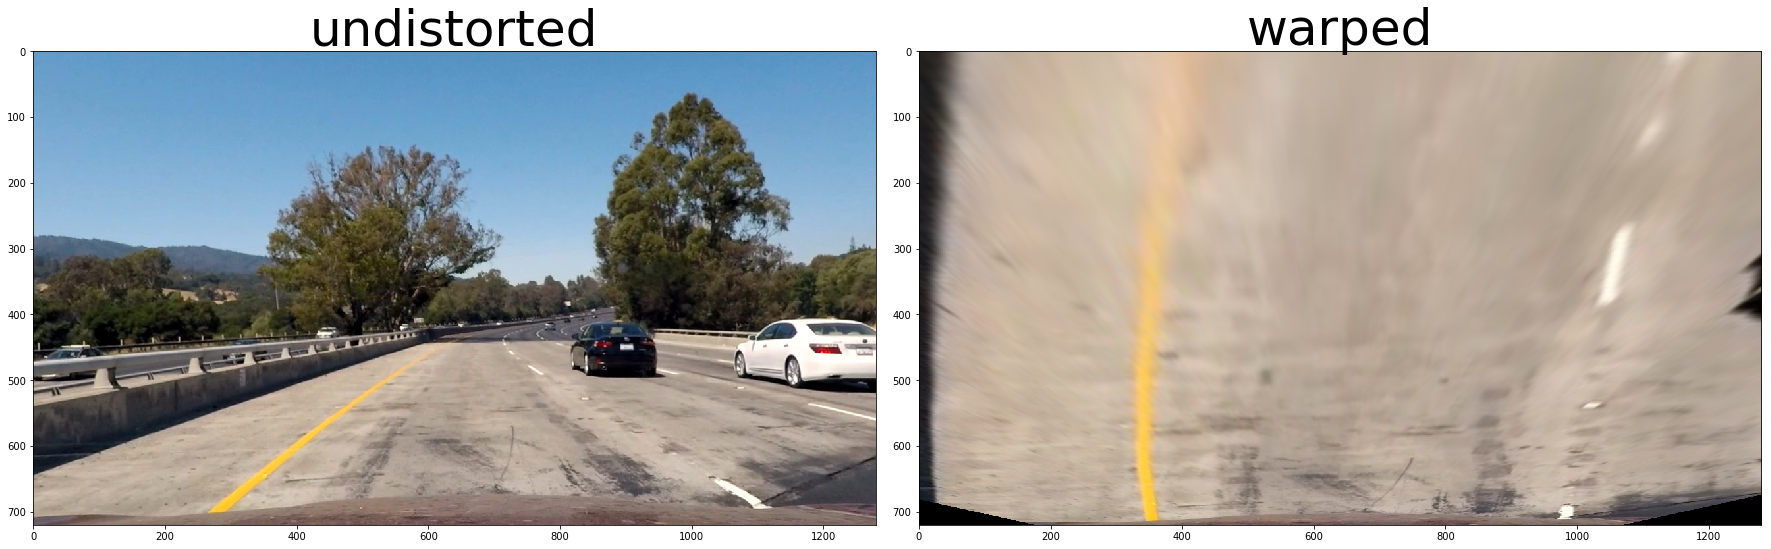

In [79]:
#For now I am going to use the example src and dst points provided by Udacity
img = plt.imread("../test_images/test1.jpg")
undistorted = undistort(img, mtx, dist)
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320,720], [960, 720], [960, 0]])
M, Minv = mminv(src, dst)
# img_size = (undistorted.shape[1], undistorted.shape[0])
# warped = cv2.warpPerspective(undistorted, M, img_size)
warped = warp(undistorted, M)

f = plot_compare(undistorted, warped, p1='undistorted', p2='warped')
f.savefig('warp.png')

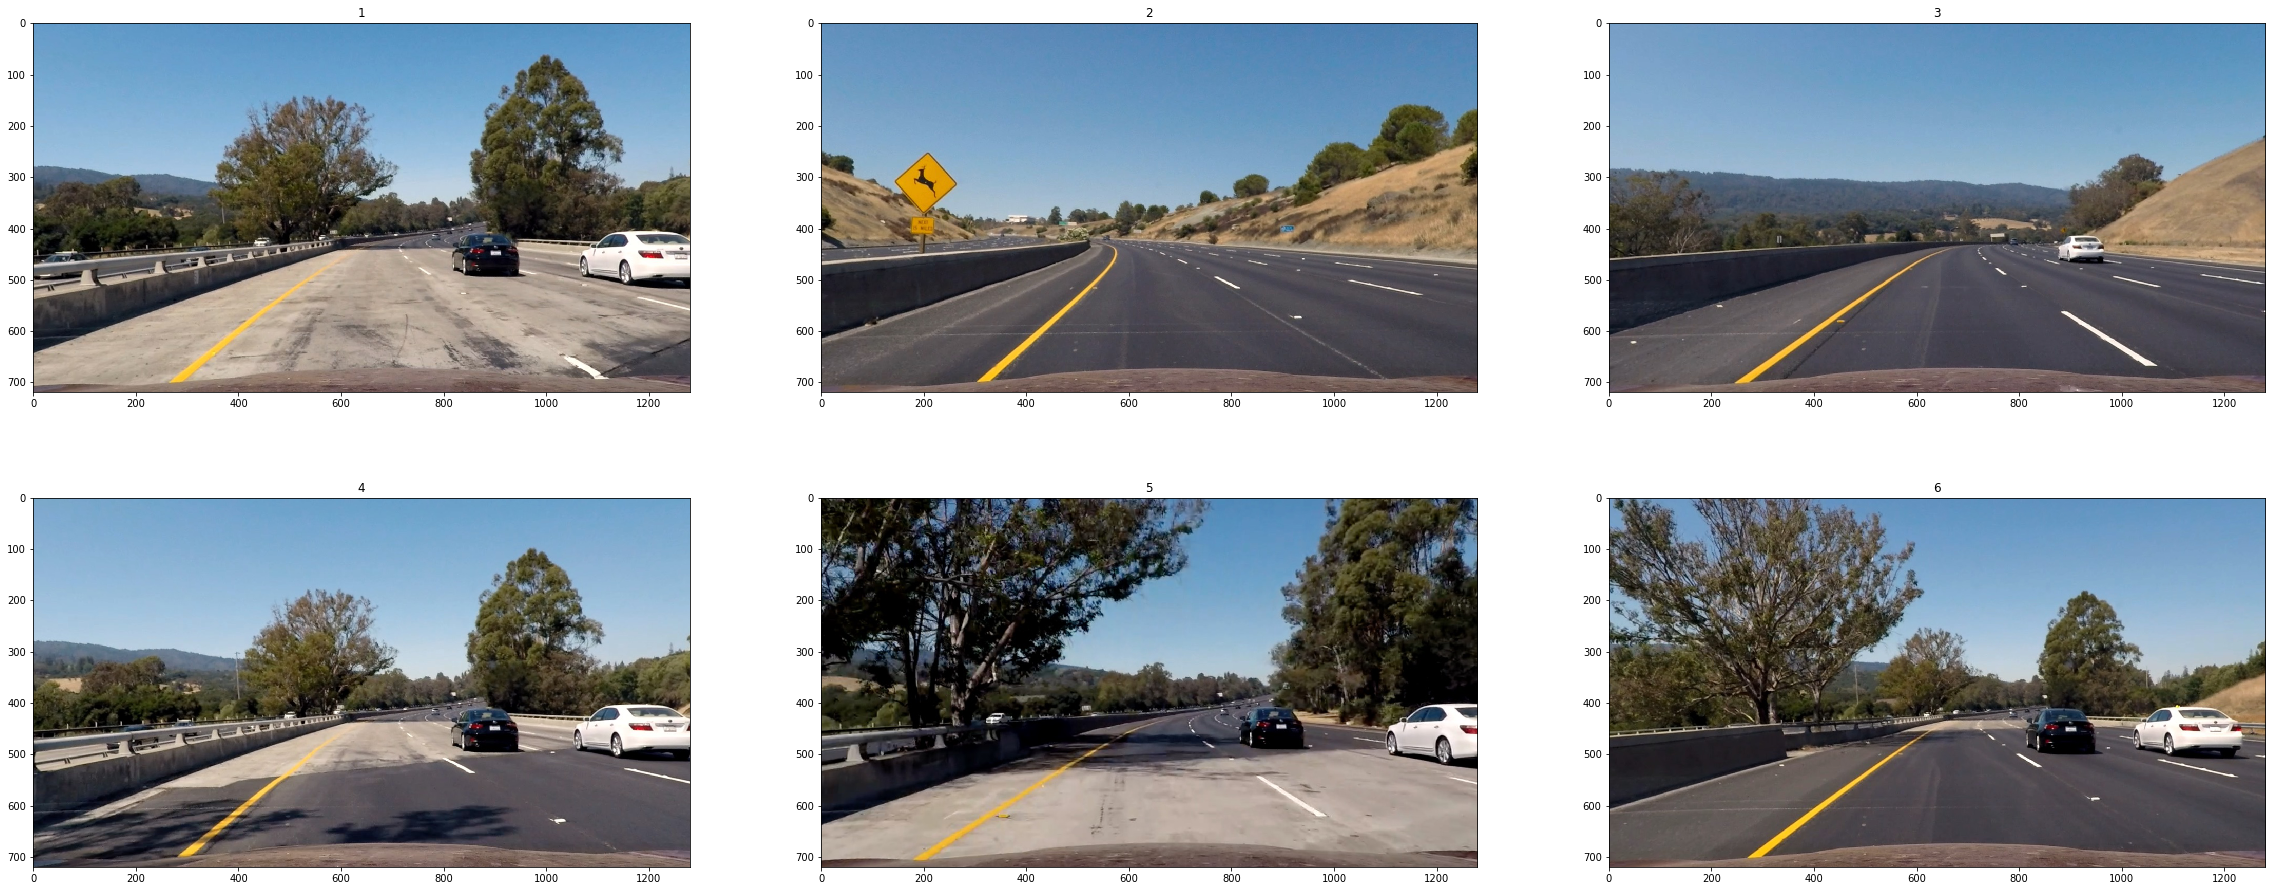

In [10]:
test_images = glob.glob('../test_images/test*.jpg')
imgs = []
names=[i+1 for i in range(6)]
for i in test_images:
    img = undistort(plt.imread(i), mtx, dist)
    imgs.append(img)
mp_compare(imgs, names, 2, 3)

In [67]:
#With that out of the way, apply some color/sobel filters to create an image for identifying lines

"""Takes in warped image and returns a saturation mask with low threshold applied"""
def sat_thresh(img, thresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    hbinary = np.zeros_like(S)
    #apply threshold to S channel
    hbinary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return hbinary
    

"""Takes in warped image and returns a saturation mask with low threshold applied"""
def abs_sobel_thresh(img, thresh=(30,100), ksize=3, orient='x'):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def r_thresh(img, thresh=(200, 255)):
    R = img[:,:,0]
    binary = np.ones_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 0
    return binary

# Define a function that thresholds the S-channel of HLS
def light_thresh(img, thresh=(210, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    binary = np.zeros_like(l_channel)
    binary[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary

def hue_thresh(img, thresh=(20, 40)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    binary = np.zeros_like(h_channel)
    binary[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    return binary
    
def hls_thresh(img, hthresh=(20, 40), lthresh=(210, 255), sthresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    binary = np.zeros_like(h_channel)
    binary[((l_channel > lthresh[0]) & (l_channel <= lthresh[1])) | 
          ((h_channel > hthresh[0]) & (h_channel <= hthresh[1])) | 
          ((s_channel > sthresh[0]) & (s_channel <= sthresh[1]))] = 1
    return binary
    
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, ksize=3, mag_thresh=(70,100)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    m = np.zeros_like(scaled_sobelxy)
    m[(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return m

def dir_threshold(img, ksize=3, thresh=(0.8, 0.9)):   
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately\
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(grad)
    mask[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

"""just applies chosen filter to an image"""
def filter_image(img):
    
    hue = hue_thresh(img, thresh=(10, 50))
    sat = sat_thresh(img, thresh=(100,255))
    light = light_thresh(img)
    gradx = abs_sobel_thresh(img, orient='x', ksize=3)
    grady = abs_sobel_thresh(img, orient='y', ksize=21)
    mag = mag_thresh(img, mag_thresh=(80,110))
    
    res = np.zeros_like(sat)
    #res[((hue == 1) & (sat == 1)) | (light == 1) | ((gradx == 1) & (grady == 1)) | (mag == 1)] = 1
    res[((hue == 1) | (sat == 1)) | (light == 1) | ((gradx == 1) & (grady == 1)) | (mag == 1)] = 1
    return res

"""applies distortion correction, filters, and warps an image"""
def doctor(img):
    return warp(filter_image(undistort(img, mtx, dist)), M)

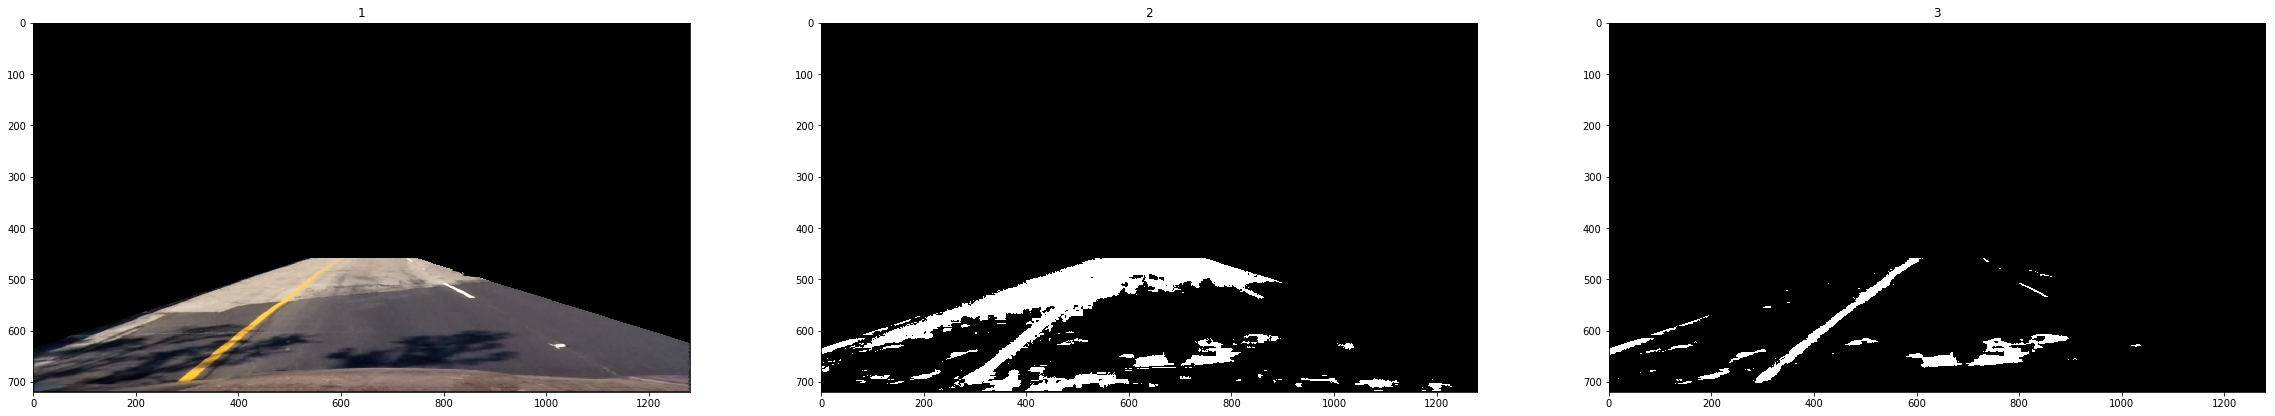

In [68]:
dir_binary = dir_threshold(undistorted, ksize=15, thresh=(0.7, 1.3))
mag_binary = mag_thresh(undistorted, ksize=19, mag_thresh=(30, 100))
# gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(20, 100))
gradx = abs_sobel_thresh(undistorted, orient='x', ksize=3, thresh=(20, 100))
grady = abs_sobel_thresh(undistorted, orient='y', ksize=9, thresh=(60, 255))
sat = sat_thresh(undistorted, thresh=(90, 255))
red = r_thresh(undistorted, thresh=(80, 225))
s = hls_thresh(undistorted)
mp_compare([crop(undistorted, M, Minv), crop(filter_image(undistorted), M, Minv), crop(sat, M, Minv)], ['1','2','3'], 1, 3)

In [55]:
test_images = glob.glob('../test_images/test*.jpg')
imgs = []
names=[i+1 for i in range(6)]
for i in test_images:
    img = crop(undistort(cv2.imread(i), mtx, dist), M, Minv)
    imgs.append(img)

In [83]:
test = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
sat = sat_thresh(test, thresh=(100,255))
hls = hls_thresh(test, sthresh=(170,255))
light = light_thresh(test)
hue = hue_thresh(test, thresh=(10, 50))
red = r_thresh(test, thresh=(70, 225))
mag = mag_thresh(test, mag_thresh=(80,110))
gradx = abs_sobel_thresh(test, orient='x', ksize=3)
grady = abs_sobel_thresh(test, orient='y', ksize=21)
dir_binary = dir_threshold(test)

asdf = np.zeros_like(sat)
asdf[((hue == 1) | (sat == 1)) | (light == 1) | ((gradx == 1) & (grady == 1)) | (mag == 1)] = 1

hue_sat = np.zeros_like(sat)
hue_sat[((hue == 1) & (sat == 1)) | (light == 1)] = 1
################
gradx_dir = np.zeros_like(sat)
gradx_dir[(hls == 1) | ((gradx == 1) & (grady == 1))] = 1

gradxy = np.zeros_like(sat)
gradxy[(gradx == 1) & (grady == 1)] = 1

f = filter_image(test)


sat_hls = np.zeros_like(sat)
sat_hls[(sat == 1) & (hls == 1)] = 1
sat_or_hls =  np.zeros_like(sat)
sat_or_hls[(hls == 1) | (sat == 1)] = 1
gradxy = np.zeros_like(sat)
gradxy[(gradx == 1) & (grady == 1)] = 1
gradxy_sat_hls = np.zeros_like(sat)
gradxy_sat_hls[(gradx == 1)| ((hls == 1) & (sat == 1))] = 1

# images = [test, hls, light, sat_hls, sat_or_hls, red, mag, gradx, grady, dir_binary, gradxy, gradxy_sat_hls]
# names = ['original', 'hls', 'light', 'sat_hls', 'sat_or_hls', 'red', 'mag', 'gradx', 'grady', 'dir_binary', 'gradxy', 'lol']

images = [test, mag, hue, light, sat, gradx, grady, gradxy, hue_sat]
names = ['test', 'mag', 'hue', 'light', 'sat', 'gradx', 'grady', 'gradxy', 'hue_sat']


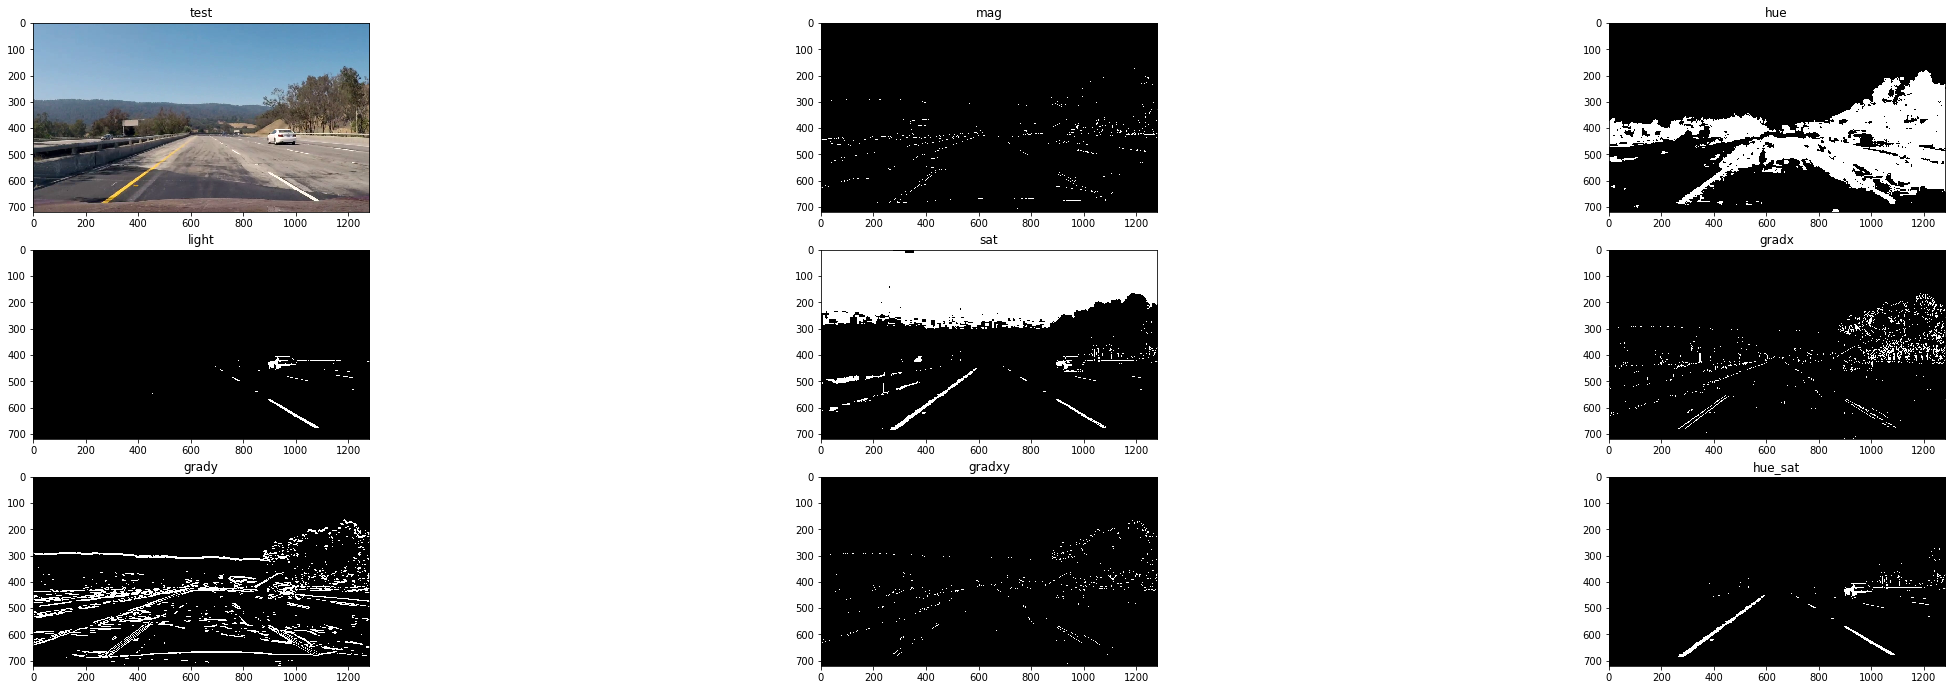

In [84]:
mp_compare(images, names, 4, 3)


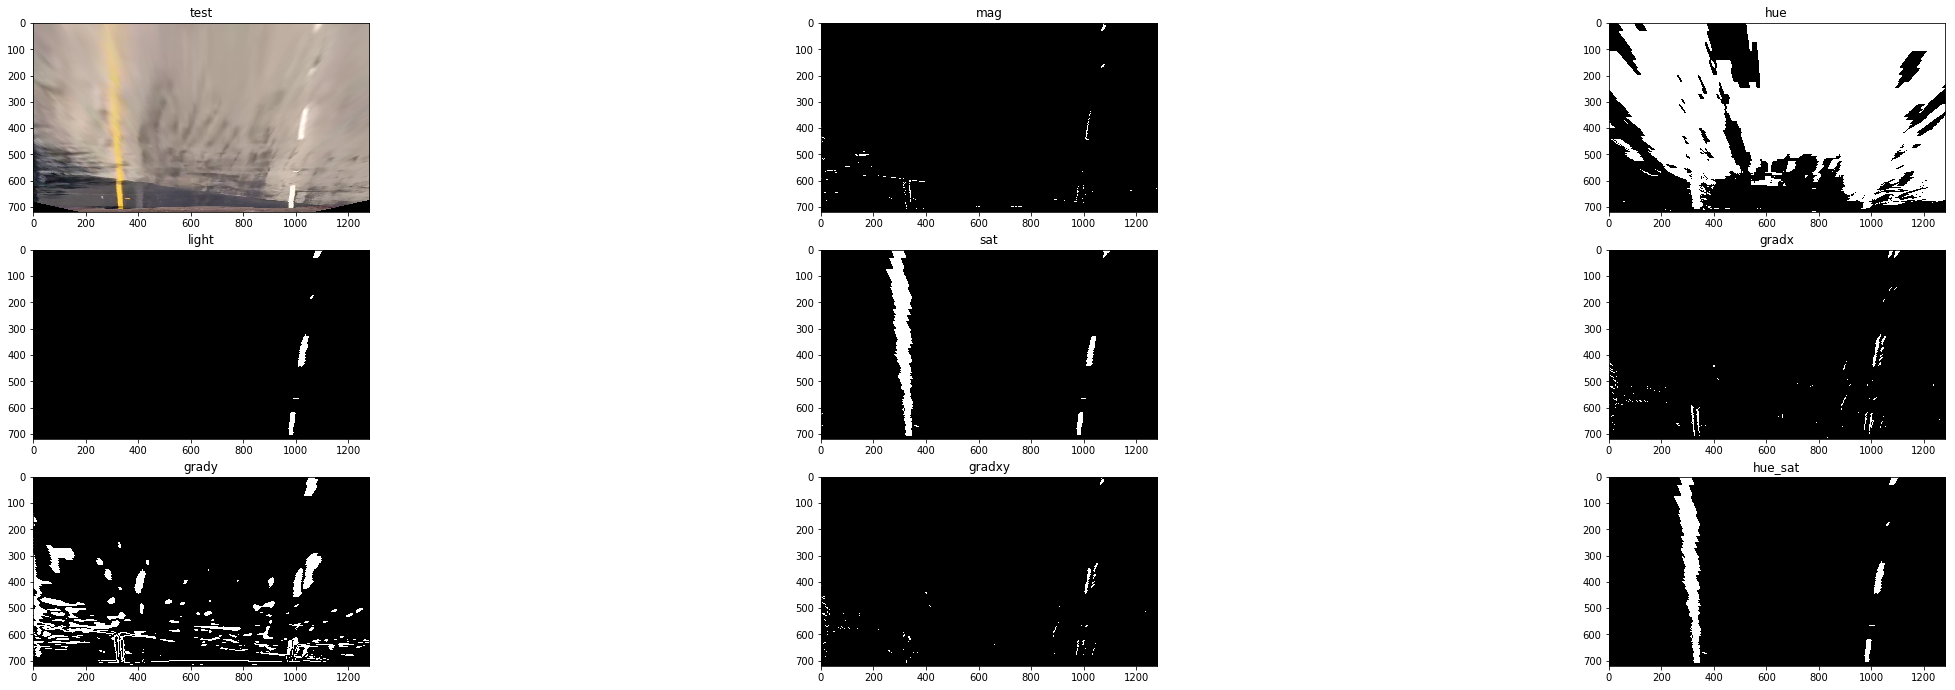

In [87]:
wp = []
for img in images:
    wp.append(warp(img, M))
    
f = mp_compare(wp, names, 4, 3)
f.savefig('multiple.png')

## And so on and so forth...

In [65]:
"""Provided by Udacity"""
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

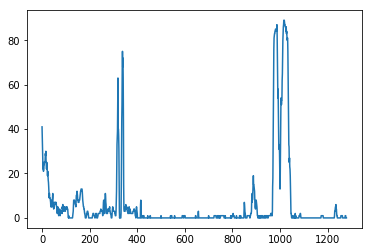

In [66]:
result = warp(filter_image(test), M)
histogram = hist(result)
plt.plot(histogram)

In [ ]:
#Use two highest peaks as approximate locations of lanes
out_img = np.dstack((result, result, result))*255
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [ ]:
#First, I will implement a sliding windows approach to identify the curvature of the lanes. 
#Base code provided by Udacity. However I will be tuning the hyperparameters. 
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(all_combined.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = all_combined.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


In [ ]:
#When the mean position of activated pixels changes, the box is shifted each iteration. 


In [13]:
#Here are some more helper methods provided by Udacity 
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

def fit_polynomial2(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2) 
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty, left_fit, right_fit, (leftx, lefty, rightx, righty)


In [ ]:
result = warp(filter_image(test), M)

out_img = fit_polynomial(result)

plt.imshow(out_img)

In [ ]:
# Create an image to draw the lines on
test = plt.imread('../test_images/test3.jpg')
undistorted = undistort(test, mtx, dist)
result = warp(filter_image(undistorted), M)
left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial2(result)
warp_zero = np.zeros_like(result).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
# Combine the result with the original image
r = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(r)

In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, coeffs, allx, ally, ploty, curve):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [[coeffs[0]*ploty**2 + coeffs[1]*ploty + coeffs[2]]]
        #average x values of the fitted line over the last n iterations
        self.bestx = [np.mean(self.recent_xfitted)]
        # polynomial coeffs of the last n fits of the line
        self.all_poly = np.array([coeffs])
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = coeffs  
        #polynomial coefficients for the most recent fit
        self.current_fit = coeffs
        #radius of curvature of the line in some units
        self.radius_of_curvature = curve
        #distance in meters of vehicle center from the line
        self.line_base_pos = np.abs(self.bestx[-1] - 620) * 6.5/720
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = allx  
        #y values for detected line pixels
        self.ally = ally  

In [15]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def fit_poly2(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result



def search_around_poly2(binary_warped, left_fitx, right_fitx, ploty, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly2(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, (leftx, lefty, rightx, righty)

def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


def draw(undistorted, doctored, left, right, ploty):
    left_fitx = left.recent_xfitted[-1]
    right_fitx = right.recent_xfitted[-1]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(doctored).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    return result

"""creates an image and initializes left and right lines"""
def create_lines(img):
    doc = doctor(img)
    left_fitx, right_fitx, ploty, left_fit, right_fit, (leftx, lefty, rightx, righty) = fit_polynomial2(doc)
    lcurve, rcurve = measure_curvature_real(ploty, left_fit, right_fit)
    left = Line(left_fit, leftx, lefty, ploty, lcurve)
    right = Line(right_fit, rightx, righty, ploty, rcurve) 
    
    return left, right

In [16]:
test = plt.imread('../test_images/test5.jpg')
undistorted = undistort(test, mtx, dist)
doctored = doctor(test)

img_shape = doctored.shape
ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
left, right = create_lines(test)
#print(left.__dict__)
#plt.imshow(draw(test, doc, ))

plt.imshow(draw(undistorted, doc, left, right, ploty))

NameError: name 'doc' is not defined

In [17]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 13.5/1280 # meters per pixel in y dimension
    xm_per_pix = 6.5/720 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [18]:
def update_line(line, fitx, coeffs, curve, allx, ally):
    line.recent_xfitted.append(np.array(fitx))
    line.bestx.append(np.mean(fitx))
    line.all_poly = np.append(line.all_poly, np.array([coeffs]), axis=0)
    line.best_fit = np.mean(line.all_poly)
    line.current_fit = np.array(coeffs)
    line.radius_of_curvature = curve
    line.line_base_pos = np.abs(line.bestx[-1] - 620) * 6.5/720
    line.diffs = line.all_poly[-2] - line.current_fit
    line.allx = allx
    line.ally = ally
    

1.2187229003757238e-10 1.0095391189679503e-10
[-1.10046521e-17  4.88498131e-15  4.54747351e-13]


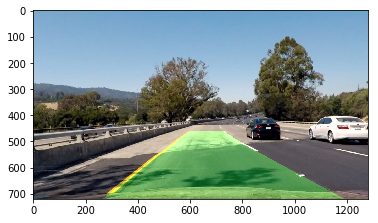

In [40]:
test = plt.imread('../test_images/test4.jpg')
undistorted = undistort(test, mtx, dist)
doctored = doctor(test)
img_shape = doctored.shape

img_shape = doctored.shape
left, right = create_lines(test)

#created lines. Now, we pass into pipeline so they can be updated

plt.imshow(pipeline3(test, left, right))
print(right.diffs)



In [20]:
def pipeline3(img, left, right):
    undistorted = undistort(img, mtx, dist)
    doctored = warp(filter_image(undistorted), M)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    
    left_fitx, right_fitx, ploty, left_fit, right_fit, (leftx, lefty, rightx, righty) = \
    search_around_poly2(doctored,left.recent_xfitted[-1],right.recent_xfitted[-1], \
                                                    ploty, left.current_fit, right.current_fit)
    lcurve, rcurve = measure_curvature_real(ploty, left_fit, right_fit)
    
    #update lines
    ldiff = np.abs(lcurve - left.radius_of_curvature)
    rdiff = np.abs(rcurve - right.radius_of_curvature)
    print(ldiff, rdiff)
    
    update_line(left, left_fitx, left_fit, lcurve, leftx, lefty)
    update_line(right, right_fitx, right_fit, rcurve, rightx, righty)
    
    return draw(undistorted, doctored, left, right, ploty)

In [176]:
# def pipeline2(img, left_fitx, right_fitx, ploty, left_fit, right_fit):
#     undistorted = undistort(img, mtx, dist)
#     doctored = warp(filter_image(undistorted), M)
#     left_fitx, right_fitx, ploty, left_fit, right_fit = search_around_poly2(doctored, left_fitx, 
#                                                                         right_fitx, ploty, left_fit, right_fit)
    
#     # Create an image to draw the lines on
#     warp_zero = np.zeros_like(doctored).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

#     # Recast the x and y points into usable format for cv2.fillPoly()
#     pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
#     pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
#     pts = np.hstack((pts_left, pts_right))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

#     # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
#     # Combine the result with the original image
#     result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
#     return result

In [177]:
#plt.imshow(pipeline(first_img, lfx, rfx, py, lf, rf))
#plt.imshow(pipeline(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB)))

# result = warp(filter_image(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB)), M)

# out_img = fit_polynomial(result)
test = plt.imread('../test_images/test6.jpg')

binary_warped = doctor(test)
left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial2(binary_warped)
e = pipeline2(test, left_fitx, right_fitx, ploty, left_fit, right_fit)

plt.imshow(e)

ValueError: too many values to unpack (expected 5)

In [62]:
test_images = glob.glob('../test_images/test*.jpg')

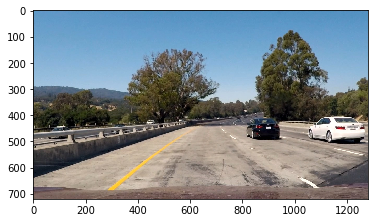

In [63]:
img = plt.imread(test_images[0])
plt.imshow(img)

In [64]:
def pipeline(img):
    undistorted = undistort(img, mtx, dist)
    result = warp(filter_image(undistorted), M)
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial2(result)
    warp_zero = np.zeros_like(result).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    r = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return r

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

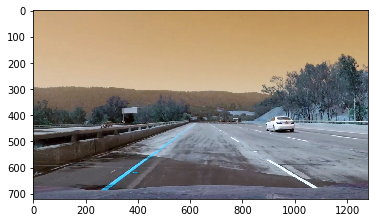

In [51]:
#Use CV2 to read the first frame of the test video

vid = cv2.VideoCapture("../project_video.mp4")
success, first_img = vid.read()


for i in range(1, 552):
    a, fr = vid.read()
    




In [69]:
left, right = create_lines(first_img)

def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline3(img, left, right)

    return result

In [73]:
white_output = '../out1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1.reader.close()
# clip1.audio.reader.close_proc()
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

315746.13507453335 126777.32315984713
[MoviePy] >>>> Building video ../out1.mp4
[MoviePy] Writing video ../out1.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

83.85024821087427 7288.637516073682


  0%|                                         | 1/1261 [00:00<03:31,  5.95it/s]

87.19626433449912 271.61074501152825


  0%|                                         | 2/1261 [00:00<03:30,  6.00it/s]

461.23108055223884 243.33582612016744


  0%|                                         | 3/1261 [00:00<03:30,  5.97it/s]

60.900427358538764 369.2513103132144


  0%|▏                                        | 4/1261 [00:00<03:28,  6.02it/s]

60.56288260033443 359.3841686433261


  0%|▏                                        | 5/1261 [00:00<03:29,  5.99it/s]

167.7674246621068 278.0273287749965


  0%|▏                                        | 6/1261 [00:00<03:27,  6.04it/s]

60.106975758841145 480.5040720689922


  1%|▏                                        | 7/1261 [00:01<03:23,  6.15it/s]

112.11756392884627 1562.2118000043133


  1%|▎                                        | 8/1261 [00:01<03:24,  6.13it/s]

281.2285304701968 613.8932289827035


  1%|▎                                        | 9/1261 [00:01<03:29,  5.99it/s]

245.46194682101395 141.9905884981008


  1%|▎                                       | 10/1261 [00:01<03:33,  5.85it/s]

60.17030229107422 1598.1545392671283


  1%|▎                                       | 11/1261 [00:01<03:36,  5.78it/s]

119.04565856194904 22212.457692730033


  1%|▍                                       | 12/1261 [00:02<03:33,  5.84it/s]

32.04691246532457 3722.3759004278327


  1%|▍                                       | 13/1261 [00:02<03:31,  5.89it/s]

459.5241493494741 2587.552949065146


  1%|▍                                       | 14/1261 [00:02<03:32,  5.88it/s]

351.7697432698442 15459.931321333923


  1%|▍                                       | 15/1261 [00:02<03:38,  5.70it/s]

112.4536291759573 150.68317144756338


  1%|▌                                       | 16/1261 [00:02<03:33,  5.82it/s]

254.8180271834476 491.4308211657044


  1%|▌                                       | 17/1261 [00:02<03:34,  5.81it/s]

302.7279941739912 1293.0165245483972


  1%|▌                                       | 18/1261 [00:03<03:31,  5.87it/s]

662.1978924310929 494.76950195572226


  2%|▌                                       | 19/1261 [00:03<03:25,  6.05it/s]

172.73399201814527 1528.6462408067282


  2%|▋                                       | 20/1261 [00:03<03:22,  6.12it/s]

653.2429835611315 281.83662201201605


  2%|▋                                       | 21/1261 [00:03<03:23,  6.10it/s]

469.7604943426636 9.798436005447456


  2%|▋                                       | 22/1261 [00:03<03:21,  6.14it/s]

109.81504830500717 370.1620374377694


  2%|▋                                       | 23/1261 [00:03<03:20,  6.16it/s]

935.932728488021 876.7865954744552


  2%|▊                                       | 24/1261 [00:03<03:16,  6.28it/s]

997.0165231823185 267.9632787963819


  2%|▊                                       | 25/1261 [00:04<03:13,  6.38it/s]

1013.9930625550687 6138.741429011303


  2%|▊                                       | 26/1261 [00:04<03:15,  6.33it/s]

21.695891144344387 22352.34685379897


  2%|▊                                       | 27/1261 [00:04<03:17,  6.26it/s]

840.6340891501127 3656.125414096259


  2%|▉                                       | 28/1261 [00:04<03:21,  6.11it/s]

270.85110763553575 32830.0665957261


  2%|▉                                       | 29/1261 [00:04<03:21,  6.12it/s]

782.4046253136207 132.19532350902819


  2%|▉                                       | 30/1261 [00:04<03:19,  6.17it/s]

137.37937702455247 91.79072360973305


  2%|▉                                       | 31/1261 [00:05<03:19,  6.17it/s]

300.2100188267632 576.1746011310238


  3%|█                                       | 32/1261 [00:05<03:19,  6.15it/s]

23.182592082918745 1561.2446050238127


  3%|█                                       | 33/1261 [00:05<03:19,  6.14it/s]

218.78467748717026 790.4844811406315


  3%|█                                       | 34/1261 [00:05<03:21,  6.08it/s]

15.389740002669214 1700.1089605619554


  3%|█                                       | 35/1261 [00:05<03:18,  6.17it/s]

95.95887114780612 2472.205768690906


  3%|█▏                                      | 36/1261 [00:05<03:15,  6.25it/s]

64.93262344182654 2122.1382753811504


  3%|█▏                                      | 37/1261 [00:06<03:14,  6.31it/s]

228.82403271269322 4998.782757312494


  3%|█▏                                      | 38/1261 [00:06<03:14,  6.29it/s]

197.41888200863445 4923.023954535806


  3%|█▏                                      | 39/1261 [00:06<03:13,  6.31it/s]

172.92226546167672 185.2501934422412


  3%|█▎                                      | 40/1261 [00:06<03:12,  6.33it/s]

40.2942664528282 592.5470446317809


  3%|█▎                                      | 41/1261 [00:06<03:14,  6.28it/s]

56.951911748691145 132.63301463240896


  3%|█▎                                      | 42/1261 [00:06<03:15,  6.25it/s]

145.78048534180516 37.84781229856662


  3%|█▎                                      | 43/1261 [00:07<03:21,  6.03it/s]

129.2648150860582 411.4176111364891


  3%|█▍                                      | 44/1261 [00:07<03:22,  6.02it/s]

16.398386465823933 456.9726719623809


  4%|█▍                                      | 45/1261 [00:07<03:18,  6.13it/s]

87.58715650190425 521.4839311566889


  4%|█▍                                      | 46/1261 [00:07<03:15,  6.21it/s]

37.90039665749691 18181.328338380838


  4%|█▍                                      | 47/1261 [00:07<03:16,  6.19it/s]

44.202883398932045 6654.008101474319


  4%|█▌                                      | 48/1261 [00:07<03:19,  6.07it/s]

400.4967593064498 10382.09261761665


  4%|█▌                                      | 49/1261 [00:08<03:19,  6.08it/s]

3.3541835829373667 1833.5083645028285


  4%|█▌                                      | 50/1261 [00:08<03:19,  6.07it/s]

229.46756104008045 11205.368211954512


  4%|█▌                                      | 51/1261 [00:08<03:20,  6.03it/s]

129.91930842592956 6727.524947215974


  4%|█▋                                      | 52/1261 [00:08<03:21,  5.99it/s]

16.037525902846937 4585.962816701998


  4%|█▋                                      | 53/1261 [00:08<03:22,  5.97it/s]

186.43441949603584 72.50377799632588


  4%|█▋                                      | 54/1261 [00:08<03:20,  6.02it/s]

759.7981965559743 582.7518842292384


  4%|█▋                                      | 55/1261 [00:09<03:19,  6.05it/s]

146.91680622707372 24.48083814436086


  4%|█▊                                      | 56/1261 [00:09<03:17,  6.10it/s]

748.026409188009 243.3039390226777


  5%|█▊                                      | 57/1261 [00:09<03:16,  6.12it/s]

495.62261397500424 727.2558378452131


  5%|█▊                                      | 58/1261 [00:09<03:19,  6.04it/s]

1137.1650825010133 1255.5413396083095


  5%|█▊                                      | 59/1261 [00:09<03:17,  6.08it/s]

184.5449076929276 24730.070315101555


  5%|█▉                                      | 60/1261 [00:09<03:17,  6.08it/s]

272.89850709573466 24307.033427170387


  5%|█▉                                      | 61/1261 [00:10<03:16,  6.11it/s]

341.07791585569385 319.71035648573707


  5%|█▉                                      | 62/1261 [00:10<03:14,  6.17it/s]

68.2774440063854 50.39707801532313


  5%|█▉                                      | 63/1261 [00:10<03:14,  6.17it/s]

133.20964140994147 1760.7724949154554


  5%|██                                      | 64/1261 [00:10<03:12,  6.22it/s]

340.88469066691323 404.78773444862645


  5%|██                                      | 65/1261 [00:10<03:15,  6.11it/s]

236.55464864061196 315.888816495798


  5%|██                                      | 66/1261 [00:10<03:15,  6.11it/s]

295.92686978321944 351.9616493907829


  5%|██▏                                     | 67/1261 [00:11<03:17,  6.05it/s]

58.21779285226148 130.9695438558365


  5%|██▏                                     | 68/1261 [00:11<03:16,  6.06it/s]

384.3339097696721 700.2431417448356


  5%|██▏                                     | 69/1261 [00:11<03:16,  6.06it/s]

165.7259527033084 459.88664197367143


  6%|██▏                                     | 70/1261 [00:11<03:16,  6.06it/s]

28.220071905388522 5491.849509994771


  6%|██▎                                     | 71/1261 [00:11<03:16,  6.05it/s]

347.9197358636634 35261.24403924506


  6%|██▎                                     | 72/1261 [00:11<03:11,  6.20it/s]

109.41262533493 34130.2739967136


  6%|██▎                                     | 73/1261 [00:11<03:10,  6.23it/s]

370.54023685015 15141.90996113346


  6%|██▎                                     | 74/1261 [00:12<03:15,  6.07it/s]

506.76069553422303 11321.184797204696


  6%|██▍                                     | 75/1261 [00:12<03:13,  6.11it/s]

551.6771325607988 11801.375939542188


  6%|██▍                                     | 76/1261 [00:12<03:13,  6.11it/s]

318.7756622539514 749.6732429173417


  6%|██▍                                     | 77/1261 [00:12<03:13,  6.13it/s]

395.3238657674351 1981.134134193183


  6%|██▍                                     | 78/1261 [00:12<03:17,  5.99it/s]

676.2946087046794 2547.2734455748205


  6%|██▌                                     | 79/1261 [00:12<03:13,  6.11it/s]

582.6480522701349 429.85460851904736


  6%|██▌                                     | 80/1261 [00:13<03:13,  6.11it/s]

429.89791208144743 96.72155334238414


  6%|██▌                                     | 81/1261 [00:13<03:11,  6.17it/s]

357.69529684102235 347.22558491721475


  7%|██▌                                     | 82/1261 [00:13<03:12,  6.13it/s]

229.48490742802733 511.0495533311346


  7%|██▋                                     | 83/1261 [00:13<03:15,  6.04it/s]

77.30648376507361 569.1763472930616


  7%|██▋                                     | 84/1261 [00:13<03:15,  6.04it/s]

431.7425375741677 2409.968968085852


  7%|██▋                                     | 85/1261 [00:13<03:11,  6.13it/s]

176.68228887462647 623.1540271011663


  7%|██▋                                     | 86/1261 [00:14<03:14,  6.04it/s]

1027.0845399524246 977.9562819034404


  7%|██▊                                     | 87/1261 [00:14<03:14,  6.04it/s]

182.452022332845 8574.515241700863


  7%|██▊                                     | 88/1261 [00:14<03:11,  6.11it/s]

1413.3184911472663 8583.156089630142


  7%|██▊                                     | 89/1261 [00:14<03:09,  6.17it/s]

222.4883602987279 943.1552145067144


  7%|██▊                                     | 90/1261 [00:14<03:14,  6.01it/s]

380.5380695952126 36.865381573786635


  7%|██▉                                     | 91/1261 [00:14<03:13,  6.05it/s]

324.95032224926035 119.48245067288462


  7%|██▉                                     | 92/1261 [00:15<03:12,  6.08it/s]

107.69063132182055 225.35319482344903


  7%|██▉                                     | 93/1261 [00:15<03:11,  6.10it/s]

48.84659070243606 470.32770115730864


  7%|██▉                                     | 94/1261 [00:15<03:13,  6.04it/s]

6.6001506271450125 277.2775321381264


  8%|███                                     | 95/1261 [00:15<03:11,  6.08it/s]

219.35184196134787 606.9521056225003


  8%|███                                     | 96/1261 [00:15<03:11,  6.09it/s]

458.3457146572091 252.48429395162248


  8%|███                                     | 97/1261 [00:15<03:08,  6.18it/s]

72.29653569253787 842.6619960784301


  8%|███                                     | 98/1261 [00:16<03:08,  6.17it/s]

73.60167266506278 871.7881765326952


  8%|███▏                                    | 99/1261 [00:16<03:11,  6.07it/s]

310.21584851185617 556.7595659961398


  8%|███                                    | 100/1261 [00:16<03:16,  5.90it/s]

167.38027219728065 1115.6450373724201


  8%|███                                    | 101/1261 [00:16<03:14,  5.96it/s]

15.043010861873427 859.0886841819333


  8%|███▏                                   | 102/1261 [00:16<03:15,  5.94it/s]

301.102629325273 268.31824547747783


  8%|███▏                                   | 103/1261 [00:16<03:14,  5.96it/s]

586.9149102601391 57.039367152663544


  8%|███▏                                   | 104/1261 [00:17<03:14,  5.96it/s]

428.8056274296455 104.50070171577227


  8%|███▏                                   | 105/1261 [00:17<03:12,  5.99it/s]

205.13364113708622 44.30126336990497


  8%|███▎                                   | 106/1261 [00:17<03:13,  5.96it/s]

450.1400006169288 223.4429849436874


  8%|███▎                                   | 107/1261 [00:17<03:12,  5.99it/s]

288.6536917175722 25352.141998312338


  9%|███▎                                   | 108/1261 [00:17<03:11,  6.03it/s]

327.614945950314 20060.704048480475


  9%|███▎                                   | 109/1261 [00:17<03:11,  6.02it/s]

54.08540647234395 2872.0246720885953


  9%|███▍                                   | 110/1261 [00:18<03:10,  6.05it/s]

154.64808844644585 4324.202540316714


  9%|███▍                                   | 111/1261 [00:18<03:09,  6.08it/s]

200.86475970004676 14908.019235315014


  9%|███▍                                   | 112/1261 [00:18<03:13,  5.94it/s]

292.82940151036337 17543.888234899718


  9%|███▍                                   | 113/1261 [00:18<03:14,  5.89it/s]

15.317867481644043 805.0932136990209


  9%|███▌                                   | 114/1261 [00:18<03:11,  5.98it/s]

202.1836812380002 2185.1253376489026


  9%|███▌                                   | 115/1261 [00:18<03:06,  6.14it/s]

133.42298594418958 732.4974520149149


  9%|███▌                                   | 116/1261 [00:19<03:06,  6.15it/s]

62.3635878322325 246.9603876132196


  9%|███▌                                   | 117/1261 [00:19<03:08,  6.08it/s]

43.63840919291056 169.82048282339156


  9%|███▋                                   | 118/1261 [00:19<03:08,  6.05it/s]

77.92007031527305 63.45273201774671


  9%|███▋                                   | 119/1261 [00:19<03:11,  5.97it/s]

55.06192805160549 340.159831612325


 10%|███▋                                   | 120/1261 [00:19<03:08,  6.06it/s]

431.7412366052822 426.9972695523179


 10%|███▋                                   | 121/1261 [00:19<03:08,  6.05it/s]

66.55806872063522 125.12630757280249


 10%|███▊                                   | 122/1261 [00:20<03:07,  6.07it/s]

72.33390349484716 538.4032033886765


 10%|███▊                                   | 123/1261 [00:20<03:05,  6.15it/s]

147.2587661273442 276.7313283133162


 10%|███▊                                   | 124/1261 [00:20<03:04,  6.16it/s]

196.0915374490687 470.43344953491487


 10%|███▊                                   | 125/1261 [00:20<03:07,  6.06it/s]

50.23873638265741 46.85771367825964


 10%|███▉                                   | 126/1261 [00:20<03:07,  6.06it/s]

19.893914471616426 241.34591929613612


 10%|███▉                                   | 127/1261 [00:20<03:07,  6.06it/s]

321.8336936464143 367.6356298449657


 10%|███▉                                   | 128/1261 [00:21<03:04,  6.13it/s]

111.09770039202749 638.7651482230813


 10%|███▉                                   | 129/1261 [00:21<03:06,  6.08it/s]

190.8640461884561 57.56260507542129


 10%|████                                   | 130/1261 [00:21<03:07,  6.03it/s]

59.157516212309474 484.8987014380664


 10%|████                                   | 131/1261 [00:21<03:05,  6.09it/s]

131.14914781924426 1131.488400499984


 10%|████                                   | 132/1261 [00:21<03:05,  6.08it/s]

506.050416829637 29.61411884794734


 11%|████                                   | 133/1261 [00:21<03:06,  6.04it/s]

141.40360476809974 2433.0595171647956


 11%|████▏                                  | 134/1261 [00:22<03:05,  6.09it/s]

162.38380293247474 6335.790614166511


 11%|████▏                                  | 135/1261 [00:22<03:04,  6.11it/s]

261.3211123258393 3129.298099446599


 11%|████▏                                  | 136/1261 [00:22<03:03,  6.12it/s]

126.30982042085179 40731.17892629071


 11%|████▏                                  | 137/1261 [00:22<03:06,  6.04it/s]

108.76064549061266 44849.2452502314


 11%|████▎                                  | 138/1261 [00:22<03:08,  5.95it/s]

10.563858465488465 13823.999259417937


 11%|████▎                                  | 139/1261 [00:22<03:06,  6.00it/s]

32.0550244943729 23996.688893620263


 11%|████▎                                  | 140/1261 [00:23<03:04,  6.07it/s]

249.04248286675056 36868.73888859991


 11%|████▎                                  | 141/1261 [00:23<03:06,  5.99it/s]

405.96989933031546 2074.6449431832007


 11%|████▍                                  | 142/1261 [00:23<03:03,  6.11it/s]

302.2451344380729 912.2265626691674


 11%|████▍                                  | 143/1261 [00:23<03:04,  6.07it/s]

597.0821165503185 777.3787603192945


 11%|████▍                                  | 144/1261 [00:23<03:05,  6.04it/s]

123.20118952345092 226.71130934778103


 11%|████▍                                  | 145/1261 [00:23<03:07,  5.94it/s]

295.4203689971041 3445.2957489462815


 12%|████▌                                  | 146/1261 [00:24<03:07,  5.95it/s]

2186.076532972608 5553.905257167657


 12%|████▌                                  | 147/1261 [00:24<03:04,  6.03it/s]

1019.3255707971712 3962.3128217534745


 12%|████▌                                  | 148/1261 [00:24<03:04,  6.04it/s]

918.1108092155273 7281.591365899286


 12%|████▌                                  | 149/1261 [00:24<03:06,  5.95it/s]

284.32440706332045 10498.788673733558


 12%|████▋                                  | 150/1261 [00:24<03:08,  5.90it/s]

54.50823829688761 406.94879278489225


 12%|████▋                                  | 151/1261 [00:24<03:06,  5.97it/s]

427.1453921755178 361.7433595365069


 12%|████▋                                  | 152/1261 [00:25<03:04,  6.02it/s]

947.786376257794 509.29054011637436


 12%|████▋                                  | 153/1261 [00:25<03:07,  5.90it/s]

133.4948040724371 68.95740567281132


 12%|████▊                                  | 154/1261 [00:25<03:04,  5.99it/s]

271.44903347249965 26.910788999937495


 12%|████▊                                  | 155/1261 [00:25<03:02,  6.04it/s]

120.52397109361982 418.1153902520141


 12%|████▊                                  | 156/1261 [00:25<02:59,  6.16it/s]

400.60501476909803 634.8780483739283


 12%|████▊                                  | 157/1261 [00:25<03:01,  6.09it/s]

341.09347918100593 728.7544789848371


 13%|████▉                                  | 158/1261 [00:26<03:01,  6.08it/s]

67.75129390481015 670.4004581935533


 13%|████▉                                  | 159/1261 [00:26<03:00,  6.10it/s]

451.3029366363394 398.46207359165555


 13%|████▉                                  | 160/1261 [00:26<03:00,  6.10it/s]

502.59946140909824 3091.4868391514724


 13%|████▉                                  | 161/1261 [00:26<03:03,  6.01it/s]

80.39882234487368 53.41867758859439


 13%|█████                                  | 162/1261 [00:26<03:01,  6.07it/s]

33.554945271625456 275.61336433276676


 13%|█████                                  | 163/1261 [00:26<02:58,  6.16it/s]

395.9602810728734 1761.5408624336499


 13%|█████                                  | 164/1261 [00:27<02:59,  6.13it/s]

173.46040714136188 717.710170892457


 13%|█████                                  | 165/1261 [00:27<03:00,  6.08it/s]

328.0791822545357 180.85981211911485


 13%|█████▏                                 | 166/1261 [00:27<02:57,  6.16it/s]

15.058995429101287 57.79126246615624


 13%|█████▏                                 | 167/1261 [00:27<02:58,  6.13it/s]

605.3685646138551 102.64250175365578


 13%|█████▏                                 | 168/1261 [00:27<02:57,  6.16it/s]

66.7902976928176 528.918946421687


 13%|█████▏                                 | 169/1261 [00:27<03:03,  5.96it/s]

198.85151661707505 769.202292150288


 13%|█████▎                                 | 170/1261 [00:28<03:03,  5.93it/s]

228.51087124308197 2724.8181333482994


 14%|█████▎                                 | 171/1261 [00:28<02:59,  6.06it/s]

296.67913043464296 1302.8076782896778


 14%|█████▎                                 | 172/1261 [00:28<02:57,  6.15it/s]

48.407863921111584 2438.44290277024


 14%|█████▎                                 | 173/1261 [00:28<03:04,  5.90it/s]

239.08752838487817 5212.790792070757


 14%|█████▍                                 | 174/1261 [00:28<03:00,  6.02it/s]

506.6363372200972 655.0398285066995


 14%|█████▍                                 | 175/1261 [00:28<02:59,  6.04it/s]

164.03444467414238 48.831009780519935


 14%|█████▍                                 | 176/1261 [00:29<03:00,  6.02it/s]

329.1443993728799 72.52047751338955


 14%|█████▍                                 | 177/1261 [00:29<03:00,  5.99it/s]

282.30709304366974 28.791857253303306


 14%|█████▌                                 | 178/1261 [00:29<02:59,  6.03it/s]

275.3430941554111 76.79084116683839


 14%|█████▌                                 | 179/1261 [00:29<02:59,  6.04it/s]

390.73720234827124 113.88022923926042


 14%|█████▌                                 | 180/1261 [00:29<02:57,  6.10it/s]

139.40576706407728 255.47416944701376


 14%|█████▌                                 | 181/1261 [00:29<02:58,  6.03it/s]

66.09999438876048 197.64100889820838


 14%|█████▋                                 | 182/1261 [00:30<02:58,  6.04it/s]

65.30836895261564 148.52958293996244


 15%|█████▋                                 | 183/1261 [00:30<02:58,  6.04it/s]

42.5636323505114 21888.245603411673


 15%|█████▋                                 | 184/1261 [00:30<02:58,  6.03it/s]

48.34520724530603 15763.023192993513


 15%|█████▋                                 | 185/1261 [00:30<02:57,  6.05it/s]

296.83621637723445 6849.913136990485


 15%|█████▊                                 | 186/1261 [00:30<02:57,  6.05it/s]

11.475237270532034 56.66663452505827


 15%|█████▊                                 | 187/1261 [00:30<02:56,  6.09it/s]

15.011893999997255 300.2613887573152


 15%|█████▊                                 | 188/1261 [00:30<02:56,  6.09it/s]

166.43692402122292 193.2668739926553


 15%|█████▊                                 | 189/1261 [00:31<02:58,  6.00it/s]

122.10382540902538 332.1171783163827


 15%|█████▉                                 | 190/1261 [00:31<02:58,  6.00it/s]

216.04053682748508 769.0833731858665


 15%|█████▉                                 | 191/1261 [00:31<02:56,  6.08it/s]

228.48344133961677 169.22418157885613


 15%|█████▉                                 | 192/1261 [00:31<02:54,  6.14it/s]

79.86279844548767 594.2364625220293


 15%|█████▉                                 | 193/1261 [00:31<02:55,  6.09it/s]

21.205177934812127 469.66593091683944


 15%|██████                                 | 194/1261 [00:31<02:54,  6.11it/s]

166.72989254612276 2971.580447372176


 15%|██████                                 | 195/1261 [00:32<02:54,  6.13it/s]

392.05770533734085 4678.009562988154


 16%|██████                                 | 196/1261 [00:32<02:55,  6.07it/s]

456.5498102614988 293.8738163496794


 16%|██████                                 | 197/1261 [00:32<02:55,  6.06it/s]

146.81317650294932 194.77365502485873


 16%|██████                                 | 198/1261 [00:32<02:56,  6.04it/s]

150.43165242961095 22691.719263327697


 16%|██████▏                                | 199/1261 [00:32<03:06,  5.69it/s]

308.3525623909386 20755.21891406974


 16%|██████▏                                | 200/1261 [00:33<03:06,  5.70it/s]

1372.5520593731494 4376.575270848072


 16%|██████▏                                | 201/1261 [00:33<03:08,  5.63it/s]

809.1535144592676 9918.555669870277


 16%|██████▏                                | 202/1261 [00:33<03:04,  5.73it/s]

432.2051472625626 14083.253770251735


 16%|██████▎                                | 203/1261 [00:33<03:08,  5.61it/s]

189.8237119488981 1190.8435874597553


 16%|██████▎                                | 204/1261 [00:33<03:06,  5.68it/s]

518.0198548935318 230.7924165565587


 16%|██████▎                                | 205/1261 [00:33<03:05,  5.69it/s]

58.80378185319205 182.91724545220723


 16%|██████▎                                | 206/1261 [00:34<03:00,  5.84it/s]

602.5099831234907 144.1024966826185


 16%|██████▍                                | 207/1261 [00:34<02:55,  6.00it/s]

100.48881654884599 2006.1090216882626


 16%|██████▍                                | 208/1261 [00:34<02:52,  6.09it/s]

145.19119017186085 1315.837389850576


 17%|██████▍                                | 209/1261 [00:34<02:56,  5.96it/s]

244.80009744461495 71733.73724486148


 17%|██████▍                                | 210/1261 [00:34<02:55,  5.98it/s]

86.5086776666094 37924.5719461856


 17%|██████▌                                | 211/1261 [00:34<02:54,  6.03it/s]

192.54141099660774 36118.799896199285


 17%|██████▌                                | 212/1261 [00:35<02:52,  6.09it/s]

192.64928185353938 8449.242862407646


 17%|██████▌                                | 213/1261 [00:35<02:54,  6.02it/s]

195.5431350172571 30885.912415058498


 17%|██████▌                                | 214/1261 [00:35<02:52,  6.08it/s]

219.3748551038093 40317.64283687704


 17%|██████▋                                | 215/1261 [00:35<02:54,  5.98it/s]

331.0636162670871 256.5359632857121


 17%|██████▋                                | 216/1261 [00:35<02:58,  5.86it/s]

250.17682694551286 404.88858469599154


 17%|██████▋                                | 217/1261 [00:35<02:59,  5.82it/s]

49.29462897424855 278.52102242423143


 17%|██████▋                                | 218/1261 [00:36<02:57,  5.87it/s]

222.4494027718356 2936.499381399856


 17%|██████▊                                | 219/1261 [00:36<02:52,  6.06it/s]

294.0772054925678 93.76977884270946


 17%|██████▊                                | 220/1261 [00:36<02:51,  6.07it/s]

131.57234549129043 1789.8532030907127


 18%|██████▊                                | 221/1261 [00:36<02:56,  5.89it/s]

227.54376263628274 1167.4050979680924


 18%|██████▊                                | 222/1261 [00:36<03:00,  5.75it/s]

450.4729728104335 155.70287463660225


 18%|██████▉                                | 223/1261 [00:36<02:57,  5.86it/s]

516.8440162849524 994.9100910989182


 18%|██████▉                                | 224/1261 [00:37<02:53,  5.98it/s]

642.2017815898507 3362.89783216061


 18%|██████▉                                | 225/1261 [00:37<02:53,  5.96it/s]

91.29158960769291 6897.931916240011


 18%|██████▉                                | 226/1261 [00:37<02:53,  5.95it/s]

343.80580025016707 140.77731910818466


 18%|███████                                | 227/1261 [00:37<02:52,  5.98it/s]

422.57974753281405 19.088460496094285


 18%|███████                                | 228/1261 [00:37<02:51,  6.04it/s]

143.0396220049206 391.3717400393066


 18%|███████                                | 229/1261 [00:37<02:51,  6.03it/s]

108.4340392309714 103.87564695579886


 18%|███████                                | 230/1261 [00:38<02:49,  6.07it/s]

86.07456940858037 684.6190004103587


 18%|███████▏                               | 231/1261 [00:38<02:51,  6.02it/s]

359.1350559952475 517.213845980013


 18%|███████▏                               | 232/1261 [00:38<02:49,  6.07it/s]

137.08039923601655 32076.853206889326


 18%|███████▏                               | 233/1261 [00:38<02:52,  5.96it/s]

81.93172190218593 25924.272072431482


 19%|███████▏                               | 234/1261 [00:38<02:51,  5.99it/s]

43.0539037460544 6060.534163108302


 19%|███████▎                               | 235/1261 [00:38<02:51,  5.98it/s]

345.2557623606858 5193.779588348144


 19%|███████▎                               | 236/1261 [00:39<02:51,  5.99it/s]

234.70649239133172 4111.6250806390235


 19%|███████▎                               | 237/1261 [00:39<02:54,  5.86it/s]

153.867240230074 3058.319141474639


 19%|███████▎                               | 238/1261 [00:39<02:50,  5.99it/s]

392.5497068159616 423.66726782961064


 19%|███████▍                               | 239/1261 [00:39<02:53,  5.90it/s]

153.44376171322256 349.48564272637464


 19%|███████▍                               | 240/1261 [00:39<02:50,  5.98it/s]

1175.4764637993799 298.1457736472803


 19%|███████▍                               | 241/1261 [00:39<02:55,  5.81it/s]

666.4361769401567 199.09954115456094


 19%|███████▍                               | 242/1261 [00:40<02:53,  5.88it/s]

91.3539963494577 139.66245658066555


 19%|███████▌                               | 243/1261 [00:40<02:51,  5.93it/s]

873.3663433036718 184.43970740350142


 19%|███████▌                               | 244/1261 [00:40<02:45,  6.14it/s]

286.65682118823497 333.08750450516436


 19%|███████▌                               | 245/1261 [00:40<02:46,  6.10it/s]

894.3666540565855 12380.097576969421


 20%|███████▌                               | 246/1261 [00:40<02:45,  6.15it/s]

118.20404371586255 8763.774921543007


 20%|███████▋                               | 247/1261 [00:40<02:46,  6.08it/s]

346.3477957578166 4279.546064556156


 20%|███████▋                               | 248/1261 [00:41<02:54,  5.80it/s]

370.61797708959375 230.5707200404438


 20%|███████▋                               | 249/1261 [00:41<02:54,  5.81it/s]

231.7656247597506 195.99638666283636


 20%|███████▋                               | 250/1261 [00:41<02:48,  5.99it/s]

295.592500089238 36.47962420470617


 20%|███████▊                               | 251/1261 [00:41<02:48,  6.01it/s]

37.13069684240418 246.46442444749505


 20%|███████▊                               | 252/1261 [00:41<02:49,  5.94it/s]

104.40475773865228 441.7362506609081


 20%|███████▊                               | 253/1261 [00:41<02:47,  6.02it/s]

255.81252199041091 221.00501400885878


 20%|███████▊                               | 254/1261 [00:42<02:48,  5.98it/s]

138.07372662880925 557.7416772820566


 20%|███████▉                               | 255/1261 [00:42<02:46,  6.06it/s]

88.20297872620813 772.3451121887233


 20%|███████▉                               | 256/1261 [00:42<02:43,  6.14it/s]

38.66726532143866 228.8393590965561


 20%|███████▉                               | 257/1261 [00:42<02:46,  6.01it/s]

214.68355845774022 7173.264944711518


 20%|███████▉                               | 258/1261 [00:42<02:45,  6.05it/s]

158.03329647957753 7030.497093773085


 21%|████████                               | 259/1261 [00:42<02:45,  6.04it/s]

62.33996107201574 15224.935157754506


 21%|████████                               | 260/1261 [00:43<02:46,  6.00it/s]

376.3383753393741 128.660194311572


 21%|████████                               | 261/1261 [00:43<02:48,  5.95it/s]

43.739882695761025 896.4626352388304


 21%|████████                               | 262/1261 [00:43<02:47,  5.95it/s]

777.2461397294192 631.0548115233332


 21%|████████▏                              | 263/1261 [00:43<02:47,  5.97it/s]

741.2767707386774 97.09947240898782


 21%|████████▏                              | 264/1261 [00:43<02:44,  6.06it/s]

250.44206622953243 404.24111229954906


 21%|████████▏                              | 265/1261 [00:43<02:45,  6.02it/s]

575.7598910596198 641.9913701371825


 21%|████████▏                              | 266/1261 [00:44<02:43,  6.07it/s]

418.40463171993315 1888.092798147317


 21%|████████▎                              | 267/1261 [00:44<02:44,  6.05it/s]

563.5450912780025 1887.4587965939627


 21%|████████▎                              | 268/1261 [00:44<02:43,  6.09it/s]

24.90655404319432 5432.348790778577


 21%|████████▎                              | 269/1261 [00:44<02:43,  6.06it/s]

52.095247446695794 10268.475004837854


 21%|████████▎                              | 270/1261 [00:44<02:42,  6.10it/s]

591.2906784836282 4300.09541081559


 21%|████████▍                              | 271/1261 [00:44<02:40,  6.16it/s]

194.87562774925073 2658.502732535214


 22%|████████▍                              | 272/1261 [00:45<02:40,  6.15it/s]

739.3904054529767 2042.7281853752984


 22%|████████▍                              | 273/1261 [00:45<02:45,  5.97it/s]

435.0475754880126 359.3543132242801


 22%|████████▍                              | 274/1261 [00:45<02:43,  6.04it/s]

305.6663056973857 154.53384582600256


 22%|████████▌                              | 275/1261 [00:45<02:44,  6.00it/s]

683.241050296785 206.48026878402266


 22%|████████▌                              | 276/1261 [00:45<02:43,  6.04it/s]

496.17697302259603 210.71103068789716


 22%|████████▌                              | 277/1261 [00:45<02:42,  6.05it/s]

101.32832666019112 120.52648687164219


 22%|████████▌                              | 278/1261 [00:46<02:42,  6.04it/s]

161.65429524216734 590.6118382287132


 22%|████████▋                              | 279/1261 [00:46<02:41,  6.09it/s]

869.3055701466246 175.81975750813672


 22%|████████▋                              | 280/1261 [00:46<02:39,  6.14it/s]

929.4175766115372 340.6932083853517


 22%|████████▋                              | 281/1261 [00:46<02:43,  6.00it/s]

994.3704095482062 445.91020236417353


 22%|████████▋                              | 282/1261 [00:46<02:42,  6.03it/s]

1773.4887239304467 9.427409497578537


 22%|████████▊                              | 283/1261 [00:46<02:43,  5.99it/s]

471.73671567806196 14743.574895850128


 23%|████████▊                              | 284/1261 [00:47<02:40,  6.09it/s]

651.3842048372676 14986.866786677716


 23%|████████▊                              | 285/1261 [00:47<02:42,  6.01it/s]

834.8519566166292 5701.190794081404


 23%|████████▊                              | 286/1261 [00:47<02:42,  5.99it/s]

50.7238039814938 5057.989370239826


 23%|████████▉                              | 287/1261 [00:47<02:43,  5.97it/s]

199.24140314909164 299.6804780192647


 23%|████████▉                              | 288/1261 [00:47<02:40,  6.07it/s]

330.8423140539244 153.48574590320004


 23%|████████▉                              | 289/1261 [00:47<02:42,  5.98it/s]

894.4745058556168 913.1719827768738


 23%|████████▉                              | 290/1261 [00:48<02:39,  6.07it/s]

237.99646141316316 2361.876470785737


 23%|█████████                              | 291/1261 [00:48<02:40,  6.06it/s]

291.81628245241245 91.71347254898137


 23%|█████████                              | 292/1261 [00:48<02:41,  6.00it/s]

710.7260386987164 1161.6162790053977


 23%|█████████                              | 293/1261 [00:48<02:43,  5.91it/s]

4440.731590385972 1314.1766425136575


 23%|█████████                              | 294/1261 [00:48<02:48,  5.74it/s]

3227.0019163258958 868.0972151313449


 23%|█████████                              | 295/1261 [00:48<02:44,  5.86it/s]

343.0920125219818 725.7544159377708


 23%|█████████▏                             | 296/1261 [00:49<02:40,  6.02it/s]

183.3548462695917 2536.7059165096293


 24%|█████████▏                             | 297/1261 [00:49<02:40,  6.01it/s]

873.635657206647 227.15921681651844


 24%|█████████▏                             | 298/1261 [00:49<02:42,  5.93it/s]

974.7156127518992 256.427577846594


 24%|█████████▏                             | 299/1261 [00:49<02:41,  5.97it/s]

1382.2184939908038 88.23652633230404


 24%|█████████▎                             | 300/1261 [00:49<02:39,  6.02it/s]

2114.102909909874 1039.1344447004321


 24%|█████████▎                             | 301/1261 [00:49<02:39,  6.02it/s]

96.7204446256037 144.28716999118114


 24%|█████████▎                             | 302/1261 [00:50<02:41,  5.93it/s]

221086.82806788103 1193.5455277575475


 24%|█████████▎                             | 303/1261 [00:50<02:43,  5.85it/s]

153720.8986976775 1005.3958033904019


 24%|█████████▍                             | 304/1261 [00:50<02:41,  5.94it/s]

367515.0758916044 1880.0993261518847


 24%|█████████▍                             | 305/1261 [00:50<02:39,  6.00it/s]

30192.135204954495 971.4485927014825


 24%|█████████▍                             | 306/1261 [00:50<02:40,  5.95it/s]

32194.069493420277 2892.5393770941273


 24%|█████████▍                             | 307/1261 [00:50<02:37,  6.05it/s]

62128.062253117554 148.3043885124739


 24%|█████████▌                             | 308/1261 [00:51<02:36,  6.11it/s]

135358.05913936687 5410.756074830081


 25%|█████████▌                             | 309/1261 [00:51<02:39,  5.97it/s]

145675.75932449667 809.9674527029529


 25%|█████████▌                             | 310/1261 [00:51<02:39,  5.96it/s]

37468.85429374944 1425.148469276127


 25%|█████████▌                             | 311/1261 [00:51<02:38,  6.00it/s]

142001.47786122168 29075.99406511009


 25%|█████████▋                             | 312/1261 [00:51<02:38,  5.97it/s]

165896.23653578473 30309.235943071202


 25%|█████████▋                             | 313/1261 [00:51<02:38,  6.00it/s]

8007.778412627986 2200.9558731304232


 25%|█████████▋                             | 314/1261 [00:52<02:41,  5.88it/s]

49410.86428950327 3991.0793221162276


 25%|█████████▋                             | 315/1261 [00:52<02:39,  5.92it/s]

49528.1922196824 1669.7605550346298


 25%|█████████▊                             | 316/1261 [00:52<02:37,  6.00it/s]

1044.109839714849 1649.9430746378912


 25%|█████████▊                             | 317/1261 [00:52<02:35,  6.06it/s]

69610.6531616333 3423.776242721917


 25%|█████████▊                             | 318/1261 [00:52<02:40,  5.89it/s]

52262.44635139246 458.02604585863264


 25%|█████████▊                             | 319/1261 [00:52<02:38,  5.94it/s]

24087.679469021747 524.3802032541792


 25%|█████████▉                             | 320/1261 [00:53<02:38,  5.95it/s]

2703.0022851931026 732.8931786698508


 25%|█████████▉                             | 321/1261 [00:53<02:38,  5.93it/s]

1000.3602860927749 235.91560445540017


 26%|█████████▉                             | 322/1261 [00:53<02:38,  5.93it/s]

840.2320349051579 501.5282898534301


 26%|█████████▉                             | 323/1261 [00:53<02:37,  5.95it/s]

2612.010304448436 1901.3207340408017


 26%|██████████                             | 324/1261 [00:53<02:36,  5.99it/s]

9131.644669070518 6740.011682136628


 26%|██████████                             | 325/1261 [00:53<02:35,  6.02it/s]

5588.654751787668 2153.527906053894


 26%|██████████                             | 326/1261 [00:54<02:36,  5.99it/s]

3272.03713975804 345.7156840692751


 26%|██████████                             | 327/1261 [00:54<02:36,  5.98it/s]

4061.535882651222 927.1650451582209


 26%|██████████▏                            | 328/1261 [00:54<02:35,  6.00it/s]

14900.91939777519 42911.81806049611


 26%|██████████▏                            | 329/1261 [00:54<02:35,  6.00it/s]

223135.4972169066 43619.11352112927


 26%|██████████▏                            | 330/1261 [00:54<02:36,  5.94it/s]

236790.045007813 5584.550154052331


 26%|██████████▏                            | 331/1261 [00:54<02:36,  5.93it/s]

4181.984053623079 1676.251426967256


 26%|██████████▎                            | 332/1261 [00:55<02:35,  5.96it/s]

3439.9135358633775 1568.1261995543887


 26%|██████████▎                            | 333/1261 [00:55<02:34,  6.02it/s]

2368.446433504392 135.893468795251


 26%|██████████▎                            | 334/1261 [00:55<02:36,  5.91it/s]

79854.98537475379 8618.73378996642


 27%|██████████▎                            | 335/1261 [00:55<02:35,  5.97it/s]

33410.4403494751 1738.0318583190492


 27%|██████████▍                            | 336/1261 [00:55<02:34,  6.00it/s]

40016.27245740648 22912.350306687666


 27%|██████████▍                            | 337/1261 [00:55<02:35,  5.95it/s]

139458.35186436173 3699.589722491357


 27%|██████████▍                            | 338/1261 [00:56<02:35,  5.94it/s]

131763.82934325593 20717.220811469095


 27%|██████████▍                            | 339/1261 [00:56<02:34,  5.98it/s]

9998.639123603894 46814.330143442756


 27%|██████████▌                            | 340/1261 [00:56<02:32,  6.02it/s]

1179.099802824876 55711.2460842765


 27%|██████████▌                            | 341/1261 [00:56<02:30,  6.12it/s]

19906.88083398122 325.99890872382775


 27%|██████████▌                            | 342/1261 [00:56<02:29,  6.14it/s]

356441.61517156847 4082.8727876585353


 27%|██████████▌                            | 343/1261 [00:56<02:31,  6.05it/s]

387210.4328408452 70786.84529562246


 27%|██████████▋                            | 344/1261 [00:57<02:32,  6.00it/s]

2197.1611729406086 62587.274016943134


 27%|██████████▋                            | 345/1261 [00:57<02:38,  5.79it/s]

2801.0496224359795 7377.620947526774


 27%|██████████▋                            | 346/1261 [00:57<02:39,  5.74it/s]

3438.9338151347856 1040.9618512157567


 28%|██████████▋                            | 347/1261 [00:57<02:37,  5.81it/s]

338.5441447990852 2703.277455528695


 28%|██████████▊                            | 348/1261 [00:57<02:33,  5.93it/s]

2838.6262823723737 3334.6371127860493


 28%|██████████▊                            | 349/1261 [00:57<02:34,  5.89it/s]

6467.064050689239 3538.134859739429


 28%|██████████▊                            | 350/1261 [00:58<02:37,  5.79it/s]

9149.260879166875 5512.790425863911


 28%|██████████▊                            | 351/1261 [00:58<02:36,  5.83it/s]

791.9604867034504 1406.2096775697446


 28%|██████████▉                            | 352/1261 [00:58<02:34,  5.89it/s]

402.10541457001455 3323.104917070089


 28%|██████████▉                            | 353/1261 [00:58<02:31,  6.00it/s]

722.8682595500431 6085.465563538299


 28%|██████████▉                            | 354/1261 [00:58<02:29,  6.09it/s]

527.1551819094784 27796.67796689664


 28%|██████████▉                            | 355/1261 [00:58<02:30,  6.01it/s]

6486.998296802312 213493.77262451372


 28%|███████████                            | 356/1261 [00:59<02:31,  5.97it/s]

86509.68192332717 213310.2769286766


 28%|███████████                            | 357/1261 [00:59<02:30,  6.01it/s]

90550.12294465487 17896.4157348575


 28%|███████████                            | 358/1261 [00:59<02:33,  5.89it/s]

523670.2104669474 10546.458877281468


 28%|███████████                            | 359/1261 [00:59<02:33,  5.87it/s]

517113.39771662693 1748.94884223178


 29%|███████████▏                           | 360/1261 [00:59<02:31,  5.95it/s]

13474.970212722734 2385.3921098571336


 29%|███████████▏                           | 361/1261 [00:59<02:30,  5.97it/s]

20161.48734574615 29936.878515652334


 29%|███████████▏                           | 362/1261 [01:00<02:31,  5.95it/s]

1193.9740511810005 26141.659162801596


 29%|███████████▏                           | 363/1261 [01:00<02:29,  6.01it/s]

435.3578722651009 32190.623869394123


 29%|███████████▎                           | 364/1261 [01:00<02:29,  5.99it/s]

561.5925289241277 29885.828438700686


 29%|███████████▎                           | 365/1261 [01:00<02:29,  6.00it/s]

2305.1852524909773 136.28688041655028


 29%|███████████▎                           | 366/1261 [01:00<02:32,  5.88it/s]

47.01250142100753 2046.8772420233647


 29%|███████████▎                           | 367/1261 [01:00<02:28,  6.02it/s]

668.087756737254 1604.33756942413


 29%|███████████▍                           | 368/1261 [01:01<02:28,  6.02it/s]

730.5597136306251 3292.432372378918


 29%|███████████▍                           | 369/1261 [01:01<02:32,  5.86it/s]

584.323913452662 648.0065244701982


 29%|███████████▍                           | 370/1261 [01:01<02:32,  5.83it/s]

766.4794269474346 9486.515155259425


 29%|███████████▍                           | 371/1261 [01:01<02:31,  5.88it/s]

13.610200008541142 344527.331776262


 30%|███████████▌                           | 372/1261 [01:01<02:29,  5.94it/s]

1642.440723985304 326605.05973331735


 30%|███████████▌                           | 373/1261 [01:01<02:27,  6.03it/s]

802.8584389640037 54433.774022136065


 30%|███████████▌                           | 374/1261 [01:02<02:28,  5.96it/s]

25234.50455146972 15348.303991160894


 30%|███████████▌                           | 375/1261 [01:02<02:30,  5.88it/s]

16227.703388804612 51927.47518162639


 30%|███████████▋                           | 376/1261 [01:02<02:30,  5.89it/s]

3313.7704172309786 17754.081915663584


 30%|███████████▋                           | 377/1261 [01:02<02:29,  5.93it/s]

3849.4868082202865 6103.851983960738


 30%|███████████▋                           | 378/1261 [01:02<02:29,  5.91it/s]

213.59404206967338 5262.694497225068


 30%|███████████▋                           | 379/1261 [01:03<02:29,  5.88it/s]

6263.721490381937 3683.1503614575477


 30%|███████████▊                           | 380/1261 [01:03<02:27,  5.99it/s]

8297.905313534908 24904.97830513611


 30%|███████████▊                           | 381/1261 [01:03<02:29,  5.88it/s]

604.0763482546245 9760.56695360969


 30%|███████████▊                           | 382/1261 [01:03<02:30,  5.84it/s]

7544.085010810657 17011.813119434213


 30%|███████████▊                           | 383/1261 [01:03<02:30,  5.82it/s]

3874.6073336798563 803.3225565975335


 30%|███████████▉                           | 384/1261 [01:03<02:29,  5.86it/s]

20546.278968810184 2765.3317318539803


 31%|███████████▉                           | 385/1261 [01:04<02:27,  5.95it/s]

11544.628899516705 188.75399860185644


 31%|███████████▉                           | 386/1261 [01:04<02:27,  5.95it/s]

31775.815238962503 1083.449651731993


 31%|███████████▉                           | 387/1261 [01:04<02:28,  5.88it/s]

1129874.3512906395 21851.598221185603


 31%|████████████                           | 388/1261 [01:04<02:28,  5.89it/s]

1108158.9732036004 23403.86567394397


 31%|████████████                           | 389/1261 [01:04<02:28,  5.87it/s]

4691.50161217606 1306.1910055106182


 31%|████████████                           | 390/1261 [01:04<02:28,  5.87it/s]

5187.5751421605855 2242.675996989274


 31%|████████████                           | 391/1261 [01:05<02:26,  5.94it/s]

6357.691984278565 83.6073779648641


 31%|████████████                           | 392/1261 [01:05<02:25,  5.98it/s]

58992.54609354755 1854.469609416275


 31%|████████████▏                          | 393/1261 [01:05<02:25,  5.95it/s]

64042.529246804326 992.0365155706822


 31%|████████████▏                          | 394/1261 [01:05<02:28,  5.85it/s]

2762.821581543689 274.77501278248064


 31%|████████████▏                          | 395/1261 [01:05<02:27,  5.86it/s]

523.4651887389355 3063.2659209176286


 31%|████████████▏                          | 396/1261 [01:05<02:24,  5.98it/s]

5992.850283915455 46469.759929590204


 31%|████████████▎                          | 397/1261 [01:06<02:23,  6.01it/s]

4786.046642931064 30220.6335575846


 32%|████████████▎                          | 398/1261 [01:06<02:23,  6.03it/s]

13878.287826155612 40117.864140412275


 32%|████████████▎                          | 399/1261 [01:06<02:21,  6.09it/s]

27473.006548533307 21589.368551844884


 32%|████████████▎                          | 400/1261 [01:06<02:23,  5.99it/s]

26396.0742048623 23574.333615927782


 32%|████████████▍                          | 401/1261 [01:06<02:22,  6.05it/s]

15155.225969343719 47234.015116139104


 32%|████████████▍                          | 402/1261 [01:06<02:23,  5.98it/s]

24430.84443166426 2587.673531969418


 32%|████████████▍                          | 403/1261 [01:07<02:23,  5.96it/s]

9121.97703955527 10416.602504048447


 32%|████████████▍                          | 404/1261 [01:07<02:21,  6.07it/s]

15774.436579129571 18521.86773986346


 32%|████████████▌                          | 405/1261 [01:07<02:21,  6.07it/s]

24694.140118089555 21959.07549090059


 32%|████████████▌                          | 406/1261 [01:07<02:23,  5.98it/s]

22965.11604752793 13634.859129375298


 32%|████████████▌                          | 407/1261 [01:07<02:24,  5.90it/s]

11486.805954296735 2301.596345265656


 32%|████████████▌                          | 408/1261 [01:07<02:21,  6.03it/s]

8167.4047959470445 1767.3594161425535


 32%|████████████▋                          | 409/1261 [01:08<02:19,  6.09it/s]

6940.42392049107 1923.2855332913914


 33%|████████████▋                          | 410/1261 [01:08<02:18,  6.13it/s]

1450602.084594389 700741.2022691189


 33%|████████████▋                          | 411/1261 [01:08<02:17,  6.20it/s]

1442878.050049086 697662.3189407457


 33%|████████████▋                          | 412/1261 [01:08<02:17,  6.17it/s]

1484665.8990752173 6115.514615428383


 33%|████████████▊                          | 413/1261 [01:08<02:21,  5.99it/s]

1486469.2205785387 4271.328876870679


 33%|████████████▊                          | 414/1261 [01:08<02:22,  5.96it/s]

7539.9961820885 952.1303318268854


 33%|████████████▊                          | 415/1261 [01:09<02:23,  5.90it/s]

7258.88318100835 86.92771812240585


 33%|████████████▊                          | 416/1261 [01:09<02:22,  5.93it/s]

9462.871391385936 1189.1508508684578


 33%|████████████▉                          | 417/1261 [01:09<02:20,  5.99it/s]

8532.051472227853 6001.4240928314175


 33%|████████████▉                          | 418/1261 [01:09<02:22,  5.93it/s]

5169.790482944982 5673.1831512618755


 33%|████████████▉                          | 419/1261 [01:09<02:20,  6.00it/s]

2351.1882375002315 133235.3842806855


 33%|████████████▉                          | 420/1261 [01:09<02:20,  6.01it/s]

7977.476595138001 136096.5074094486


 33%|█████████████                          | 421/1261 [01:10<02:21,  5.96it/s]

9631.762560671155 16891.427749756964


 33%|█████████████                          | 422/1261 [01:10<02:22,  5.89it/s]

1915.0924566695776 13472.151988781334


 34%|█████████████                          | 423/1261 [01:10<02:21,  5.91it/s]

544.5439761000498 23358.322608968298


 34%|█████████████                          | 424/1261 [01:10<02:21,  5.91it/s]

1400.793927593044 8044.416444611907


 34%|█████████████▏                         | 425/1261 [01:10<02:21,  5.91it/s]

8380.380875628947 5065.1040301349885


 34%|█████████████▏                         | 426/1261 [01:10<02:23,  5.82it/s]

3088.9114456216394 780.4994112646609


 34%|█████████████▏                         | 427/1261 [01:11<02:21,  5.90it/s]

8553.941103099392 112.173926138963


 34%|█████████████▏                         | 428/1261 [01:11<02:18,  6.03it/s]

3137068.751412293 896.0640992967665


 34%|█████████████▎                         | 429/1261 [01:11<02:16,  6.09it/s]

3087662.6076035257 17533.220408009347


 34%|█████████████▎                         | 430/1261 [01:11<02:19,  5.97it/s]

39451.39060039673 16032.964840766994


 34%|█████████████▎                         | 431/1261 [01:11<02:21,  5.88it/s]

8922.779158491834 12525.1265829924


 34%|█████████████▎                         | 432/1261 [01:11<02:20,  5.88it/s]

4335.126342599629 26302.47804009434


 34%|█████████████▍                         | 433/1261 [01:12<02:19,  5.92it/s]

35537.642941104925 38515.525730269466


 34%|█████████████▍                         | 434/1261 [01:12<02:19,  5.93it/s]

1470.147559874049 1241.7785108616308


 34%|█████████████▍                         | 435/1261 [01:12<02:20,  5.90it/s]

3661.681065527451 10233.33040949851


 35%|█████████████▍                         | 436/1261 [01:12<02:18,  5.94it/s]

6778.994507303511 9876.778726957353


 35%|█████████████▌                         | 437/1261 [01:12<02:18,  5.96it/s]

494.4101905342586 154350.82846399472


 35%|█████████████▌                         | 438/1261 [01:12<02:20,  5.85it/s]

1231.405646207133 136075.6508867966


 35%|█████████████▌                         | 439/1261 [01:13<02:19,  5.88it/s]

64.27354469265902 5980.322982453774


 35%|█████████████▌                         | 440/1261 [01:13<02:16,  6.03it/s]

1379.567654739485 4239.235505313627


 35%|█████████████▋                         | 441/1261 [01:13<02:17,  5.97it/s]

615.186217024012 7506.334853971941


 35%|█████████████▋                         | 442/1261 [01:13<02:21,  5.77it/s]

8933.389346808679 15877.146428159986


 35%|█████████████▋                         | 443/1261 [01:13<02:22,  5.74it/s]

7911.005345857304 46907.07998978619


 35%|█████████████▋                         | 444/1261 [01:13<02:21,  5.79it/s]

18933.326110670925 46535.00179319553


 35%|█████████████▊                         | 445/1261 [01:14<02:22,  5.72it/s]

19798.44576921344 3079.1695213021612


 35%|█████████████▊                         | 446/1261 [01:14<02:21,  5.74it/s]

2624.901354101463 7678.538256564876


 35%|█████████████▊                         | 447/1261 [01:14<02:22,  5.69it/s]

3418.255566709682 67.60009176416861


 36%|█████████████▊                         | 448/1261 [01:14<02:23,  5.67it/s]

1104.3804189325538 737.784398277814


 36%|█████████████▉                         | 449/1261 [01:14<02:23,  5.67it/s]

685.5813495087978 3394.5608403610404


 36%|█████████████▉                         | 450/1261 [01:15<02:26,  5.54it/s]

64603.59470715851 7764.63174374008


 36%|█████████████▉                         | 451/1261 [01:15<02:23,  5.63it/s]

43849.69783202783 505.0393945062524


 36%|█████████████▉                         | 452/1261 [01:15<02:23,  5.65it/s]

11232.943373394191 160834.70674024837


 36%|██████████████                         | 453/1261 [01:15<02:20,  5.75it/s]

9578.03619369955 161829.63048104744


 36%|██████████████                         | 454/1261 [01:15<02:20,  5.75it/s]

17469.464950109552 86.14811269307938


 36%|██████████████                         | 455/1261 [01:15<02:20,  5.74it/s]

3185.533914598519 1332.3339674363565


 36%|██████████████                         | 456/1261 [01:16<02:19,  5.78it/s]

2099.804231723232 3658.3682016254334


 36%|██████████████▏                        | 457/1261 [01:16<02:22,  5.63it/s]

7743.615375165161 16064.886399650315


 36%|██████████████▏                        | 458/1261 [01:16<02:24,  5.57it/s]

770.5910981134066 4452.83034379952


 36%|██████████████▏                        | 459/1261 [01:16<02:22,  5.61it/s]

2236.7982575925407 243658.99487575144


 36%|██████████████▏                        | 460/1261 [01:16<02:21,  5.65it/s]

4287.715622703993 249021.8962947085


 37%|██████████████▎                        | 461/1261 [01:16<02:19,  5.74it/s]

106889.10014534851 2902.257928457637


 37%|██████████████▎                        | 462/1261 [01:17<02:17,  5.81it/s]

108479.11828268948 13767.492435038825


 37%|██████████████▎                        | 463/1261 [01:17<02:15,  5.88it/s]

5693.285429309547 1104.7069335422384


 37%|██████████████▎                        | 464/1261 [01:17<02:18,  5.74it/s]

2789.4526172199985 26243.086159955994


 37%|██████████████▍                        | 465/1261 [01:17<02:17,  5.80it/s]

5049.937114847836 24320.42621582532


 37%|██████████████▍                        | 466/1261 [01:17<02:15,  5.85it/s]

5730.333096491823 4688.175777452098


 37%|██████████████▍                        | 467/1261 [01:17<02:16,  5.82it/s]

1452.4781567184955 599.4996660694724


 37%|██████████████▍                        | 468/1261 [01:18<02:16,  5.83it/s]

567.7024364144654 2927.5296906435597


 37%|██████████████▌                        | 469/1261 [01:18<02:14,  5.87it/s]

2561.2201285781075 5266.461016165145


 37%|██████████████▌                        | 470/1261 [01:18<02:14,  5.88it/s]

689.7264013421636 3961.3153015312346


 37%|██████████████▌                        | 471/1261 [01:18<02:15,  5.85it/s]

95.41882278200501 1694.9871099962456


 37%|██████████████▌                        | 472/1261 [01:18<02:14,  5.85it/s]

9034.617425201935 2326.403883048355


 38%|██████████████▋                        | 473/1261 [01:18<02:12,  5.93it/s]

9623.661945446653 1016.2268365004438


 38%|██████████████▋                        | 474/1261 [01:19<02:11,  6.00it/s]

16187.14138371751 307.86047013295865


 38%|██████████████▋                        | 475/1261 [01:19<02:12,  5.91it/s]

163664.60393423086 883.5122692479317


 38%|██████████████▋                        | 476/1261 [01:19<02:15,  5.81it/s]

153649.16477224664 1687.9466548079677


 38%|██████████████▊                        | 477/1261 [01:19<02:16,  5.76it/s]

17644.12110622467 228.82456274094488


 38%|██████████████▊                        | 478/1261 [01:19<02:18,  5.67it/s]

7193.091009436261 1416.8057766244776


 38%|██████████████▊                        | 479/1261 [01:20<02:20,  5.57it/s]

3251.5386325402196 640.2301445465314


 38%|██████████████▊                        | 480/1261 [01:20<02:17,  5.67it/s]

27512.4656137509 154071.71410424422


 38%|██████████████▉                        | 481/1261 [01:20<02:15,  5.75it/s]

24953.218438825264 136315.25246765875


 38%|██████████████▉                        | 482/1261 [01:20<02:19,  5.58it/s]

714.1447922172792 28190.801574079585


 38%|██████████████▉                        | 483/1261 [01:20<02:17,  5.67it/s]

7522.535275106387 9313.797362691213


 38%|██████████████▉                        | 484/1261 [01:20<02:17,  5.66it/s]

18886.758625376322 32618.91429050266


 38%|███████████████                        | 485/1261 [01:21<02:14,  5.77it/s]

11892.267473634794 65077.31248886386


 39%|███████████████                        | 486/1261 [01:21<02:15,  5.72it/s]

6809.077204230352 5735.439600575628


 39%|███████████████                        | 487/1261 [01:21<02:14,  5.73it/s]

59392.72740791064 12203.494647468593


 39%|███████████████                        | 488/1261 [01:21<02:17,  5.64it/s]

56555.76553006393 103.17904336741117


 39%|███████████████                        | 489/1261 [01:21<02:21,  5.47it/s]

41127.39224990057 1824.8807422327566


 39%|███████████████▏                       | 490/1261 [01:21<02:21,  5.46it/s]

31572.264505924504 95232.87109540726


 39%|███████████████▏                       | 491/1261 [01:22<02:19,  5.52it/s]

26312.886440979586 63562.47870555772


 39%|███████████████▏                       | 492/1261 [01:22<02:15,  5.65it/s]

45044.68167257747 17135.251955521824


 39%|███████████████▏                       | 493/1261 [01:22<02:13,  5.75it/s]

452691.5591216997 817.0249788499714


 39%|███████████████▎                       | 494/1261 [01:22<02:14,  5.71it/s]

437072.77948276326 868.8078636986193


 39%|███████████████▎                       | 495/1261 [01:22<02:10,  5.88it/s]

3385.485024055004 5875.0586375419425


 39%|███████████████▎                       | 496/1261 [01:23<02:10,  5.88it/s]

12712.58081379696 14950.028780747596


 39%|███████████████▎                       | 497/1261 [01:23<02:09,  5.89it/s]

3446.5523764579248 3986.362461440072


 39%|███████████████▍                       | 498/1261 [01:23<02:10,  5.87it/s]

65.21778261043346 223.60181604003856


 40%|███████████████▍                       | 499/1261 [01:23<02:13,  5.71it/s]

14601.801601879142 502.457181709055


 40%|███████████████▍                       | 500/1261 [01:23<02:12,  5.72it/s]

90204.52606881902 1952.4348122285264


 40%|███████████████▍                       | 501/1261 [01:23<02:09,  5.85it/s]

97628.96335323172 1313.6821768898694


 40%|███████████████▌                       | 502/1261 [01:24<02:12,  5.74it/s]

2227.2408923213497 5980.553212448167


 40%|███████████████▌                       | 503/1261 [01:24<02:10,  5.80it/s]

57381.70927655066 3231.6072317296357


 40%|███████████████▌                       | 504/1261 [01:24<02:09,  5.83it/s]

52296.46070314391 1021.732792693093


 40%|███████████████▌                       | 505/1261 [01:24<02:08,  5.87it/s]

6549.0014877275735 7248.040058806326


 40%|███████████████▋                       | 506/1261 [01:24<02:09,  5.83it/s]

2397.3813994536777 4273.86075508831


 40%|███████████████▋                       | 507/1261 [01:24<02:12,  5.69it/s]

6179.544789811291 143022.00026870758


 40%|███████████████▋                       | 508/1261 [01:25<02:17,  5.47it/s]

2732.7152208537527 150755.03740571043


 40%|███████████████▋                       | 509/1261 [01:25<02:13,  5.63it/s]

561.2699485365711 5416.645789984477


 40%|███████████████▊                       | 510/1261 [01:25<02:14,  5.59it/s]

21528.904473132716 9563.270106579937


 41%|███████████████▊                       | 511/1261 [01:25<02:16,  5.48it/s]

1294068.925840495 3250.9494390830496


 41%|███████████████▊                       | 512/1261 [01:25<02:19,  5.38it/s]

1206636.265187215 3275.0524497067163


 41%|███████████████▊                       | 513/1261 [01:26<02:16,  5.46it/s]

123331.59617605012 89057.80844625797


 41%|███████████████▉                       | 514/1261 [01:26<02:15,  5.51it/s]

212567.8586300789 79953.27464993039


 41%|███████████████▉                       | 515/1261 [01:26<02:12,  5.62it/s]

11711.597879086854 4765.071724713025


 41%|███████████████▉                       | 516/1261 [01:26<02:10,  5.73it/s]

26986.351329804613 14795.182244764354


 41%|███████████████▉                       | 517/1261 [01:26<02:07,  5.82it/s]

5477.12443965469 13232.161309917805


 41%|████████████████                       | 518/1261 [01:26<02:08,  5.78it/s]

6492.714399409231 740.0793530038391


 41%|████████████████                       | 519/1261 [01:27<02:06,  5.85it/s]

4972.02400584457 1810.6701918179797


 41%|████████████████                       | 520/1261 [01:27<02:05,  5.89it/s]

2225.032622890574 2712.6484557447466


 41%|████████████████                       | 521/1261 [01:27<02:05,  5.88it/s]

2183.494709992846 123008.46543559845


 41%|████████████████▏                      | 522/1261 [01:27<02:05,  5.91it/s]

4621.638482030909 123689.77464436986


 41%|████████████████▏                      | 523/1261 [01:27<02:05,  5.90it/s]

10912.221277709046 6027.039632455279


 42%|████████████████▏                      | 524/1261 [01:27<02:07,  5.79it/s]

1180.6007188114672 7639.120347365737


 42%|████████████████▏                      | 525/1261 [01:28<02:05,  5.87it/s]

10367.459707546663 352.09727194680454


 42%|████████████████▎                      | 526/1261 [01:28<02:03,  5.94it/s]

15825.575318823061 1711.6379716377792


 42%|████████████████▎                      | 527/1261 [01:28<02:01,  6.02it/s]

82655.32210056762 15566.091218939346


 42%|████████████████▎                      | 528/1261 [01:28<02:02,  5.99it/s]

102585.73387697221 17445.718729850214


 42%|████████████████▎                      | 529/1261 [01:28<02:03,  5.94it/s]

3559.9448623203853 26.012606202322786


 42%|████████████████▍                      | 530/1261 [01:28<02:03,  5.94it/s]

4065.014546830637 4768.4480500538975


 42%|████████████████▍                      | 531/1261 [01:29<02:02,  5.97it/s]

1262.1387876432836 1812.8261669200747


 42%|████████████████▍                      | 532/1261 [01:29<02:04,  5.87it/s]

130.048804587394 3830.6785078821395


 42%|████████████████▍                      | 533/1261 [01:29<02:05,  5.79it/s]

164.860250659111 27.80939025172279


 42%|████████████████▌                      | 534/1261 [01:29<02:07,  5.68it/s]

630.6154505101067 27.36323079555268


 42%|████████████████▌                      | 535/1261 [01:29<02:11,  5.53it/s]

828.3656535157293 399.07327579263097


 43%|████████████████▌                      | 536/1261 [01:29<02:12,  5.47it/s]

412.65690252355125 18.63478156625547


 43%|████████████████▌                      | 537/1261 [01:30<02:16,  5.31it/s]

478.98269739753414 39.67590064288311


 43%|████████████████▋                      | 538/1261 [01:30<02:17,  5.24it/s]

256.64659031719384 107.60499696293368


 43%|████████████████▋                      | 539/1261 [01:30<02:21,  5.10it/s]

158.86626623750362 26.115632595604893


 43%|████████████████▋                      | 540/1261 [01:30<02:23,  5.03it/s]

681.2380957238147 64.74275780277321


 43%|████████████████▋                      | 541/1261 [01:31<02:27,  4.87it/s]

660.4135713375372 94.59186424756126


 43%|████████████████▊                      | 542/1261 [01:31<02:38,  4.54it/s]

340.3836458919286 33.34741974900544


 43%|████████████████▊                      | 543/1261 [01:31<02:44,  4.36it/s]

1009.8635628193124 41.08689770948922


 43%|████████████████▊                      | 544/1261 [01:31<02:45,  4.33it/s]

923.8780259733003 140.21361085437547


 43%|████████████████▊                      | 545/1261 [01:31<02:47,  4.28it/s]

926.2752453757812 30.585756799144974


 43%|████████████████▉                      | 546/1261 [01:32<02:48,  4.24it/s]

606.5306737563787 17.540755734504046


 43%|████████████████▉                      | 547/1261 [01:32<02:49,  4.21it/s]

111.87595463465095 322.79907296915667


 43%|████████████████▉                      | 548/1261 [01:32<02:51,  4.15it/s]

956.4205694470356 1436.9505039073563


 44%|████████████████▉                      | 549/1261 [01:32<02:55,  4.05it/s]

1238.9237721018262 215.54787832384363


 44%|█████████████████                      | 550/1261 [01:33<02:58,  3.99it/s]

50.61385757224298 464.29875519365623


 44%|█████████████████                      | 551/1261 [01:33<03:04,  3.85it/s]

177.35308083519385 171.68364073172415


 44%|█████████████████                      | 552/1261 [01:33<03:14,  3.65it/s]

70.07101301277726 602.6394021455335


 44%|█████████████████                      | 553/1261 [01:34<03:13,  3.65it/s]

203.43713881165968 1115.608602673638


 44%|█████████████████▏                     | 554/1261 [01:34<03:16,  3.59it/s]

540.7453627260998 1834.165382938937


 44%|█████████████████▏                     | 555/1261 [01:34<03:15,  3.62it/s]

1036.450328289478 2561.023741437348


 44%|█████████████████▏                     | 556/1261 [01:34<03:15,  3.61it/s]

1222.588943497075 216.20462818970373


 44%|█████████████████▏                     | 557/1261 [01:35<03:18,  3.55it/s]

1991.8893582817345 3607.0334081374785


 44%|█████████████████▎                     | 558/1261 [01:35<03:17,  3.56it/s]

645.8196811037387 110.41642101544039


 44%|█████████████████▎                     | 559/1261 [01:35<03:15,  3.58it/s]

1580.1637429006614 660.2304446083981


 44%|█████████████████▎                     | 560/1261 [01:36<03:16,  3.57it/s]

1617.1449200171746 1865.4301022761592


 44%|█████████████████▎                     | 561/1261 [01:36<03:15,  3.58it/s]

211.14791693991629 833.8781723272923


 45%|█████████████████▍                     | 562/1261 [01:36<03:16,  3.56it/s]

9079.497248100755 9458.840448302839


 45%|█████████████████▍                     | 563/1261 [01:36<03:16,  3.55it/s]

10568.510864326003 17652.221136437536


 45%|█████████████████▍                     | 564/1261 [01:37<03:15,  3.56it/s]

2250.4996744290193 19586.695724673104


 45%|█████████████████▍                     | 565/1261 [01:37<03:18,  3.51it/s]

424.2646038667326 49038.99961249967


 45%|█████████████████▌                     | 566/1261 [01:37<03:18,  3.51it/s]

133.58418580191437 4009.4322719855004


 45%|█████████████████▌                     | 567/1261 [01:38<03:16,  3.53it/s]

659.9855381401208 808.7360707338682


 45%|█████████████████▌                     | 568/1261 [01:38<03:16,  3.52it/s]

235.03128370940567 239.82024756247665


 45%|█████████████████▌                     | 569/1261 [01:38<03:17,  3.50it/s]

114.13479643662754 29.646668520614412


 45%|█████████████████▋                     | 570/1261 [01:38<03:13,  3.56it/s]

126.3588280230465 225.3288963458258


 45%|█████████████████▋                     | 571/1261 [01:39<03:08,  3.66it/s]

175.91843718531527 456.5443694851381


 45%|█████████████████▋                     | 572/1261 [01:39<03:02,  3.78it/s]

187.35066662155646 20384.02241111176


 45%|█████████████████▋                     | 573/1261 [01:39<02:59,  3.84it/s]

312.2437805531247 19981.320515482133


 46%|█████████████████▊                     | 574/1261 [01:39<03:12,  3.57it/s]

944.5440223895532 146.7052792503314


 46%|█████████████████▊                     | 575/1261 [01:40<03:01,  3.77it/s]

24989.268119606928 1263.9923202825412


 46%|█████████████████▊                     | 576/1261 [01:40<03:03,  3.72it/s]

24396.46637696314 6458.484854557264


 46%|█████████████████▊                     | 577/1261 [01:40<03:01,  3.78it/s]

1413.5966543558384 143034.95950097736


 46%|█████████████████▉                     | 578/1261 [01:40<02:57,  3.84it/s]

626.8871296733623 75027.96763308825


 46%|█████████████████▉                     | 579/1261 [01:41<02:55,  3.89it/s]

50.71573588276465 73047.19330575109


 46%|█████████████████▉                     | 580/1261 [01:41<03:01,  3.74it/s]

188.52212733089868 2207.4428740758713


 46%|█████████████████▉                     | 581/1261 [01:41<02:59,  3.80it/s]

102.7900683496132 1298.4077793281695


 46%|██████████████████                     | 582/1261 [01:42<02:57,  3.82it/s]

148.36124776717315 218.05840279421386


 46%|██████████████████                     | 583/1261 [01:42<02:56,  3.84it/s]

371.91011922876623 185.1970677401373


 46%|██████████████████                     | 584/1261 [01:42<02:52,  3.92it/s]

663.0218990063108 151.88317795274747


 46%|██████████████████                     | 585/1261 [01:42<02:46,  4.07it/s]

14.559012717495534 110.61942394775349


 46%|██████████████████                     | 586/1261 [01:42<02:41,  4.18it/s]

264.217326795223 16.011436763552183


 47%|██████████████████▏                    | 587/1261 [01:43<02:38,  4.26it/s]

1867.6663656642245 116.44538029999512


 47%|██████████████████▏                    | 588/1261 [01:43<02:36,  4.30it/s]

10069.641748239199 111.45515569726899


 47%|██████████████████▏                    | 589/1261 [01:43<02:29,  4.49it/s]

10079.288149520775 99.48788178356824


 47%|██████████████████▏                    | 590/1261 [01:43<02:23,  4.67it/s]

1251.6286275438242 152.0716751074458


 47%|██████████████████▎                    | 591/1261 [01:44<02:19,  4.81it/s]

1115.6985928491158 389.6232857633197


 47%|██████████████████▎                    | 592/1261 [01:44<02:20,  4.77it/s]

281.26472898299994 158.48451675797878


 47%|██████████████████▎                    | 593/1261 [01:44<02:14,  4.95it/s]

268.9527903553858 124.65997729949936


 47%|██████████████████▎                    | 594/1261 [01:44<02:11,  5.08it/s]

915.6506832041134 125.74206085337096


 47%|██████████████████▍                    | 595/1261 [01:44<02:09,  5.13it/s]

531.0046870354554 200.27406272553435


 47%|██████████████████▍                    | 596/1261 [01:45<02:10,  5.08it/s]

324.57429002260415 23.956855912169658


 47%|██████████████████▍                    | 597/1261 [01:45<02:12,  5.00it/s]

1497.3174460136697 138.04037690585824


 47%|██████████████████▍                    | 598/1261 [01:45<02:12,  5.00it/s]

6750.704418546792 999.8774258079243


 48%|██████████████████▌                    | 599/1261 [01:45<02:10,  5.07it/s]

306975.7943867479 132738.74878438254


 48%|██████████████████▌                    | 600/1261 [01:45<02:11,  5.01it/s]

303687.58500593074 127549.55508742032


 48%|██████████████████▌                    | 601/1261 [01:46<02:15,  4.87it/s]

1894.5114460440345 5198.7982131454255


 48%|██████████████████▌                    | 602/1261 [01:46<02:20,  4.70it/s]

33160.70663017762 369700.2175218597


 48%|██████████████████▋                    | 603/1261 [01:46<02:19,  4.72it/s]

40862.02293365425 380188.268814205


 48%|██████████████████▋                    | 604/1261 [01:46<02:18,  4.74it/s]

44469.54361671165 1283.10855122121


 48%|██████████████████▋                    | 605/1261 [01:46<02:17,  4.76it/s]

47317.18205828299 537.5077751504366


 48%|██████████████████▋                    | 606/1261 [01:47<02:15,  4.83it/s]

676.1916807844823 172.6846228685083


 48%|██████████████████▊                    | 607/1261 [01:47<02:13,  4.88it/s]

137.0930450039598 101.16041571144251


 48%|██████████████████▊                    | 608/1261 [01:47<02:20,  4.66it/s]

93.3265615958992 1922.0190937825162


 48%|██████████████████▊                    | 609/1261 [01:47<02:16,  4.79it/s]

77.50090411095562 3860.627438803169


 48%|██████████████████▊                    | 610/1261 [01:47<02:14,  4.86it/s]

313.72705418074975 3943.721513095134


 48%|██████████████████▉                    | 611/1261 [01:48<02:11,  4.94it/s]

331.6049513049261 1208.5150213381382


 49%|██████████████████▉                    | 612/1261 [01:48<02:10,  4.97it/s]

154.55822852443998 1259.285318672644


 49%|██████████████████▉                    | 613/1261 [01:48<02:08,  5.03it/s]

147.81137192863616 34601.45335858136


 49%|██████████████████▉                    | 614/1261 [01:48<02:02,  5.26it/s]

272.95741230558224 34558.25535665513


 49%|███████████████████                    | 615/1261 [01:48<02:00,  5.37it/s]

1038.526852545312 887.5450635448169


 49%|███████████████████                    | 616/1261 [01:49<01:59,  5.42it/s]

16.161447347508556 1741.883845759814


 49%|███████████████████                    | 617/1261 [01:49<01:56,  5.55it/s]

165.64071776259993 3594.26858248451


 49%|███████████████████                    | 618/1261 [01:49<01:52,  5.70it/s]

336.78250633547145 108733.79645364007


 49%|███████████████████▏                   | 619/1261 [01:49<01:53,  5.64it/s]

514.9608606628551 107801.84622536809


 49%|███████████████████▏                   | 620/1261 [01:49<01:55,  5.54it/s]

56.62283047058827 25557.080891420257


 49%|███████████████████▏                   | 621/1261 [01:49<01:54,  5.57it/s]

149.07074850312392 25955.22801286267


 49%|███████████████████▏                   | 622/1261 [01:50<01:53,  5.61it/s]

231.84621192841223 802.6906137111382


 49%|███████████████████▎                   | 623/1261 [01:50<01:52,  5.65it/s]

145.68455561863584 271.5993589904974


 49%|███████████████████▎                   | 624/1261 [01:50<01:53,  5.61it/s]

271.9334825015685 4708.621764444228


 50%|███████████████████▎                   | 625/1261 [01:50<01:53,  5.59it/s]

222.44117104992074 101.42857980647932


 50%|███████████████████▎                   | 626/1261 [01:50<01:50,  5.75it/s]

603.9299956931363 81.87317780661942


 50%|███████████████████▍                   | 627/1261 [01:50<01:48,  5.85it/s]

348.6542638360056 1054.2272840373194


 50%|███████████████████▍                   | 628/1261 [01:51<01:48,  5.83it/s]

280.5328319223272 538.4002288934371


 50%|███████████████████▍                   | 629/1261 [01:51<01:48,  5.83it/s]

1039.51040241513 2618.3069276825204


 50%|███████████████████▍                   | 630/1261 [01:51<01:45,  5.96it/s]

992.1448589303782 1249.1907219846184


 50%|███████████████████▌                   | 631/1261 [01:51<01:46,  5.92it/s]

545.5503293969646 448.33364154913306


 50%|███████████████████▌                   | 632/1261 [01:51<01:45,  5.96it/s]

156.83451339243766 467.0910970205823


 50%|███████████████████▌                   | 633/1261 [01:51<01:44,  6.03it/s]

3321.876630344582 2143.0234015033225


 50%|███████████████████▌                   | 634/1261 [01:52<01:43,  6.09it/s]

2910.0956107220363 1247.5373685392792


 50%|███████████████████▋                   | 635/1261 [01:52<01:43,  6.03it/s]

1625.7948632746002 1073.536943728338


 50%|███████████████████▋                   | 636/1261 [01:52<01:43,  6.02it/s]

506.72374721638835 536.6731200360227


 51%|███████████████████▋                   | 637/1261 [01:52<01:44,  5.97it/s]

72.81738381808464 164.11855816006482


 51%|███████████████████▋                   | 638/1261 [01:52<01:44,  5.97it/s]

84.8835641460455 203.56761263804583


 51%|███████████████████▊                   | 639/1261 [01:52<01:41,  6.15it/s]

588.1836943969452 478.6071859649428


 51%|███████████████████▊                   | 640/1261 [01:53<01:41,  6.09it/s]

382.67476280459005 396.70858332952093


 51%|███████████████████▊                   | 641/1261 [01:53<01:42,  6.05it/s]

12.88205168724653 3001.236907958399


 51%|███████████████████▊                   | 642/1261 [01:53<01:41,  6.08it/s]

923.2892666390603 2833.5866737853794


 51%|███████████████████▉                   | 643/1261 [01:53<01:41,  6.12it/s]

404.9045409632158 47.319778385058726


 51%|███████████████████▉                   | 644/1261 [01:53<01:45,  5.82it/s]

1245.3535370905115 417.20015564076175


 51%|███████████████████▉                   | 645/1261 [01:53<01:45,  5.84it/s]

280.78016542488876 33.419283113146776


 51%|███████████████████▉                   | 646/1261 [01:54<01:43,  5.97it/s]

1060.2677479935269 356.9420124139151


 51%|████████████████████                   | 647/1261 [01:54<01:46,  5.79it/s]

735.8671148176422 707.6266824548097


 51%|████████████████████                   | 648/1261 [01:54<01:45,  5.79it/s]

1011.199223286153 273.431601107402


 51%|████████████████████                   | 649/1261 [01:54<01:48,  5.65it/s]

237.43697244133864 85.88655001473944


 52%|████████████████████                   | 650/1261 [01:54<01:45,  5.77it/s]

445.977843456516 182.7485330368031


 52%|████████████████████▏                  | 651/1261 [01:54<01:43,  5.89it/s]

264.92387322587365 419.96129417217526


 52%|████████████████████▏                  | 652/1261 [01:55<01:42,  5.94it/s]

108.35162271918261 154.93574003981212


 52%|████████████████████▏                  | 653/1261 [01:55<01:41,  6.00it/s]

47.86515234134049 756.6767803182479


 52%|████████████████████▏                  | 654/1261 [01:55<01:40,  6.04it/s]

239.63152959281797 148.42191513253056


 52%|████████████████████▎                  | 655/1261 [01:55<01:40,  6.00it/s]

421.23565107553395 3620.8888211745707


 52%|████████████████████▎                  | 656/1261 [01:55<01:44,  5.78it/s]

590.7062432637745 3179.1641074781555


 52%|████████████████████▎                  | 657/1261 [01:56<01:44,  5.78it/s]

135.19772641742702 332.74437585065607


 52%|████████████████████▎                  | 658/1261 [01:56<01:41,  5.92it/s]

51.29205696854433 553.2134192157


 52%|████████████████████▍                  | 659/1261 [01:56<01:40,  5.97it/s]

697.3024965208492 753.7698512355764


 52%|████████████████████▍                  | 660/1261 [01:56<01:43,  5.82it/s]

1006.7508594544161 424.83260746890664


 52%|████████████████████▍                  | 661/1261 [01:56<01:44,  5.73it/s]

12.708944217830776 776.0142230723623


 52%|████████████████████▍                  | 662/1261 [01:56<01:43,  5.79it/s]

80.8949935115279 622.6957746572289


 53%|████████████████████▌                  | 663/1261 [01:57<01:43,  5.75it/s]

234.15787366487848 448.68546342318086


 53%|████████████████████▌                  | 664/1261 [01:57<01:42,  5.85it/s]

173.97534394570357 745.3091785429592


 53%|████████████████████▌                  | 665/1261 [01:57<01:40,  5.94it/s]

746.1116375915294 708.5804805760904


 53%|████████████████████▌                  | 666/1261 [01:57<01:39,  5.97it/s]

86.30400111656945 2325.4941505994825


 53%|████████████████████▋                  | 667/1261 [01:57<01:38,  6.01it/s]

207.51125647480694 3567.877444078098


 53%|████████████████████▋                  | 668/1261 [01:57<01:37,  6.06it/s]

188.98555309135418 5162.780450500973


 53%|████████████████████▋                  | 669/1261 [01:58<01:38,  6.02it/s]

642.9656573931534 108.32673185814656


 53%|████████████████████▋                  | 670/1261 [01:58<01:36,  6.13it/s]

154.54050935458918 490.69605301973206


 53%|████████████████████▊                  | 671/1261 [01:58<01:37,  6.02it/s]

99.39683876905474 392.953280241667


 53%|████████████████████▊                  | 672/1261 [01:58<01:39,  5.95it/s]

359.5278832031545 1642.415309425929


 53%|████████████████████▊                  | 673/1261 [01:58<01:38,  5.99it/s]

194.67171721635077 1006.8043188198844


 53%|████████████████████▊                  | 674/1261 [01:58<01:36,  6.10it/s]

827.8122826191816 387.25602987166076


 54%|████████████████████▉                  | 675/1261 [01:59<01:35,  6.11it/s]

1333.904294282433 1438.8383191228645


 54%|████████████████████▉                  | 676/1261 [01:59<01:37,  6.03it/s]

90.49748902923875 132.68376759420335


 54%|████████████████████▉                  | 677/1261 [01:59<01:37,  6.01it/s]

392.08652304314774 173.01953587148273


 54%|████████████████████▉                  | 678/1261 [01:59<01:36,  6.04it/s]

103.98905216716321 1469.7435861060735


 54%|█████████████████████                  | 679/1261 [01:59<01:36,  6.06it/s]

1410.6870870538933 5397.327794220202


 54%|█████████████████████                  | 680/1261 [01:59<01:36,  6.01it/s]

1700.125883684792 5879.785249860102


 54%|█████████████████████                  | 681/1261 [02:00<01:36,  6.03it/s]

336.01148073028617 1551.0798153200285


 54%|█████████████████████                  | 682/1261 [02:00<01:35,  6.09it/s]

392.0126977748914 70.34388675765149


 54%|█████████████████████                  | 683/1261 [02:00<01:34,  6.13it/s]

1068.7389585011442 499.5517727968213


 54%|█████████████████████▏                 | 684/1261 [02:00<01:35,  6.03it/s]

622.2533324270116 1221.237973056493


 54%|█████████████████████▏                 | 685/1261 [02:00<01:33,  6.14it/s]

2206.4181587959138 593.2398164487922


 54%|█████████████████████▏                 | 686/1261 [02:00<01:33,  6.14it/s]

1178.86319368441 127.20410651397378


 54%|█████████████████████▏                 | 687/1261 [02:00<01:32,  6.23it/s]

292.0845050550888 10.635052484712105


 55%|█████████████████████▎                 | 688/1261 [02:01<01:33,  6.12it/s]

189.88649293267645 67.38268854240141


 55%|█████████████████████▎                 | 689/1261 [02:01<01:34,  6.06it/s]

859.5526027482833 71.84249838398591


 55%|█████████████████████▎                 | 690/1261 [02:01<01:34,  6.05it/s]

368.0456926901561 272.8399959605249


 55%|█████████████████████▎                 | 691/1261 [02:01<01:33,  6.09it/s]

0.09315331756988598 2688.9672930409333


 55%|█████████████████████▍                 | 692/1261 [02:01<01:35,  5.98it/s]

209.73275207220058 1672.5734390344942


 55%|█████████████████████▍                 | 693/1261 [02:02<01:41,  5.61it/s]

96.19683082710753 1711.88122003841


 55%|█████████████████████▍                 | 694/1261 [02:02<01:40,  5.63it/s]

269.3062432694014 925.1243668290654


 55%|█████████████████████▍                 | 695/1261 [02:02<01:41,  5.57it/s]

115.07801374350493 1665.8966541941727


 55%|█████████████████████▌                 | 696/1261 [02:02<01:40,  5.63it/s]

92.39724576033268 874.9985178147413


 55%|█████████████████████▌                 | 697/1261 [02:02<01:38,  5.75it/s]

197.29086244863265 989.8782234061969


 55%|█████████████████████▌                 | 698/1261 [02:02<01:34,  5.95it/s]

69.04262491309328 721.0451660585022


 55%|█████████████████████▌                 | 699/1261 [02:03<01:33,  6.01it/s]

52.199076564735606 364.6382832324289


 56%|█████████████████████▋                 | 700/1261 [02:03<01:32,  6.05it/s]

604.2725212143114 166.16422375430966


 56%|█████████████████████▋                 | 701/1261 [02:03<01:32,  6.05it/s]

422.4026177404821 187.89745547167558


 56%|█████████████████████▋                 | 702/1261 [02:03<01:32,  6.02it/s]

173.37707947260697 304.71142059050226


 56%|█████████████████████▋                 | 703/1261 [02:03<01:32,  6.04it/s]

380.6724538885287 883.5962359032915


 56%|█████████████████████▊                 | 704/1261 [02:03<01:32,  6.02it/s]

309.1978044775565 45499.724293998275


 56%|█████████████████████▊                 | 705/1261 [02:04<01:32,  6.02it/s]

451.927645657679 46617.4561788363


 56%|█████████████████████▊                 | 706/1261 [02:04<01:32,  6.02it/s]

272.77087296283935 288.9093977381808


 56%|█████████████████████▊                 | 707/1261 [02:04<01:32,  5.98it/s]

598.7674365083203 247.54776576183622


 56%|█████████████████████▉                 | 708/1261 [02:04<01:34,  5.82it/s]

569.884788734344 572.404902862108


 56%|█████████████████████▉                 | 709/1261 [02:04<01:34,  5.85it/s]

73.62660077691817 509.5427239908295


 56%|█████████████████████▉                 | 710/1261 [02:04<01:33,  5.89it/s]

651.3920426870309 20.896110119374498


 56%|█████████████████████▉                 | 711/1261 [02:05<01:32,  5.93it/s]

625.7168112898444 30.136731930233964


 56%|██████████████████████                 | 712/1261 [02:05<01:32,  5.93it/s]

398.127557574574 66.26180221258755


 57%|██████████████████████                 | 713/1261 [02:05<01:32,  5.93it/s]

104.46432119712563 488.99456388434874


 57%|██████████████████████                 | 714/1261 [02:05<01:31,  5.96it/s]

272.73811575025275 11.557122956621697


 57%|██████████████████████                 | 715/1261 [02:05<01:30,  6.04it/s]

656.1011733980977 413.6279633615836


 57%|██████████████████████▏                | 716/1261 [02:05<01:30,  6.00it/s]

142.54068239717844 993.8077874324981


 57%|██████████████████████▏                | 717/1261 [02:06<01:30,  6.00it/s]

728.1809961424196 1015.9339682711857


 57%|██████████████████████▏                | 718/1261 [02:06<01:30,  6.00it/s]

957.6854516010517 792.8993667987356


 57%|██████████████████████▏                | 719/1261 [02:06<01:31,  5.94it/s]

136.87773290585164 182.59373112464755


 57%|██████████████████████▎                | 720/1261 [02:06<01:31,  5.88it/s]

403.06920955017995 152.8011274101127


 57%|██████████████████████▎                | 721/1261 [02:06<01:32,  5.86it/s]

252.3977009145592 38.62712609910159


 57%|██████████████████████▎                | 722/1261 [02:06<01:30,  5.95it/s]

229.0690000676591 4.283858850476463


 57%|██████████████████████▎                | 723/1261 [02:07<01:29,  6.03it/s]

278.60543316235953 329.5218959879835


 57%|██████████████████████▍                | 724/1261 [02:07<01:28,  6.05it/s]

647.3021192705878 24.77323245386515


 57%|██████████████████████▍                | 725/1261 [02:07<01:28,  6.04it/s]

305.8298962676445 185.92496926542935


 58%|██████████████████████▍                | 726/1261 [02:07<01:27,  6.10it/s]

589.962723804108 481.20946685390527


 58%|██████████████████████▍                | 727/1261 [02:07<01:28,  6.06it/s]

127.79777155371721 4925.305358233771


 58%|██████████████████████▌                | 728/1261 [02:07<01:27,  6.09it/s]

237.72920903115028 2799.467060447191


 58%|██████████████████████▌                | 729/1261 [02:08<01:27,  6.05it/s]

44.8511881933905 1470.9509262030906


 58%|██████████████████████▌                | 730/1261 [02:08<01:27,  6.04it/s]

407.112777710257 150.51709530217067


 58%|██████████████████████▌                | 731/1261 [02:08<01:28,  6.01it/s]

81.5760931211712 3091.3077061433582


 58%|██████████████████████▋                | 732/1261 [02:08<01:27,  6.02it/s]

66.19416991693242 1664.4486294240037


 58%|██████████████████████▋                | 733/1261 [02:08<01:28,  5.95it/s]

403.8614983514558 1375.8678998106916


 58%|██████████████████████▋                | 734/1261 [02:08<01:28,  5.99it/s]

140.9497870815485 226.49814079726457


 58%|██████████████████████▋                | 735/1261 [02:09<01:27,  6.04it/s]

404.98333210552005 105.41812761155916


 58%|██████████████████████▊                | 736/1261 [02:09<01:27,  6.01it/s]

484.0972650385431 107.2432091594369


 58%|██████████████████████▊                | 737/1261 [02:09<01:26,  6.04it/s]

201.3977556804275 94.15512571218142


 59%|██████████████████████▊                | 738/1261 [02:09<01:27,  5.98it/s]

29.254182825294265 563.4270811173624


 59%|██████████████████████▊                | 739/1261 [02:09<01:27,  5.98it/s]

179.48286001395218 984.4196358847212


 59%|██████████████████████▉                | 740/1261 [02:09<01:27,  5.96it/s]

73.82324746007816 1401.1067862768532


 59%|██████████████████████▉                | 741/1261 [02:10<01:27,  5.95it/s]

230.05657194055038 1839.8430229051455


 59%|██████████████████████▉                | 742/1261 [02:10<01:25,  6.04it/s]

88.25470228865242 1717.9207771930323


 59%|██████████████████████▉                | 743/1261 [02:10<01:26,  6.02it/s]

90.58663562405854 153.39630676883917


 59%|███████████████████████                | 744/1261 [02:10<01:25,  6.02it/s]

486.6957533651034 43.04360466686694


 59%|███████████████████████                | 745/1261 [02:10<01:24,  6.08it/s]

239.37269335085603 179.03108741224742


 59%|███████████████████████                | 746/1261 [02:10<01:24,  6.11it/s]

39.42250764093569 449.1355078221841


 59%|███████████████████████                | 747/1261 [02:11<01:25,  5.98it/s]

1262.27707852015 169.358582854848


 59%|███████████████████████▏               | 748/1261 [02:11<01:26,  5.95it/s]

672.06643784075 552.2869927111833


 59%|███████████████████████▏               | 749/1261 [02:11<01:25,  6.02it/s]

1456.8640793867435 165.21045539326406


 59%|███████████████████████▏               | 750/1261 [02:11<01:25,  6.00it/s]

1965.0134833419124 443.8059623142399


 60%|███████████████████████▏               | 751/1261 [02:11<01:24,  6.01it/s]

1729.5912860911421 540.3087186591179


 60%|███████████████████████▎               | 752/1261 [02:11<01:26,  5.87it/s]

26.539434103527128 409.6572434148766


 60%|███████████████████████▎               | 753/1261 [02:12<01:27,  5.81it/s]

2249.169389464698 26.07076662412919


 60%|███████████████████████▎               | 754/1261 [02:12<01:26,  5.83it/s]

632.6946708215419 1472.4018466427756


 60%|███████████████████████▎               | 755/1261 [02:12<01:25,  5.92it/s]

1617.5422499859715 250.3891931880944


 60%|███████████████████████▍               | 756/1261 [02:12<01:25,  5.93it/s]

160.65499815554176 2173.463381955228


 60%|███████████████████████▍               | 757/1261 [02:12<01:25,  5.93it/s]

755.0323330600095 196.6150922066663


 60%|███████████████████████▍               | 758/1261 [02:12<01:23,  6.03it/s]

1467.7498927669994 2592.788927201167


 60%|███████████████████████▍               | 759/1261 [02:13<01:22,  6.08it/s]

692.2859683733914 36.62278073546986


 60%|███████████████████████▌               | 760/1261 [02:13<01:22,  6.08it/s]

315.1567974406512 224.77242668678355


 60%|███████████████████████▌               | 761/1261 [02:13<01:23,  6.01it/s]

496.39158577079615 465.7887022922778


 60%|███████████████████████▌               | 762/1261 [02:13<01:22,  6.08it/s]

56.13812713673724 322.40657755450775


 61%|███████████████████████▌               | 763/1261 [02:13<01:21,  6.13it/s]

560.5717744956155 13394.94050840097


 61%|███████████████████████▋               | 764/1261 [02:13<01:21,  6.06it/s]

34.44845674919816 13322.795749135696


 61%|███████████████████████▋               | 765/1261 [02:14<01:22,  6.01it/s]

1.298839124703136 7761.159117162706


 61%|███████████████████████▋               | 766/1261 [02:14<01:22,  6.03it/s]

154.55480789371813 9720.209579049893


 61%|███████████████████████▋               | 767/1261 [02:14<01:21,  6.08it/s]

385.38759864779604 1284.6854743660206


 61%|███████████████████████▊               | 768/1261 [02:14<01:25,  5.75it/s]

84.00630053432906 640.4228265937659


 61%|███████████████████████▊               | 769/1261 [02:14<01:24,  5.85it/s]

205.554858957365 362.0142494601523


 61%|███████████████████████▊               | 770/1261 [02:14<01:22,  5.93it/s]

235.96582187498734 2194.119881243451


 61%|███████████████████████▊               | 771/1261 [02:15<01:22,  5.96it/s]

33.66698410279878 158.07484801126793


 61%|███████████████████████▉               | 772/1261 [02:15<01:23,  5.87it/s]

8.957951120000416 1770.361248702809


 61%|███████████████████████▉               | 773/1261 [02:15<01:22,  5.91it/s]

219.04706541969517 501.4618301087298


 61%|███████████████████████▉               | 774/1261 [02:15<01:22,  5.93it/s]

385.8644432616702 1146.2071542183448


 61%|███████████████████████▉               | 775/1261 [02:15<01:21,  5.95it/s]

93.36344669687651 6047.592214767938


 62%|████████████████████████               | 776/1261 [02:15<01:21,  5.94it/s]

486.75221269185477 1812.8802584774967


 62%|████████████████████████               | 777/1261 [02:16<01:20,  5.99it/s]

66.62456923177888 4318.087571194832


 62%|████████████████████████               | 778/1261 [02:16<01:20,  5.99it/s]

792.8368422539425 3217.369964749849


 62%|████████████████████████               | 779/1261 [02:16<01:19,  6.07it/s]

229.02346477547644 1608.6705317794858


 62%|████████████████████████               | 780/1261 [02:16<01:20,  5.98it/s]

296.74953666525744 4452.672878796693


 62%|████████████████████████▏              | 781/1261 [02:16<01:20,  5.95it/s]

692.8390395933002 1132.1748375559173


 62%|████████████████████████▏              | 782/1261 [02:16<01:19,  6.01it/s]

671.5022961301825 328.82027504171674


 62%|████████████████████████▏              | 783/1261 [02:17<01:17,  6.14it/s]

3151.5236237123177 331.7678031878536


 62%|████████████████████████▏              | 784/1261 [02:17<01:19,  6.02it/s]

246.42188616008934 560.9286455268007


 62%|████████████████████████▎              | 785/1261 [02:17<01:18,  6.06it/s]

2350.116868758767 454.5488587242571


 62%|████████████████████████▎              | 786/1261 [02:17<01:20,  5.91it/s]

1636.8822721774059 57.43920641494606


 62%|████████████████████████▎              | 787/1261 [02:17<01:21,  5.82it/s]

2238.674150308056 669.5430028171668


 62%|████████████████████████▎              | 788/1261 [02:17<01:22,  5.70it/s]

783.8091904732587 1779.8729657599606


 63%|████████████████████████▍              | 789/1261 [02:18<01:21,  5.76it/s]

495.2519412538695 1769.257558880172


 63%|████████████████████████▍              | 790/1261 [02:18<01:20,  5.86it/s]

196.64757182274388 1984.2551316007866


 63%|████████████████████████▍              | 791/1261 [02:18<01:20,  5.86it/s]

93.10098566681154 637.7654478911668


 63%|████████████████████████▍              | 792/1261 [02:18<01:20,  5.84it/s]

84.50332118520055 155.95918077860324


 63%|████████████████████████▌              | 793/1261 [02:18<01:20,  5.84it/s]

1013.420432109172 430.6069072364221


 63%|████████████████████████▌              | 794/1261 [02:18<01:18,  5.94it/s]

1097.537403768988 891.0208225991096


 63%|████████████████████████▌              | 795/1261 [02:19<01:18,  5.95it/s]

10.770452021060919 699.958753548859


 63%|████████████████████████▌              | 796/1261 [02:19<01:16,  6.07it/s]

970.247766466463 239.10883034340486


 63%|████████████████████████▋              | 797/1261 [02:19<01:16,  6.05it/s]

659.3457649387319 229.21130419570636


 63%|████████████████████████▋              | 798/1261 [02:19<01:17,  5.99it/s]

1044.8380727564845 1962.4080458476478


 63%|████████████████████████▋              | 799/1261 [02:19<01:16,  6.07it/s]

900.1512124236733 27.44140381141642


 63%|████████████████████████▋              | 800/1261 [02:19<01:15,  6.13it/s]

524.8955663460911 3949.7657339234684


 64%|████████████████████████▊              | 801/1261 [02:20<01:15,  6.09it/s]

3492.7025618353373 6189.683568857037


 64%|████████████████████████▊              | 802/1261 [02:20<01:14,  6.19it/s]

3025.5743274468887 1520.4397843785027


 64%|████████████████████████▊              | 803/1261 [02:20<01:14,  6.15it/s]

2576.284109612514 9951.879810381686


 64%|████████████████████████▊              | 804/1261 [02:20<01:14,  6.13it/s]

2720.8195091471825 243.09798212873284


 64%|████████████████████████▉              | 805/1261 [02:20<01:14,  6.14it/s]

433.8494499167682 1555.642749333877


 64%|████████████████████████▉              | 806/1261 [02:20<01:14,  6.12it/s]

264.71304903449163 1062.636225323291


 64%|████████████████████████▉              | 807/1261 [02:21<01:14,  6.09it/s]

380.2918783212972 2153.2473261540817


 64%|████████████████████████▉              | 808/1261 [02:21<01:13,  6.13it/s]

1644.092492339576 358.5881580768182


 64%|█████████████████████████              | 809/1261 [02:21<01:12,  6.22it/s]

98.9108237850237 1338.3743645325876


 64%|█████████████████████████              | 810/1261 [02:21<01:14,  6.07it/s]

113.93085748231579 605.9508243206365


 64%|█████████████████████████              | 811/1261 [02:21<01:13,  6.11it/s]

545.0092200882109 64.89312988026086


 64%|█████████████████████████              | 812/1261 [02:21<01:12,  6.18it/s]

575.3545829269106 669.2824030367383


 64%|█████████████████████████▏             | 813/1261 [02:22<01:12,  6.21it/s]

37.50483322487389 2095.5420514824614


 65%|█████████████████████████▏             | 814/1261 [02:22<01:13,  6.09it/s]

177.9607463815678 121.71392937502424


 65%|█████████████████████████▏             | 815/1261 [02:22<01:13,  6.06it/s]

263.03535773145586 502.3364149836666


 65%|█████████████████████████▏             | 816/1261 [02:22<01:13,  6.06it/s]

26.574181382907227 902.7585030720306


 65%|█████████████████████████▎             | 817/1261 [02:22<01:14,  5.95it/s]

361.14607512445446 180.1535939579876


 65%|█████████████████████████▎             | 818/1261 [02:22<01:14,  5.91it/s]

175.58699110807265 529.3610750724497


 65%|█████████████████████████▎             | 819/1261 [02:23<01:13,  6.04it/s]

284.25355919115646 289.46232246662294


 65%|█████████████████████████▎             | 820/1261 [02:23<01:13,  6.03it/s]

1233.9808933175673 166.215918854763


 65%|█████████████████████████▍             | 821/1261 [02:23<01:12,  6.08it/s]

1058.2594917097504 15.603399625521888


 65%|█████████████████████████▍             | 822/1261 [02:23<01:13,  5.99it/s]

429.6951279759046 122.46534141562825


 65%|█████████████████████████▍             | 823/1261 [02:23<01:13,  5.95it/s]

614.9832460593993 317.51885722956604


 65%|█████████████████████████▍             | 824/1261 [02:23<01:13,  5.98it/s]

1909.4546923852777 34.2336305217259


 65%|█████████████████████████▌             | 825/1261 [02:24<01:13,  5.93it/s]

711.6193964555987 96.767348652093


 66%|█████████████████████████▌             | 826/1261 [02:24<01:13,  5.89it/s]

910.6741939756585 102.48650149100331


 66%|█████████████████████████▌             | 827/1261 [02:24<01:12,  5.98it/s]

2166.760436032723 2.455935138296354


 66%|█████████████████████████▌             | 828/1261 [02:24<01:12,  5.96it/s]

219.85683608038607 94.71398478754054


 66%|█████████████████████████▋             | 829/1261 [02:24<01:13,  5.85it/s]

172.82824775111112 182.57138098577843


 66%|█████████████████████████▋             | 830/1261 [02:24<01:14,  5.81it/s]

619.0791263410615 1534.21490683315


 66%|█████████████████████████▋             | 831/1261 [02:25<01:14,  5.78it/s]

108.48359040051264 786.4590998648368


 66%|█████████████████████████▋             | 832/1261 [02:25<01:12,  5.89it/s]

206.39046309190826 116.31147103325065


 66%|█████████████████████████▊             | 833/1261 [02:25<01:12,  5.90it/s]

842.9616021788597 313.27643465240453


 66%|█████████████████████████▊             | 834/1261 [02:25<01:12,  5.92it/s]

249.64389398003186 725.796376699625


 66%|█████████████████████████▊             | 835/1261 [02:25<01:12,  5.87it/s]

547.5016355909497 214.06488425155703


 66%|█████████████████████████▊             | 836/1261 [02:25<01:12,  5.89it/s]

348.3051275913208 107.0095438859239


 66%|█████████████████████████▉             | 837/1261 [02:26<01:10,  5.99it/s]

168.06306456543712 93.15582108797207


 66%|█████████████████████████▉             | 838/1261 [02:26<01:11,  5.93it/s]

27.60992734641013 305.59173639046367


 67%|█████████████████████████▉             | 839/1261 [02:26<01:11,  5.93it/s]

558.489883910567 229.96431691139378


 67%|█████████████████████████▉             | 840/1261 [02:26<01:10,  5.98it/s]

273.95955046457266 703.7745394127278


 67%|██████████████████████████             | 841/1261 [02:26<01:10,  5.98it/s]

208.074388561226 51.40126194653385


 67%|██████████████████████████             | 842/1261 [02:26<01:11,  5.90it/s]

260.2468594851275 2007.6661838742984


 67%|██████████████████████████             | 843/1261 [02:27<01:10,  5.97it/s]

243.3069250188296 757.1676640324022


 67%|██████████████████████████             | 844/1261 [02:27<01:09,  6.02it/s]

341.8939074646487 1489.9863904430795


 67%|██████████████████████████▏            | 845/1261 [02:27<01:09,  5.99it/s]

408.32199361012545 677.3208313803607


 67%|██████████████████████████▏            | 846/1261 [02:27<01:08,  6.02it/s]

177.67703071213032 2478.9355938670615


 67%|██████████████████████████▏            | 847/1261 [02:27<01:08,  6.06it/s]

216.01834503032728 614.1297828021798


 67%|██████████████████████████▏            | 848/1261 [02:27<01:08,  6.03it/s]

128.1643085289761 1564.053982543457


 67%|██████████████████████████▎            | 849/1261 [02:28<01:08,  6.03it/s]

157.38729856265536 5432.710194371066


 67%|██████████████████████████▎            | 850/1261 [02:28<01:08,  5.98it/s]

254.12960927391168 10023.106469624952


 67%|██████████████████████████▎            | 851/1261 [02:28<01:07,  6.04it/s]

20.61530531560402 900.7351450268875


 68%|██████████████████████████▎            | 852/1261 [02:28<01:07,  6.06it/s]

399.8209307229349 3934.077553854588


 68%|██████████████████████████▍            | 853/1261 [02:28<01:08,  5.97it/s]

1588.9896894024391 2261.3150379763556


 68%|██████████████████████████▍            | 854/1261 [02:28<01:08,  5.92it/s]

1189.723150008113 313.6123743909711


 68%|██████████████████████████▍            | 855/1261 [02:29<01:09,  5.82it/s]

1060.9987064834336 676.234762727664


 68%|██████████████████████████▍            | 856/1261 [02:29<01:08,  5.92it/s]

604.4549512850404 2704.451303162982


 68%|██████████████████████████▌            | 857/1261 [02:29<01:08,  5.93it/s]

926.7078406213009 2204.6846077194486


 68%|██████████████████████████▌            | 858/1261 [02:29<01:08,  5.92it/s]

1022.9419333543797 337.4927280814172


 68%|██████████████████████████▌            | 859/1261 [02:29<01:06,  6.02it/s]

196.39111370642877 376.331077492825


 68%|██████████████████████████▌            | 860/1261 [02:29<01:07,  5.98it/s]

567.1151562024324 795.8741357137715


 68%|██████████████████████████▋            | 861/1261 [02:30<01:06,  6.06it/s]

641.6789777353474 1833.2987929770647


 68%|██████████████████████████▋            | 862/1261 [02:30<01:06,  5.97it/s]

863.8101427328429 5.549902247922546


 68%|██████████████████████████▋            | 863/1261 [02:30<01:07,  5.92it/s]

1299.603311603144 778.0904688647256


 69%|██████████████████████████▋            | 864/1261 [02:30<01:07,  5.89it/s]

645.8743559251388 314.6533642017189


 69%|██████████████████████████▊            | 865/1261 [02:30<01:07,  5.88it/s]

105.92380372489515 684.6336781336313


 69%|██████████████████████████▊            | 866/1261 [02:30<01:06,  5.93it/s]

251.27136668389176 193.0841488383885


 69%|██████████████████████████▊            | 867/1261 [02:31<01:06,  5.90it/s]

594.8515843152513 1285.7049404895602


 69%|██████████████████████████▊            | 868/1261 [02:31<01:06,  5.92it/s]

349.3742290459886 871.6721077587795


 69%|██████████████████████████▉            | 869/1261 [02:31<01:05,  5.99it/s]

200.95518640882165 785.6413457576868


 69%|██████████████████████████▉            | 870/1261 [02:31<01:04,  6.02it/s]

1010.1633783136281 811.360614637224


 69%|██████████████████████████▉            | 871/1261 [02:31<01:05,  5.99it/s]

179.92207084880147 2874.8042163311775


 69%|██████████████████████████▉            | 872/1261 [02:31<01:05,  5.93it/s]

139.3255654686177 510.25567142525415


 69%|███████████████████████████            | 873/1261 [02:32<01:04,  6.00it/s]

1164.6957600488827 1663.388574833145


 69%|███████████████████████████            | 874/1261 [02:32<01:06,  5.83it/s]

585.3804351818253 5844.400476190269


 69%|███████████████████████████            | 875/1261 [02:32<01:06,  5.84it/s]

147.4193938118833 2801.1024438932


 69%|███████████████████████████            | 876/1261 [02:32<01:08,  5.64it/s]

2649.4602084120156 3356.3632969930386


 70%|███████████████████████████            | 877/1261 [02:32<01:13,  5.20it/s]

1635.418174248377 554.8279986823563


 70%|███████████████████████████▏           | 878/1261 [02:33<01:13,  5.24it/s]

815.7902925161675 1850.5553478796614


 70%|███████████████████████████▏           | 879/1261 [02:33<01:11,  5.36it/s]

839.3320659371102 2441.477143010961


 70%|███████████████████████████▏           | 880/1261 [02:33<01:10,  5.42it/s]

915.3390821522412 8458.104424731631


 70%|███████████████████████████▏           | 881/1261 [02:33<01:10,  5.42it/s]

204.10778141132232 27619.533671519133


 70%|███████████████████████████▎           | 882/1261 [02:33<01:09,  5.44it/s]

1751.2449314188166 30428.919033530972


 70%|███████████████████████████▎           | 883/1261 [02:33<01:08,  5.54it/s]

2785.6602322554313 2291.7203106146935


 70%|███████████████████████████▎           | 884/1261 [02:34<01:07,  5.60it/s]

1615.668212615903 3747.57138506055


 70%|███████████████████████████▎           | 885/1261 [02:34<01:10,  5.32it/s]

1371.297869489943 2808.0639412755


 70%|███████████████████████████▍           | 886/1261 [02:34<01:10,  5.29it/s]

4118.307073025337 252.57251701612176


 70%|███████████████████████████▍           | 887/1261 [02:34<01:09,  5.38it/s]

3660.470331562814 608.0114176098232


 70%|███████████████████████████▍           | 888/1261 [02:34<01:07,  5.51it/s]

3753.1401285611682 60.80282239749749


 70%|███████████████████████████▍           | 889/1261 [02:35<01:07,  5.51it/s]

19.353638067674183 3.684837897437774


 71%|███████████████████████████▌           | 890/1261 [02:35<01:09,  5.31it/s]

2816923.115564758 222.22725657719457


 71%|███████████████████████████▌           | 891/1261 [02:35<01:09,  5.31it/s]

719109.9414886204 2288.147617473935


 71%|███████████████████████████▌           | 892/1261 [02:35<01:08,  5.39it/s]

3393959.4795763223 4173.940996150559


 71%|███████████████████████████▌           | 893/1261 [02:35<01:07,  5.48it/s]

138966.53705404061 4060.2342578905764


 71%|███████████████████████████▋           | 894/1261 [02:36<01:06,  5.54it/s]

1969.1214045237903 2528.413309433403


 71%|███████████████████████████▋           | 895/1261 [02:36<01:04,  5.66it/s]

242608.27559980712 130789.92490787298


 71%|███████████████████████████▋           | 896/1261 [02:36<01:03,  5.72it/s]

235462.1488533224 108651.81936713941


 71%|███████████████████████████▋           | 897/1261 [02:36<01:04,  5.68it/s]

6709.22784615477 22743.702169153832


 71%|███████████████████████████▊           | 898/1261 [02:36<01:05,  5.51it/s]

5169.637860159038 1010.3121220693083


 71%|███████████████████████████▊           | 899/1261 [02:36<01:06,  5.43it/s]

2385.7148062270844 1231.671878033153


 71%|███████████████████████████▊           | 900/1261 [02:37<01:05,  5.47it/s]

125.80175570760548 676.6046665437252


 71%|███████████████████████████▊           | 901/1261 [02:37<01:05,  5.48it/s]

67.24340222813953 953.3134987050644


 72%|███████████████████████████▉           | 902/1261 [02:37<01:04,  5.57it/s]

1129.803987172858 3753.7891693481615


 72%|███████████████████████████▉           | 903/1261 [02:37<01:04,  5.58it/s]

739.4537421393247 989.696649645437


 72%|███████████████████████████▉           | 904/1261 [02:37<01:03,  5.65it/s]

79.76466041589401 605.3721234499753


 72%|███████████████████████████▉           | 905/1261 [02:37<01:02,  5.72it/s]

403.0168872488957 12969.770235639553


 72%|████████████████████████████           | 906/1261 [02:38<01:02,  5.71it/s]

154.4567874658369 86221.52824544461


 72%|████████████████████████████           | 907/1261 [02:38<01:01,  5.73it/s]

594.4747305139322 40691.45467852207


 72%|████████████████████████████           | 908/1261 [02:38<01:01,  5.77it/s]

1189.7708724819695 54328.79961636501


 72%|████████████████████████████           | 909/1261 [02:38<01:00,  5.78it/s]

2872.6310222133575 28668.832923054957


 72%|████████████████████████████▏          | 910/1261 [02:38<01:01,  5.72it/s]

8425.067627061511 31185.413538110006


 72%|████████████████████████████▏          | 911/1261 [02:39<01:02,  5.62it/s]

8807.329410146584 4527.75328950091


 72%|████████████████████████████▏          | 912/1261 [02:39<01:02,  5.62it/s]

2806.3449579689677 907.5270064486149


 72%|████████████████████████████▏          | 913/1261 [02:39<01:01,  5.67it/s]

1650.798498436514 55.44887480891066


 72%|████████████████████████████▎          | 914/1261 [02:39<01:01,  5.67it/s]

1623.8563550884728 148.10132533914202


 73%|████████████████████████████▎          | 915/1261 [02:39<01:02,  5.57it/s]

3559.2427327407295 605.1891927464258


 73%|████████████████████████████▎          | 916/1261 [02:39<01:02,  5.56it/s]

311.5239506847215 1377.744590600103


 73%|████████████████████████████▎          | 917/1261 [02:40<01:00,  5.67it/s]

780.2690347328717 965.7615370767908


 73%|████████████████████████████▍          | 918/1261 [02:40<00:59,  5.72it/s]

895.6497923871802 228.32638128886902


 73%|████████████████████████████▍          | 919/1261 [02:40<00:59,  5.72it/s]

699.0255613421373 448.7236381069415


 73%|████████████████████████████▍          | 920/1261 [02:40<00:59,  5.77it/s]

248.37094065317115 1992.1255493313392


 73%|████████████████████████████▍          | 921/1261 [02:40<00:59,  5.75it/s]

93.3139354880559 4126.363329767764


 73%|████████████████████████████▌          | 922/1261 [02:40<01:01,  5.50it/s]

196.65582165877368 195.42099197210518


 73%|████████████████████████████▌          | 923/1261 [02:41<01:01,  5.52it/s]

2126.9361116404093 478.13116434008725


 73%|████████████████████████████▌          | 924/1261 [02:41<01:01,  5.51it/s]

2166.4131271946517 259.90963087868977


 73%|████████████████████████████▌          | 925/1261 [02:41<01:00,  5.52it/s]

7437.557460462532 1359.936382018734


 73%|████████████████████████████▋          | 926/1261 [02:41<00:59,  5.63it/s]

5237.469669083934 650.7067527922754


 74%|████████████████████████████▋          | 927/1261 [02:41<01:01,  5.46it/s]

1085.329532411295 256.2844394038257


 74%|████████████████████████████▋          | 928/1261 [02:42<00:59,  5.56it/s]

1595.3476628027001 267.24479840580625


 74%|████████████████████████████▋          | 929/1261 [02:42<00:59,  5.58it/s]

1113.836106604259 154.49830407688387


 74%|████████████████████████████▊          | 930/1261 [02:42<00:59,  5.58it/s]

1484.8169116521503 773.8150676703344


 74%|████████████████████████████▊          | 931/1261 [02:42<00:58,  5.65it/s]

2019.8463788989475 300.42029478334643


 74%|████████████████████████████▊          | 932/1261 [02:42<00:59,  5.55it/s]

2533.149445068398 950.7437265049821


 74%|████████████████████████████▊          | 933/1261 [02:42<00:59,  5.55it/s]

919.4290541688692 3113.2678592583807


 74%|████████████████████████████▉          | 934/1261 [02:43<00:59,  5.47it/s]

1370.313679692612 4155.053704223167


 74%|████████████████████████████▉          | 935/1261 [02:43<00:58,  5.53it/s]

249.16534084068826 289.5084138011557


 74%|████████████████████████████▉          | 936/1261 [02:43<00:58,  5.59it/s]

940.9226624142575 537.9267655269032


 74%|████████████████████████████▉          | 937/1261 [02:43<00:57,  5.65it/s]

202.2718759800823 440.3609697696961


 74%|█████████████████████████████          | 938/1261 [02:43<00:57,  5.60it/s]

251.31867465365576 2.0944497706168477


 74%|█████████████████████████████          | 939/1261 [02:44<01:00,  5.34it/s]

46.24218834516296 497.45562799405434


 75%|█████████████████████████████          | 940/1261 [02:44<00:57,  5.54it/s]

318.7928717856157 549.4057367294727


 75%|█████████████████████████████          | 941/1261 [02:44<00:55,  5.73it/s]

461.0806988921631 569.8175515913308


 75%|█████████████████████████████▏         | 942/1261 [02:44<00:55,  5.76it/s]

419.4582163735022 382.87932700909505


 75%|█████████████████████████████▏         | 943/1261 [02:44<00:55,  5.76it/s]

22.114348274084023 247.37741956231866


 75%|█████████████████████████████▏         | 944/1261 [02:44<00:54,  5.79it/s]

42.50440029852325 99.24509428251349


 75%|█████████████████████████████▏         | 945/1261 [02:45<00:54,  5.78it/s]

376.6524294381561 36.45568713561079


 75%|█████████████████████████████▎         | 946/1261 [02:45<00:54,  5.75it/s]

191.90779294383174 962.548819660215


 75%|█████████████████████████████▎         | 947/1261 [02:45<00:54,  5.76it/s]

1035.134306209858 986.4437299127117


 75%|█████████████████████████████▎         | 948/1261 [02:45<00:53,  5.81it/s]

790.9672137488351 669.9181074476


 75%|█████████████████████████████▎         | 949/1261 [02:45<00:53,  5.79it/s]

243.44633033675927 564.3630062153297


 75%|█████████████████████████████▍         | 950/1261 [02:45<00:54,  5.75it/s]

891.1127174089543 611.2960756830107


 75%|█████████████████████████████▍         | 951/1261 [02:46<00:53,  5.77it/s]

11797.68025884109 999.2453167357589


 75%|█████████████████████████████▍         | 952/1261 [02:46<00:53,  5.78it/s]

6441.445016935495 13538.987402230196


 76%|█████████████████████████████▍         | 953/1261 [02:46<00:53,  5.75it/s]

1592.4926500244765 9511.194065102787


 76%|█████████████████████████████▌         | 954/1261 [02:46<00:53,  5.72it/s]

3711.2198740254717 165050.4037822628


 76%|█████████████████████████████▌         | 955/1261 [02:46<00:53,  5.72it/s]

1575.971874657259 187302.9524811066


 76%|█████████████████████████████▌         | 956/1261 [02:46<00:53,  5.74it/s]

3606.6677537422565 2528.576319256662


 76%|█████████████████████████████▌         | 957/1261 [02:47<00:53,  5.72it/s]

3903.912153148091 4194.9903123669865


 76%|█████████████████████████████▋         | 958/1261 [02:47<00:53,  5.70it/s]

441.7704483890975 1456.892701724987


 76%|█████████████████████████████▋         | 959/1261 [02:47<00:52,  5.78it/s]

78.05829083373874 179.9045359593083


 76%|█████████████████████████████▋         | 960/1261 [02:47<00:51,  5.85it/s]

288.18841141007624 6261.497529057429


 76%|█████████████████████████████▋         | 961/1261 [02:47<00:50,  5.91it/s]

49.680827675987075 1331.761077045996


 76%|█████████████████████████████▊         | 962/1261 [02:48<00:51,  5.81it/s]

33.1900565587448 6411.820318784672


 76%|█████████████████████████████▊         | 963/1261 [02:48<00:51,  5.80it/s]

1315.0653342778219 18017.947515720698


 76%|█████████████████████████████▊         | 964/1261 [02:48<00:51,  5.78it/s]

168.10069319046352 307076.55026094796


 77%|█████████████████████████████▊         | 965/1261 [02:48<00:50,  5.81it/s]

388.99472527217677 324936.7245736385


 77%|█████████████████████████████▉         | 966/1261 [02:48<00:50,  5.83it/s]

261.80091582497425 8200.592610282556


 77%|█████████████████████████████▉         | 967/1261 [02:48<00:51,  5.73it/s]

34.73263377806961 3247.1464136484283


 77%|█████████████████████████████▉         | 968/1261 [02:49<00:50,  5.76it/s]

68.25728666018085 4403.160002005967


 77%|█████████████████████████████▉         | 969/1261 [02:49<00:50,  5.79it/s]

1424.330032586558 38549.65698274103


 77%|██████████████████████████████         | 970/1261 [02:49<00:50,  5.73it/s]

4431.0423085383045 50820.02791492823


 77%|██████████████████████████████         | 971/1261 [02:49<00:50,  5.79it/s]

96466.78260272072 210.40926981086977


 77%|██████████████████████████████         | 972/1261 [02:49<00:49,  5.82it/s]

48741.933133684586 3643.1113432035854


 77%|██████████████████████████████         | 973/1261 [02:49<00:49,  5.78it/s]

6457.042210575688 2079.1301791633796


 77%|██████████████████████████████         | 974/1261 [02:50<00:50,  5.66it/s]

77349.18573477722 588.3413616309726


 77%|██████████████████████████████▏        | 975/1261 [02:50<00:51,  5.57it/s]

86915.15756054106 6452.240279785775


 77%|██████████████████████████████▏        | 976/1261 [02:50<00:52,  5.44it/s]

47139.575048346735 8146.6407692136945


 77%|██████████████████████████████▏        | 977/1261 [02:50<00:52,  5.38it/s]

521559.6697917245 3024.563502654125


 78%|██████████████████████████████▏        | 978/1261 [02:50<00:54,  5.21it/s]

522599.8501433327 45.99991677358639


 78%|██████████████████████████████▎        | 979/1261 [02:51<00:54,  5.13it/s]

2085.6663134140217 186.88275231028365


 78%|██████████████████████████████▎        | 980/1261 [02:51<00:54,  5.11it/s]

896.9015498991298 141.6267718166564


 78%|██████████████████████████████▎        | 981/1261 [02:51<00:56,  4.99it/s]

452.6115546357173 27.10820911493397


 78%|██████████████████████████████▎        | 982/1261 [02:51<00:58,  4.80it/s]

583.5013513405061 78.43766509779402


 78%|██████████████████████████████▍        | 983/1261 [02:51<01:00,  4.63it/s]

106.04275741670995 147.1867948426136


 78%|██████████████████████████████▍        | 984/1261 [02:52<01:01,  4.50it/s]

197.62630338341341 240.14336046877906


 78%|██████████████████████████████▍        | 985/1261 [02:52<01:03,  4.38it/s]

167.41825868569754 124.9350793537792


 78%|██████████████████████████████▍        | 986/1261 [02:52<01:05,  4.21it/s]

96.94195070650176 143.95459864801114


 78%|██████████████████████████████▌        | 987/1261 [02:52<01:05,  4.22it/s]

156.03988147300583 1581.9407498563119


 78%|██████████████████████████████▌        | 988/1261 [02:53<01:06,  4.09it/s]

181.66716431205282 871.0742036190572


 78%|██████████████████████████████▌        | 989/1261 [02:53<01:06,  4.06it/s]

234.9406543471664 407.24859786372235


 79%|██████████████████████████████▌        | 990/1261 [02:53<01:08,  3.97it/s]

56.59473500792092 5840.4533089410315


 79%|██████████████████████████████▋        | 991/1261 [02:53<01:09,  3.88it/s]

202.93122715903314 4528.409397507623


 79%|██████████████████████████████▋        | 992/1261 [02:54<01:10,  3.80it/s]

31.191758545327502 8652.109488756525


 79%|██████████████████████████████▋        | 993/1261 [02:54<01:11,  3.74it/s]

3.888718316710765 7372.183520904821


 79%|██████████████████████████████▋        | 994/1261 [02:54<01:13,  3.65it/s]

80.07831841985035 937.2395521640801


 79%|██████████████████████████████▊        | 995/1261 [02:55<01:13,  3.61it/s]

95.99646257750169 556.1168205790773


 79%|██████████████████████████████▊        | 996/1261 [02:55<01:15,  3.51it/s]

79.46185969047724 678.0450536368962


 79%|██████████████████████████████▊        | 997/1261 [02:55<01:14,  3.56it/s]

42.59879798734937 73.32295405007335


 79%|██████████████████████████████▊        | 998/1261 [02:55<01:15,  3.48it/s]

52.83247570087747 225.43633334511287


 79%|██████████████████████████████▉        | 999/1261 [02:56<01:16,  3.42it/s]

68.96036976112919 136.20341937969715


 79%|██████████████████████████████▏       | 1000/1261 [02:56<01:16,  3.39it/s]

81.34291695948741 648.8368056515837


 79%|██████████████████████████████▏       | 1001/1261 [02:56<01:17,  3.37it/s]

62.256719644802615 147.94338288039307


 79%|██████████████████████████████▏       | 1002/1261 [02:57<01:17,  3.32it/s]

85.67413159971466 70.11539757746868


 80%|██████████████████████████████▏       | 1003/1261 [02:57<01:19,  3.26it/s]

104.20053845541406 53.2840822292701


 80%|██████████████████████████████▎       | 1004/1261 [02:57<01:18,  3.26it/s]

121.0536165036333 7.6603944996713835


 80%|██████████████████████████████▎       | 1005/1261 [02:58<01:19,  3.23it/s]

177.68055876210428 97.26538608314331


 80%|██████████████████████████████▎       | 1006/1261 [02:58<01:20,  3.18it/s]

56.81559682340867 159.0378172342189


 80%|██████████████████████████████▎       | 1007/1261 [02:58<01:18,  3.24it/s]

34.97753216176352 319.7204831159279


 80%|██████████████████████████████▍       | 1008/1261 [02:59<01:17,  3.27it/s]

50.82263745026876 50.76271615898895


 80%|██████████████████████████████▍       | 1009/1261 [02:59<01:16,  3.30it/s]

164.7218786036742 8.168748718651841


 80%|██████████████████████████████▍       | 1010/1261 [02:59<01:16,  3.30it/s]

188.0514188149973 159.50300238380441


 80%|██████████████████████████████▍       | 1011/1261 [02:59<01:15,  3.31it/s]

87.85735108455538 218.33348050921632


 80%|██████████████████████████████▍       | 1012/1261 [03:00<01:14,  3.33it/s]

18.825096973815334 568.7586470960241


 80%|██████████████████████████████▌       | 1013/1261 [03:00<01:14,  3.35it/s]

65.24479506913212 597.269931124848


 80%|██████████████████████████████▌       | 1014/1261 [03:00<01:14,  3.33it/s]

57.55887736549721 2772.939579233256


 80%|██████████████████████████████▌       | 1015/1261 [03:01<01:14,  3.30it/s]

163.36944558318987 7406.097915686525


 81%|██████████████████████████████▌       | 1016/1261 [03:01<01:13,  3.34it/s]

374.82306832838776 13636.79663393103


 81%|██████████████████████████████▋       | 1017/1261 [03:01<01:13,  3.33it/s]

1647.9513230579637 972.8185851937305


 81%|██████████████████████████████▋       | 1018/1261 [03:02<01:11,  3.38it/s]

1020055.6097859895 354.23576617786875


 81%|██████████████████████████████▋       | 1019/1261 [03:02<01:11,  3.41it/s]

1018761.367800721 99.15836657874206


 81%|██████████████████████████████▋       | 1020/1261 [03:02<01:09,  3.46it/s]

3563.113292734898 1857.376708091425


 81%|██████████████████████████████▊       | 1021/1261 [03:02<01:08,  3.52it/s]

410.85454116170877 25457.457687056958


 81%|██████████████████████████████▊       | 1022/1261 [03:03<01:09,  3.44it/s]

4.735359393924227 23907.50571556687


 81%|██████████████████████████████▊       | 1023/1261 [03:03<01:06,  3.57it/s]

353.2256389127383 2366.2516424347914


 81%|██████████████████████████████▊       | 1024/1261 [03:03<01:04,  3.66it/s]

288.5003211391247 194.93137089646552


 81%|██████████████████████████████▉       | 1025/1261 [03:03<01:03,  3.69it/s]

27662.998804245966 101.60939551874617


 81%|██████████████████████████████▉       | 1026/1261 [03:04<01:05,  3.58it/s]

27431.61267033775 22777.394308519048


 81%|██████████████████████████████▉       | 1027/1261 [03:04<01:03,  3.66it/s]

741.0847064750126 23095.797486500727


 82%|██████████████████████████████▉       | 1028/1261 [03:04<01:01,  3.81it/s]

283.2866370802201 914.0124196284203


 82%|███████████████████████████████       | 1029/1261 [03:05<00:59,  3.91it/s]

189.5396574918841 155.16500907417912


 82%|███████████████████████████████       | 1030/1261 [03:05<00:59,  3.87it/s]

67.53515615174297 55.56060930303579


 82%|███████████████████████████████       | 1031/1261 [03:05<00:58,  3.93it/s]

53.69904755894231 32.767379893749876


 82%|███████████████████████████████       | 1032/1261 [03:05<00:57,  3.97it/s]

21.03131921854697 265.3461710017393


 82%|███████████████████████████████▏      | 1033/1261 [03:06<00:56,  4.01it/s]

242.11017628099603 577.0747699448254


 82%|███████████████████████████████▏      | 1034/1261 [03:06<00:55,  4.06it/s]

318.94258411250144 5161.194018450292


 82%|███████████████████████████████▏      | 1035/1261 [03:06<00:55,  4.07it/s]

535.982949871328 90967.40118948945


 82%|███████████████████████████████▏      | 1036/1261 [03:06<00:52,  4.25it/s]

2639.5452967540655 995237.0080113566


 82%|███████████████████████████████▏      | 1037/1261 [03:06<00:51,  4.39it/s]

7674.723779026551 1087545.5357730836


 82%|███████████████████████████████▎      | 1038/1261 [03:07<00:49,  4.52it/s]

29222.60318952409 17754.895480169896


 82%|███████████████████████████████▎      | 1039/1261 [03:07<00:48,  4.61it/s]

8397.87808101291 942.0587180767543


 82%|███████████████████████████████▎      | 1040/1261 [03:07<00:48,  4.59it/s]

11934.145101372022 18319.214955703734


 83%|███████████████████████████████▎      | 1041/1261 [03:07<00:47,  4.63it/s]

18040.909802453032 2491.87683462483


 83%|███████████████████████████████▍      | 1042/1261 [03:07<00:46,  4.71it/s]

443.3230900650201 92.32660684973553


 83%|███████████████████████████████▍      | 1043/1261 [03:08<00:44,  4.86it/s]

498.15076254171754 76.3932079739775


 83%|███████████████████████████████▍      | 1044/1261 [03:08<00:44,  4.89it/s]

761.9597909514423 25.005574782853955


 83%|███████████████████████████████▍      | 1045/1261 [03:08<00:45,  4.78it/s]

308.61142878903865 384.05089138795665


 83%|███████████████████████████████▌      | 1046/1261 [03:08<00:43,  4.91it/s]

318.1792922860309 61.191108001460634


 83%|███████████████████████████████▌      | 1047/1261 [03:08<00:43,  4.96it/s]

733.7574661720587 1515.9653013902612


 83%|███████████████████████████████▌      | 1048/1261 [03:09<00:43,  4.90it/s]

829.3329507939065 49333.58996848284


 83%|███████████████████████████████▌      | 1049/1261 [03:09<00:42,  4.98it/s]

920.6238825599703 45033.907558038714


 83%|███████████████████████████████▋      | 1050/1261 [03:09<00:41,  5.13it/s]

448.19294886327225 5771.767823276414


 83%|███████████████████████████████▋      | 1051/1261 [03:09<00:39,  5.30it/s]

349.64253859923747 754.5842906800929


 83%|███████████████████████████████▋      | 1052/1261 [03:09<00:39,  5.33it/s]

88.77677887470327 496.6717026669394


 84%|███████████████████████████████▋      | 1053/1261 [03:10<00:38,  5.41it/s]

934.2485750823598 822.6538019125846


 84%|███████████████████████████████▊      | 1054/1261 [03:10<00:38,  5.44it/s]

1413.987094480996 39773.242858795704


 84%|███████████████████████████████▊      | 1055/1261 [03:10<00:37,  5.55it/s]

9469.721714559426 36742.32884317121


 84%|███████████████████████████████▊      | 1056/1261 [03:10<00:36,  5.63it/s]

6326.985443092968 1360.55222438911


 84%|███████████████████████████████▊      | 1057/1261 [03:10<00:36,  5.60it/s]

2209.9896778140246 1455.3915019820697


 84%|███████████████████████████████▉      | 1058/1261 [03:10<00:36,  5.63it/s]

721.5682732439336 865.2281457618701


 84%|███████████████████████████████▉      | 1059/1261 [03:11<00:35,  5.68it/s]

2943.9205243317283 112.17703184498578


 84%|███████████████████████████████▉      | 1060/1261 [03:11<00:35,  5.73it/s]

700.3685979670408 1123.411410003719


 84%|███████████████████████████████▉      | 1061/1261 [03:11<00:35,  5.71it/s]

568.7464370145985 267.3240233027832


 84%|████████████████████████████████      | 1062/1261 [03:11<00:35,  5.65it/s]

265.7945698093313 367.63951182496476


 84%|████████████████████████████████      | 1063/1261 [03:11<00:34,  5.72it/s]

200.54380474164554 404.6378494690739


 84%|████████████████████████████████      | 1064/1261 [03:11<00:34,  5.76it/s]

1624.5564358619258 25.744775355700767


 84%|████████████████████████████████      | 1065/1261 [03:12<00:33,  5.80it/s]

1170.2910668808308 104.5079717174458


 85%|████████████████████████████████      | 1066/1261 [03:12<00:33,  5.74it/s]

2245.105094932842 725.7851805769242


 85%|████████████████████████████████▏     | 1067/1261 [03:12<00:34,  5.60it/s]

1240.6902224131509 146.590663585549


 85%|████████████████████████████████▏     | 1068/1261 [03:12<00:34,  5.59it/s]

1514.3719314668397 503.3399941082307


 85%|████████████████████████████████▏     | 1069/1261 [03:12<00:34,  5.60it/s]

3243.875978119546 339.07953916151337


 85%|████████████████████████████████▏     | 1070/1261 [03:13<00:33,  5.70it/s]

1132.108057256577 47.84186365934238


 85%|████████████████████████████████▎     | 1071/1261 [03:13<00:33,  5.69it/s]

252.09815138737213 1889.449029335647


 85%|████████████████████████████████▎     | 1072/1261 [03:13<00:33,  5.71it/s]

6619.037553985963 31245.60954071522


 85%|████████████████████████████████▎     | 1073/1261 [03:13<00:32,  5.82it/s]

8276.273624856882 31358.477564556888


 85%|████████████████████████████████▎     | 1074/1261 [03:13<00:32,  5.77it/s]

347.44452263747735 1209.2471447811804


 85%|████████████████████████████████▍     | 1075/1261 [03:13<00:32,  5.70it/s]

1011.7469780373376 9054.240839285158


 85%|████████████████████████████████▍     | 1076/1261 [03:14<00:31,  5.79it/s]

4967.493714518914 8089.223821956936


 85%|████████████████████████████████▍     | 1077/1261 [03:14<00:31,  5.81it/s]

754.1867856888039 3595.1844049585775


 85%|████████████████████████████████▍     | 1078/1261 [03:14<00:31,  5.79it/s]

980.0609901311382 430.5904686415397


 86%|████████████████████████████████▌     | 1079/1261 [03:14<00:31,  5.78it/s]

2283.5243536465305 1790.1113566925055


 86%|████████████████████████████████▌     | 1080/1261 [03:14<00:30,  5.84it/s]

673.4694602010877 473.81832005017714


 86%|████████████████████████████████▌     | 1081/1261 [03:14<00:31,  5.75it/s]

1768.1802525777293 308.9797914078781


 86%|████████████████████████████████▌     | 1082/1261 [03:15<00:31,  5.74it/s]

514.0843339043436 363.48524182216624


 86%|████████████████████████████████▋     | 1083/1261 [03:15<00:31,  5.72it/s]

1536.9609260820002 136.33706477553005


 86%|████████████████████████████████▋     | 1084/1261 [03:15<00:31,  5.70it/s]

1614.0005465575628 646.3925177366009


 86%|████████████████████████████████▋     | 1085/1261 [03:15<00:30,  5.72it/s]

939.1010672424841 415.32582408909


 86%|████████████████████████████████▋     | 1086/1261 [03:15<00:30,  5.82it/s]

533.3661161754453 1161.0909733211347


 86%|████████████████████████████████▊     | 1087/1261 [03:16<00:30,  5.76it/s]

1031.7843398668697 2166.291480125792


 86%|████████████████████████████████▊     | 1088/1261 [03:16<00:29,  5.83it/s]

128.09387070352886 467.318371143896


 86%|████████████████████████████████▊     | 1089/1261 [03:16<00:29,  5.74it/s]

776.7015345510363 1479.1764098148506


 86%|████████████████████████████████▊     | 1090/1261 [03:16<00:29,  5.79it/s]

218.77017627708756 491.28207583851827


 87%|████████████████████████████████▉     | 1091/1261 [03:16<00:28,  5.87it/s]

2157.7708462344035 205.22434096624283


 87%|████████████████████████████████▉     | 1092/1261 [03:16<00:29,  5.77it/s]

1747.3609505353234 901.7000011363498


 87%|████████████████████████████████▉     | 1093/1261 [03:17<00:28,  5.83it/s]

4191.878285287993 154.33946787805917


 87%|████████████████████████████████▉     | 1094/1261 [03:17<00:28,  5.91it/s]

1675.5394442048464 561.8658563038525


 87%|████████████████████████████████▉     | 1095/1261 [03:17<00:28,  5.93it/s]

1085.2452308048696 2017.2186674477075


 87%|█████████████████████████████████     | 1096/1261 [03:17<00:28,  5.86it/s]

1857.608632100213 1267.3278974965688


 87%|█████████████████████████████████     | 1097/1261 [03:17<00:28,  5.84it/s]

2448.8391897377796 1493.2809266523682


 87%|█████████████████████████████████     | 1098/1261 [03:17<00:27,  5.94it/s]

76.7654993524684 151312.2293686794


 87%|█████████████████████████████████     | 1099/1261 [03:18<00:27,  5.93it/s]

7347.697410561265 138456.23319103973


 87%|█████████████████████████████████▏    | 1100/1261 [03:18<00:27,  5.93it/s]

799.4832291434632 11612.553984754952


 87%|█████████████████████████████████▏    | 1101/1261 [03:18<00:26,  5.95it/s]

5338.994715771538 1144.170143336798


 87%|█████████████████████████████████▏    | 1102/1261 [03:18<00:26,  5.92it/s]

190.61271245689204 952.5443483851195


 87%|█████████████████████████████████▏    | 1103/1261 [03:18<00:26,  5.91it/s]

2792.1368603050087 13653.82090188988


 88%|█████████████████████████████████▎    | 1104/1261 [03:18<00:26,  5.96it/s]

653.4696463933451 8737.884115966654


 88%|█████████████████████████████████▎    | 1105/1261 [03:19<00:26,  5.99it/s]

820.1841124117991 2732.0706145821932


 88%|█████████████████████████████████▎    | 1106/1261 [03:19<00:26,  5.95it/s]

1867.2484009084974 2470.386173595128


 88%|█████████████████████████████████▎    | 1107/1261 [03:19<00:25,  5.97it/s]

4451.5424276531985 2007.1171616353


 88%|█████████████████████████████████▍    | 1108/1261 [03:19<00:25,  5.99it/s]

415.3317127153964 607.7430634527973


 88%|█████████████████████████████████▍    | 1109/1261 [03:19<00:25,  5.92it/s]

908.6257612711511 2236.094398767321


 88%|█████████████████████████████████▍    | 1110/1261 [03:19<00:25,  5.94it/s]

149.8414615768561 1235.8509487623874


 88%|█████████████████████████████████▍    | 1111/1261 [03:20<00:25,  5.91it/s]

407.1288011584511 333.47802720160735


 88%|█████████████████████████████████▌    | 1112/1261 [03:20<00:25,  5.90it/s]

257.6664195516596 731.0082626650351


 88%|█████████████████████████████████▌    | 1113/1261 [03:20<00:25,  5.88it/s]

649.544480670872 144.7832132510821


 88%|█████████████████████████████████▌    | 1114/1261 [03:20<00:24,  5.89it/s]

633.0412318106228 340.1578341188733


 88%|█████████████████████████████████▌    | 1115/1261 [03:20<00:24,  5.90it/s]

17.377486432022124 63.39638225715362


 89%|█████████████████████████████████▋    | 1116/1261 [03:20<00:24,  5.97it/s]

0.5382722618787739 128.48906103749823


 89%|█████████████████████████████████▋    | 1117/1261 [03:21<00:24,  5.98it/s]

4072.3017033430624 717.522789143


 89%|█████████████████████████████████▋    | 1118/1261 [03:21<00:23,  6.01it/s]

3625.6783270877563 146.2652501840298


 89%|█████████████████████████████████▋    | 1119/1261 [03:21<00:23,  5.94it/s]

3531.4290537849743 51.33255772379289


 89%|█████████████████████████████████▊    | 1120/1261 [03:21<00:23,  5.93it/s]

9013.940555193178 141.51222966255318


 89%|█████████████████████████████████▊    | 1121/1261 [03:21<00:23,  5.91it/s]

3720.1494591942974 293.2917733627942


 89%|█████████████████████████████████▊    | 1122/1261 [03:21<00:23,  5.86it/s]

5289.623514576434 1046.0522599773685


 89%|█████████████████████████████████▊    | 1123/1261 [03:22<00:23,  5.86it/s]

2329.8151016158236 1279.3191594155533


 89%|█████████████████████████████████▊    | 1124/1261 [03:22<00:23,  5.81it/s]

1354.225213529629 64.83395554703156


 89%|█████████████████████████████████▉    | 1125/1261 [03:22<00:23,  5.82it/s]

1776.1769388001626 819.0562510635918


 89%|█████████████████████████████████▉    | 1126/1261 [03:22<00:23,  5.81it/s]

40.76254242172581 261.0353906438454


 89%|█████████████████████████████████▉    | 1127/1261 [03:22<00:23,  5.74it/s]

526.6942225271196 808.76861502155


 89%|█████████████████████████████████▉    | 1128/1261 [03:22<00:23,  5.75it/s]

2448.7115442859003 1384.8868842461484


 90%|██████████████████████████████████    | 1129/1261 [03:23<00:22,  5.76it/s]

102.88942041768087 963.2641098467939


 90%|██████████████████████████████████    | 1130/1261 [03:23<00:22,  5.72it/s]

1302.0239107462671 1287.2553536880423


 90%|██████████████████████████████████    | 1131/1261 [03:23<00:22,  5.68it/s]

462.8604173797871 310.8599388870225


 90%|██████████████████████████████████    | 1132/1261 [03:23<00:22,  5.73it/s]

1863.862108107311 1837.5348434922016


 90%|██████████████████████████████████▏   | 1133/1261 [03:23<00:22,  5.77it/s]

212.57740657101567 1836.3818368745797


 90%|██████████████████████████████████▏   | 1134/1261 [03:24<00:21,  5.80it/s]

2053.0646275693343 643.0508469916667


 90%|██████████████████████████████████▏   | 1135/1261 [03:24<00:21,  5.78it/s]

1036.6766738843125 1192.2453957628095


 90%|██████████████████████████████████▏   | 1136/1261 [03:24<00:21,  5.84it/s]

4899.704972671148 476.30265968298045


 90%|██████████████████████████████████▎   | 1137/1261 [03:24<00:21,  5.90it/s]

224.8935647061694 294.8101163057336


 90%|██████████████████████████████████▎   | 1138/1261 [03:24<00:20,  5.92it/s]

1241.640384543376 194.9584000291843


 90%|██████████████████████████████████▎   | 1139/1261 [03:24<00:20,  5.95it/s]

321.93636462755285 1104.3089845967925


 90%|██████████████████████████████████▎   | 1140/1261 [03:25<00:20,  5.98it/s]

92741.49199064943 2048.6211894215476


 90%|██████████████████████████████████▍   | 1141/1261 [03:25<00:20,  5.94it/s]

52979.513286425376 1689.4331554357113


 91%|██████████████████████████████████▍   | 1142/1261 [03:25<00:20,  5.95it/s]

32057.396318985513 215.93660965697836


 91%|██████████████████████████████████▍   | 1143/1261 [03:25<00:20,  5.87it/s]

4895.338798492782 1524.9436227045117


 91%|██████████████████████████████████▍   | 1144/1261 [03:25<00:20,  5.82it/s]

98.95928145759444 1060.8955717154513


 91%|██████████████████████████████████▌   | 1145/1261 [03:25<00:19,  5.93it/s]

2478.1716246237515 34.32178036055484


 91%|██████████████████████████████████▌   | 1146/1261 [03:26<00:19,  5.88it/s]

473.92755461710476 634.6714928925658


 91%|██████████████████████████████████▌   | 1147/1261 [03:26<00:19,  5.82it/s]

254.95531836432292 523.031979702067


 91%|██████████████████████████████████▌   | 1148/1261 [03:26<00:19,  5.82it/s]

1011.9486015080834 1.1995843381132545


 91%|██████████████████████████████████▌   | 1149/1261 [03:26<00:19,  5.88it/s]

534.4444137481933 684.8064004525768


 91%|██████████████████████████████████▋   | 1150/1261 [03:26<00:19,  5.79it/s]

429.659332320407 353.84123589105275


 91%|██████████████████████████████████▋   | 1151/1261 [03:26<00:18,  5.80it/s]

951.0388254335126 4510.883040841287


 91%|██████████████████████████████████▋   | 1152/1261 [03:27<00:18,  5.91it/s]

478.62307332504224 3841.625968715114


 91%|██████████████████████████████████▋   | 1153/1261 [03:27<00:18,  5.95it/s]

6.404640214261235 7051.882044171894


 92%|██████████████████████████████████▊   | 1154/1261 [03:27<00:18,  5.83it/s]

493.2098873982595 7266.768623623343


 92%|██████████████████████████████████▊   | 1155/1261 [03:27<00:18,  5.78it/s]

104.79385680050154 2768.1031300306463


 92%|██████████████████████████████████▊   | 1156/1261 [03:27<00:18,  5.73it/s]

1961.2364890916615 163.52324762213357


 92%|██████████████████████████████████▊   | 1157/1261 [03:27<00:18,  5.76it/s]

507.4521744235067 1292.319843291145


 92%|██████████████████████████████████▉   | 1158/1261 [03:28<00:17,  5.75it/s]

2045.224433869494 559.3121696522994


 92%|██████████████████████████████████▉   | 1159/1261 [03:28<00:17,  5.82it/s]

1267.168075171321 387.816811652197


 92%|██████████████████████████████████▉   | 1160/1261 [03:28<00:17,  5.85it/s]

2106.481216141542 997.0607205608894


 92%|██████████████████████████████████▉   | 1161/1261 [03:28<00:17,  5.88it/s]

1309.8918032868287 194.7594257394453


 92%|███████████████████████████████████   | 1162/1261 [03:28<00:17,  5.80it/s]

770.0131281322874 49.852490540705276


 92%|███████████████████████████████████   | 1163/1261 [03:28<00:16,  5.84it/s]

1516.110770249249 58.25529712149955


 92%|███████████████████████████████████   | 1164/1261 [03:29<00:16,  5.97it/s]

201.02791511258192 164.46528100015394


 92%|███████████████████████████████████   | 1165/1261 [03:29<00:16,  6.00it/s]

4414.6282761226175 459.73985416446067


 92%|███████████████████████████████████▏  | 1166/1261 [03:29<00:16,  5.93it/s]

785.5711803444292 679.4762756080208


 93%|███████████████████████████████████▏  | 1167/1261 [03:29<00:15,  5.90it/s]

5086.561889594017 954.4125802560843


 93%|███████████████████████████████████▏  | 1168/1261 [03:29<00:15,  5.93it/s]

704.8744084826558 295.48266865134565


 93%|███████████████████████████████████▏  | 1169/1261 [03:29<00:15,  5.91it/s]

574.4843104782049 294.07078763783784


 93%|███████████████████████████████████▎  | 1170/1261 [03:30<00:15,  5.95it/s]

887.9928969763096 68.81431713162101


 93%|███████████████████████████████████▎  | 1171/1261 [03:30<00:15,  5.93it/s]

209.07557944981818 452.47162821378197


 93%|███████████████████████████████████▎  | 1172/1261 [03:30<00:15,  5.91it/s]

1134.0903300316322 601.2654782550985


 93%|███████████████████████████████████▎  | 1173/1261 [03:30<00:14,  5.97it/s]

2372.935920732717 941.9962118288977


 93%|███████████████████████████████████▍  | 1174/1261 [03:30<00:14,  5.82it/s]

2029.5113553083756 2987.9017791133974


 93%|███████████████████████████████████▍  | 1175/1261 [03:30<00:14,  5.81it/s]

2542.0211561150563 5653.848528398941


 93%|███████████████████████████████████▍  | 1176/1261 [03:31<00:14,  5.91it/s]

2466.4783904095602 2445.8102892683255


 93%|███████████████████████████████████▍  | 1177/1261 [03:31<00:14,  5.81it/s]

276.6993771373682 7381.371115253006


 93%|███████████████████████████████████▍  | 1178/1261 [03:31<00:14,  5.73it/s]

16.908148994536532 1269.4075046437592


 93%|███████████████████████████████████▌  | 1179/1261 [03:31<00:14,  5.68it/s]

972.7483677777418 150.10212497241264


 94%|███████████████████████████████████▌  | 1180/1261 [03:31<00:14,  5.78it/s]

871.111697453869 2581.0438613535334


 94%|███████████████████████████████████▌  | 1181/1261 [03:32<00:13,  5.79it/s]

6749.3853187493205 6297.024939161364


 94%|███████████████████████████████████▌  | 1182/1261 [03:32<00:13,  5.75it/s]

3173.5056938809466 5858.8189457868875


 94%|███████████████████████████████████▋  | 1183/1261 [03:32<00:13,  5.83it/s]

766.1612885316172 401.12664032781686


 94%|███████████████████████████████████▋  | 1184/1261 [03:32<00:13,  5.77it/s]

12116.10603636326 729.6867699455534


 94%|███████████████████████████████████▋  | 1185/1261 [03:32<00:13,  5.83it/s]

642.8008382240951 270.8051637676954


 94%|███████████████████████████████████▋  | 1186/1261 [03:32<00:12,  5.83it/s]

188.1096106011837 873.3940393415487


 94%|███████████████████████████████████▊  | 1187/1261 [03:33<00:12,  5.77it/s]

10941.07556683073 1463.8702093719503


 94%|███████████████████████████████████▊  | 1188/1261 [03:33<00:12,  5.84it/s]

10884.351032977904 523.8984388458921


 94%|███████████████████████████████████▊  | 1189/1261 [03:33<00:12,  5.89it/s]

1194.8836007188083 941.7064572456584


 94%|███████████████████████████████████▊  | 1190/1261 [03:33<00:12,  5.80it/s]

1194.7299412191142 389.6554946490096


 94%|███████████████████████████████████▉  | 1191/1261 [03:33<00:12,  5.77it/s]

505.61725027041075 2361.7780518558498


 95%|███████████████████████████████████▉  | 1192/1261 [03:33<00:11,  5.87it/s]

117.61888349536002 9.519644762850021


 95%|███████████████████████████████████▉  | 1193/1261 [03:34<00:11,  5.82it/s]

328.56881725879384 451.9082826738495


 95%|███████████████████████████████████▉  | 1194/1261 [03:34<00:11,  5.84it/s]

343.322012009171 230.84500022326392


 95%|████████████████████████████████████  | 1195/1261 [03:34<00:11,  5.86it/s]

48.36048067786396 218.8957303919169


 95%|████████████████████████████████████  | 1196/1261 [03:34<00:11,  5.87it/s]

168.28233868995767 3820.783461269234


 95%|████████████████████████████████████  | 1197/1261 [03:34<00:10,  5.88it/s]

964.6684439178612 2858.066655506065


 95%|████████████████████████████████████  | 1198/1261 [03:34<00:10,  5.85it/s]

351.87516618989093 65.56688473655868


 95%|████████████████████████████████████▏ | 1199/1261 [03:35<00:10,  5.98it/s]

541.3636755701064 1859.7419280133654


 95%|████████████████████████████████████▏ | 1200/1261 [03:35<00:10,  5.93it/s]

528.775381146681 4397.194242841519


 95%|████████████████████████████████████▏ | 1201/1261 [03:35<00:10,  5.89it/s]

446.4193728782234 151.58169532763304


 95%|████████████████████████████████████▏ | 1202/1261 [03:35<00:10,  5.82it/s]

2169.513146195066 701.9123189413863


 95%|████████████████████████████████████▎ | 1203/1261 [03:35<00:09,  5.87it/s]

2212.8942335012944 109.96031282985905


 95%|████████████████████████████████████▎ | 1204/1261 [03:35<00:09,  5.96it/s]

185.18124102679667 597.0250622584272


 96%|████████████████████████████████████▎ | 1205/1261 [03:36<00:09,  5.88it/s]

724.6261312526922 223.8459545238593


 96%|████████████████████████████████████▎ | 1206/1261 [03:36<00:09,  5.83it/s]

234.2994614557765 8.968125714973212


 96%|████████████████████████████████████▎ | 1207/1261 [03:36<00:09,  5.76it/s]

197.88808970602304 1333.3069941150684


 96%|████████████████████████████████████▍ | 1208/1261 [03:36<00:09,  5.83it/s]

89.41011552021746 1398.827897125173


 96%|████████████████████████████████████▍ | 1209/1261 [03:36<00:08,  5.89it/s]

779.6059506290512 147.24946747161675


 96%|████████████████████████████████████▍ | 1210/1261 [03:36<00:08,  5.88it/s]

98.60753609006224 595.2656167754167


 96%|████████████████████████████████████▍ | 1211/1261 [03:37<00:08,  5.88it/s]

626.6915151624617 1535.827158656572


 96%|████████████████████████████████████▌ | 1212/1261 [03:37<00:08,  5.84it/s]

2103.5248485114116 2388.8416597795836


 96%|████████████████████████████████████▌ | 1213/1261 [03:37<00:08,  5.77it/s]

910.3277371881982 331.4295578421297


 96%|████████████████████████████████████▌ | 1214/1261 [03:37<00:08,  5.76it/s]

417.25030018662983 426.4363905778969


 96%|████████████████████████████████████▌ | 1215/1261 [03:37<00:08,  5.75it/s]

1430.7486477282023 151.01553007856137


 96%|████████████████████████████████████▋ | 1216/1261 [03:38<00:07,  5.83it/s]

1454.0073426066856 1651.5821300051343


 97%|████████████████████████████████████▋ | 1217/1261 [03:38<00:07,  5.76it/s]

232.19818333910598 197.8405790310544


 97%|████████████████████████████████████▋ | 1218/1261 [03:38<00:07,  5.71it/s]

718.4322861251771 3762.7371562720928


 97%|████████████████████████████████████▋ | 1219/1261 [03:38<00:07,  5.71it/s]

223.97658270567672 389157.8764149694


 97%|████████████████████████████████████▊ | 1220/1261 [03:38<00:07,  5.72it/s]

1077.4778015454417 389447.3453542187


 97%|████████████████████████████████████▊ | 1221/1261 [03:38<00:06,  5.75it/s]

3730.572707062278 5424.388003725158


 97%|████████████████████████████████████▊ | 1222/1261 [03:39<00:06,  5.76it/s]

941.1750370017025 1873.0655674576278


 97%|████████████████████████████████████▊ | 1223/1261 [03:39<00:06,  5.77it/s]

1391.3854088783391 108.26613796182937


 97%|████████████████████████████████████▉ | 1224/1261 [03:39<00:06,  5.77it/s]

92720.57397958635 1825.3053553613095


 97%|████████████████████████████████████▉ | 1225/1261 [03:39<00:06,  5.77it/s]

81860.09763660787 263.41852414796676


 97%|████████████████████████████████████▉ | 1226/1261 [03:39<00:06,  5.75it/s]

1116993.3008641715 668.4890297973425


 97%|████████████████████████████████████▉ | 1227/1261 [03:39<00:05,  5.75it/s]

1071559.688704422 58.52849338319811


 97%|█████████████████████████████████████ | 1228/1261 [03:40<00:05,  5.82it/s]

42593.001921365736 1384.915072340672


 97%|█████████████████████████████████████ | 1229/1261 [03:40<00:05,  5.88it/s]

8048.639105553655 1157.8671879998228


 98%|█████████████████████████████████████ | 1230/1261 [03:40<00:05,  5.82it/s]

22995.949226500867 885.0677073893285


 98%|█████████████████████████████████████ | 1231/1261 [03:40<00:05,  5.75it/s]

2505.817516489038 1089.3184534846632


 98%|█████████████████████████████████████▏| 1232/1261 [03:40<00:05,  5.80it/s]

5946.354283303033 1233.4221173927226


 98%|█████████████████████████████████████▏| 1233/1261 [03:40<00:04,  5.78it/s]

22134.537856107418 1260.5191007211743


 98%|█████████████████████████████████████▏| 1234/1261 [03:41<00:04,  5.78it/s]

24750.67348148435 2947.2115092320996


 98%|█████████████████████████████████████▏| 1235/1261 [03:41<00:04,  5.76it/s]

2025.5292661348994 5259.048056842408


 98%|█████████████████████████████████████▏| 1236/1261 [03:41<00:04,  5.79it/s]

3974.1981852689223 2915.506080030802


 98%|█████████████████████████████████████▎| 1237/1261 [03:41<00:04,  5.77it/s]

19593.63077062348 1416.7286233188684


 98%|█████████████████████████████████████▎| 1238/1261 [03:41<00:03,  5.76it/s]

27423.830711793806 885.171360807039


 98%|█████████████████████████████████████▎| 1239/1261 [03:42<00:03,  5.74it/s]

47039.07585244196 4063.4515399086213


 98%|█████████████████████████████████████▎| 1240/1261 [03:42<00:03,  5.86it/s]

20524.26922399659 74.54072292916499


 98%|█████████████████████████████████████▍| 1241/1261 [03:42<00:03,  5.94it/s]

17573.84665077093 85395.46150558781


 98%|█████████████████████████████████████▍| 1242/1261 [03:42<00:03,  5.91it/s]

1592.9625127249055 72651.56189272145


 99%|█████████████████████████████████████▍| 1243/1261 [03:42<00:03,  5.79it/s]

21327.868353913906 19049.087295802434


 99%|█████████████████████████████████████▍| 1244/1261 [03:42<00:02,  5.78it/s]

653.9784179038761 175.32541012973456


 99%|█████████████████████████████████████▌| 1245/1261 [03:43<00:02,  5.72it/s]

27379.637699793206 647.586735109671


 99%|█████████████████████████████████████▌| 1246/1261 [03:43<00:02,  5.71it/s]

2541.788948040148 1691.2168897179172


 99%|█████████████████████████████████████▌| 1247/1261 [03:43<00:02,  5.75it/s]

3569.385169724921 2874.4416902566873


 99%|█████████████████████████████████████▌| 1248/1261 [03:43<00:02,  5.86it/s]

5498.928461356874 811.1516044656928


 99%|█████████████████████████████████████▋| 1249/1261 [03:43<00:02,  5.73it/s]

80.53249358774701 71519.6495842974


 99%|█████████████████████████████████████▋| 1250/1261 [03:43<00:01,  5.79it/s]

8801.993081565179 10562.555274927261


 99%|█████████████████████████████████████▋| 1251/1261 [03:44<00:01,  5.87it/s]

6388.540138746364 32630.801958136522


 99%|█████████████████████████████████████▋| 1252/1261 [03:44<00:01,  5.88it/s]

2559.452361553349 90007.4504481732


 99%|█████████████████████████████████████▊| 1253/1261 [03:44<00:01,  5.88it/s]

2548.692346022918 4133.690228103681


 99%|█████████████████████████████████████▊| 1254/1261 [03:44<00:01,  5.85it/s]

3724.855079725253 3196.5857316242987


100%|█████████████████████████████████████▊| 1255/1261 [03:44<00:01,  5.75it/s]

338.7477751201159 578.0662946765742


100%|█████████████████████████████████████▊| 1256/1261 [03:44<00:00,  5.75it/s]

13520.329273927644 1336.3694685605783


100%|█████████████████████████████████████▉| 1257/1261 [03:45<00:00,  5.79it/s]

16691.670380173116 801.3404199096017


100%|█████████████████████████████████████▉| 1258/1261 [03:45<00:00,  5.79it/s]

27886.88442150689 537.3873086212166


100%|█████████████████████████████████████▉| 1259/1261 [03:45<00:00,  5.83it/s]

2892.1516350265747 1491.3131596627272


100%|█████████████████████████████████████▉| 1260/1261 [03:45<00:00,  5.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../out1.mp4 

Wall time: 3min 46s


In [74]:
clip1.close()

In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
#initialize left and right lanes

#Use CV2 to read the first frame of the test video

vid = cv2.VideoCapture("../harder_challenge_video.mp4")
success, first_img = vid.read()


f1 = cv2.undistort(first_img, mtx, dist, None, mtx)
f1w = warp(f1, M)
d = filter_image(f1w)

#lfx, rfx, py, lf, rf = fit_polynomial_pipe(d)

left_lane, right_lane = fit_polynomial_pipe(d)
print(left_lane.radius_of_curvature, right_lane.radius_of_curvature)